In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
from glob import glob
import scipy
import pandas as pd
import pdb
from tqdm import tqdm
import pickle
import sys
from matplotlib import pyplot as plt
import h5py
from copy import deepcopy
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [4]:
from mlxtend.evaluate import bias_variance_decomp

In [5]:
sys.path.append('/home/akumar/nse/neural_control')

In [6]:
from loaders import load_sabes
from decoders import lr_decoder, lr_bias_variance, apply_window, _draw_bootstrap_sample, expand_state_space
from segmentation import start_times, reach_segment_sabes
from utils import apply_df_filters

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
sys.path.append('/home/akumar/nse/neural_control/analysis_scripts')

In [7]:
from biasvariance_vst import get_peak_assignments_vel

### Preliminary work

In [6]:
# Load up reaches and see if we can classify into normal vs. corrective. Here, we don't care about straightness vs. curvature, but rather 
# just filtering via velocity profile

In [7]:
data_files = glob('/mnt/Secondary/data/sabes/*.mat')

In [8]:
def reach_segment(data_file)    :
    dat = load_sabes(data_file)
    start_time = start_times[data_file.split('/')[-1].split('.mat')[0]]

    target_locs = []
    time_on_target = []
    valid_transition_times = []

    target_diff = np.diff(dat['target'].T)
    # This will yield the last index before the transition
    transition_times = np.sort(np.unique(target_diff.nonzero()[1]))
    #transition_times = target_diff.nonzero()[1]

    # For each transition, make a record of the location, time on target, and transition_vector
    # Throw away those targets that only appear for 1 timestep
    for i, transition_time in enumerate(transition_times):

        # Only lingers at the target for one timestep
        if i < len(transition_times) - 1:
            if np.diff(transition_times)[i] == 1:
                continue

        target_locs.append(dat['target'][transition_time][:])
        valid_transition_times.append(transition_time)
        
    for i, transition_time in enumerate(valid_transition_times):
            
        if i == 0:
            time_on_target.append(transition_time + 1)
        else:
            time_on_target.append(transition_time - valid_transition_times[i - 1] + 1)
            
    target_locs = np.array(target_locs)
    time_on_target = np.array(time_on_target)
    valid_transition_times = np.array(valid_transition_times)

    # Filter out by when motion starts
    if start_time > valid_transition_times[0]:
        init_target_loc = target_locs[valid_transition_times < start_time][-1]
    else:
        init_target_loc = target_locs[0]

    target_locs = target_locs[valid_transition_times > start_time]
    time_on_target = time_on_target[valid_transition_times > start_time]
    valid_transition_times = valid_transition_times[valid_transition_times > start_time]

    target_pairs = []
    for i in range(1, len(target_locs)):
        target_pairs.append((i - 1, i))

    # Velocity profiles
    vel = np.diff(dat['behavior'], axis=0)

    # Pair of target corrdinates
    valid_target_pairs = []
    # Tuple of indices that describes start and end of reach
    transition_times = []
    transition_vectors = []

    valid_target_pairs = [(target_locs[target_pairs[i][0]], target_locs[target_pairs[i][1]]) for i in range(len(target_pairs))]
    transition_times = [(valid_transition_times[target_pairs[i][0]] + 1, valid_transition_times[target_pairs[i][1]]) for i in range(len(target_pairs))]
    transition_vectors = [target_locs[target_pairs[i][1]] - target_locs[target_pairs[i][0]] for i in range(len(target_pairs))]


    velocity = scipy.ndimage.gaussian_filter1d(vel, axis=0, sigma=1)
    velocity_seg = [np.linalg.norm(velocity[t[0]:t[1], :], axis=1) for t in transition_times]
    velocity_normseg = [v/np.max(v) for v in velocity_seg]
    npks = [len(scipy.signal.find_peaks(v, height=0.15)[0]) for v in velocity_normseg]

    single_peak = np.argwhere(np.array(npks) == 1).squeeze()
    multi_peak = np.argwhere(np.bitwise_and(np.array(npks) > 1, np.array(npks) < 5)).squeeze()

    behavior = [dat['behavior'][t[0]:t[1]] for t in transition_times]
    centered_behavior = [b - b[0, :] for b in behavior]

    # Rotate by the transition vector
    theta = [np.arctan2((b[-1, :] - b[0, :])[1], (b[-1, :] - b[0, :])[0] ) for b in centered_behavior]

    R = lambda theta: np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    centrot_behavior = [b @ R(th) for (b, th) in zip(centered_behavior, theta)]

    return dat, transition_times, single_peak, multi_peak, velocity_seg, centrot_behavior, npks

In [9]:
def get_peak_assignments(multi_peak, velocity_seg):
    velmp = np.array(velocity_seg)[multi_peak]

    # Get the width of each peaks, exactly partitioning the time series

    peak_indices = [scipy.signal.find_peaks(v, height=0.15)[0] for v in velmp]
    peak_widths = [scipy.signal.peak_widths(v, peaks=pkidxs, rel_height=1.0) for v, pkidxs in zip(velmp, peak_indices)]

    # Assign points to the closest peak
    # Assign points to the closest peak
    def closest_peak(pks, pnt):
        pk_dist = [np.abs(pk - pnt) for pk in pks]
        if len(pk_dist) > 0:
            return np.argmin(pk_dist)
        else:
            # Shouldn't be used as these fall outside of both single peak and multi peak reaches
            return np.nan

    pkassign = [[closest_peak(peak_indices[j], t) for t in range(len(v))] for j, v in enumerate(velmp)]

    return np.array(pkassign)

/tmp/ipykernel_467/3658547629.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  velmp = np.array(velocity_seg)[multi_peak]
/tmp/ipykernel_467/3658547629.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(pkassign)
/tmp/ipykernel_467/3515431907.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for v in np.array(

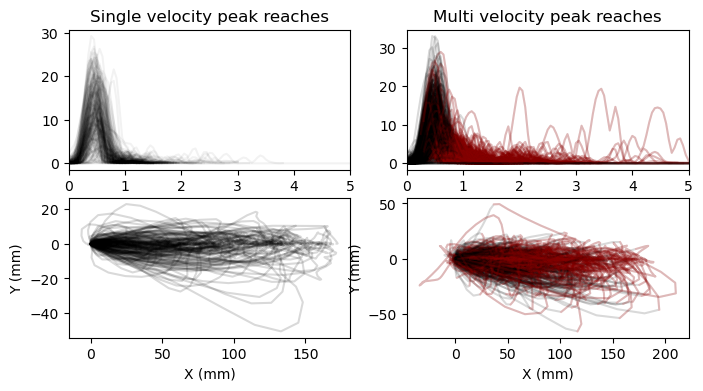

In [43]:
# Plot averaged velocity traces of single peak vs. multi peak velocities.
dat, transition_times, single_peak, multi_peak, velocity_seg, centrot_behavior, npks = reach_segment(data_files[1])
pkassign = get_peak_assignments(multi_peak, velocity_seg)

fig, ax  = plt.subplots(2, 2, figsize=(8, 4))

# Higlight the parts of trajectories implicated after the first peak as died out

for v in np.array(velocity_seg)[single_peak]:
    ax[0, 0].plot(50 * np.arange(len(v))/1000, v, alpha=0.05, color='k')dat, transition_times, single_peak, multi_peak, velocity_seg, centrot_behavior, npks = reach_segment(data_files[1])

    ax[0, 0].set_xlim([0, 100*50/1000])

for i, v in enumerate(np.array(velocity_seg)[multi_peak]):
    ax[0, 1].plot(50 * np.arange(len(v))/1000, v, alpha=0.15, color='k')
    idxs = np.argwhere(np.array(pkassign[i]) > 0).squeeze()
    ax[0, 1].plot(50 * np.arange(len(v))[idxs]/1000, v[idxs], alpha=0.15, color='r')
    ax[0, 1].set_xlim([0, 100 * 50/1000])

# Plot the center aligned and rotated behavior below
for b in np.array(centrot_behavior)[single_peak]:
    ax[1, 0].plot(b[:, 0], b[:, 1], alpha=0.15, color='k')

for i, b in enumerate(np.array(centrot_behavior)[multi_peak]):
    ax[1, 1].plot(b[:, 0], b[:, 1], alpha=0.15, color='k')
    idxs = np.argwhere(np.array(pkassign[i]) > 0).squeeze()
    ax[1, 1].plot(b[idxs, 0], b[idxs, 1], alpha=0.15, color='r')

ax[0, 0].set_title('Single velocity peak reaches', fontsize=12)
ax[0, 1].set_title('Multi velocity peak reaches', fontsize=12)
ax[0, 0].set_xlabel('Time (ms)')
ax[0, 1].set_xlabel('Time (ms)')

ax[1, 0].set_xlabel('X (mm)')
ax[1, 0].set_ylabel('Y (mm)')

ax[1, 1].set_xlabel('X (mm)')
ax[1, 1].set_ylabel('Y (mm)')

fig.savefig('/home/akumar/nse/neural_control/figs/decodingbias/reach_examples.pdf', bbox_inches='tight', pad_inches=0)

(array([244., 118.,   0.,  26.,   0.,   2.,   2.,   0.,   1.,   1.]),
 array([1. , 1.6, 2.2, 2.8, 3.4, 4. , 4.6, 5.2, 5.8, 6.4, 7. ]),
 <BarContainer object of 10 artists>)

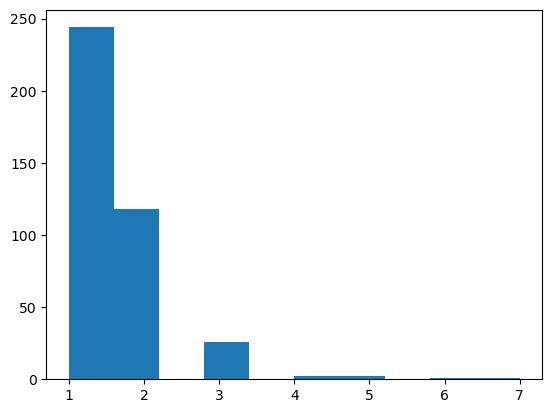

In [62]:
plt.hist(npks)

In [ ]:
# Seems to work fairly well. Now, given this separation, train decoders using FCCA/PCA across dimensionalities and datafiles. Use the no CV fits

In [8]:
# Load indy, sabes dataframes
with open('/mnt/Secondary/data/postprocessed/indy_dimreduc_nocv.dat', 'rb') as f:
    indy_df = pickle.load(f)

for f in indy_df:
    f['data_file'] = f['data_file'].split('/')[-1]

indy_df = pd.DataFrame(indy_df)
with open('/mnt/Secondary/data/postprocessed/loco_dimreduc_nocv_df.dat', 'rb') as f:
    loco_df = pickle.load(f)
loco_df = pd.DataFrame(loco_df)

In [11]:
good_loco_files = ['loco_20170210_03.mat',
'loco_20170213_02.mat',
'loco_20170215_02.mat',
'loco_20170227_04.mat',
'loco_20170228_02.mat',
'loco_20170301_05.mat',
'loco_20170302_02.mat']

loco_df = apply_df_filters(loco_df, data_file=good_loco_files)
loco_df = apply_df_filters(loco_df, loader_args={'bin_width': 50,
                                    'filter_fn': 'none',
                                    'filter_kwargs': {},
                                    'boxcox': 0.5,
                                    'spike_threshold': 100,
                                    'region': 'M1'})

In [9]:
sabes_df = pd.concat([indy_df, loco_df])

In [32]:
dimvals = np.array([2, 6, 10, 15, 20, 30])
decoding_win = 5
lags = np.array([2, 4])

dpath = '/mnt/Secondary/data/sabes'
data_files = np.unique(sabes_df['data_file'].values)


mse = np.zeros((len(data_files), len(lags), dimvals.size, 2, 6))
bias = np.zeros(mse.shape)
var = np.zeros(mse.shape)

for i, data_file in tqdm(enumerate(data_files)):
    dat, transition_times, single_peak, multi_peak, velocity_seg, centrot_behavior = reach_segment('%s/%s' % (dpath, data_file))
    for j, lag in enumerate(lags):
        for k, dim in enumerate(dimvals):
            pcadf = apply_df_filters(sabes_df, data_file=data_file, dimreduc_method='PCA', dim=dim)
            lqgdf = apply_df_filters(sabes_df, data_file=data_file, dimreduc_method='LQGCA', dim=dim)

            try:
                assert(pcadf.shape[0] == 1)
                assert(lqgdf.shape[0] == 1)
            except:
                pdb.set_trace()
            Vpca = pcadf.iloc[0]['coef']
            Vlqg = lqgdf.iloc[0]['coef']
            Z = dat['behavior'].squeeze()
            X = dat['spike_rates'].squeeze()
    
            # Apply lag
            X = X[lag:, :]
            Z = Z[:-lag, :]

            # Exclude any reaches that lie within +/- lag of the start/end of the session
            too_soon = [j for j in range(len(transition_times)) if transition_times[j][0] < lag]
            too_late = [j for j in range(len(transition_times)) if transition_times[j][1] > dat['behavior'].shape[0] - lag]

            single_peak_cp = list(deepcopy(single_peak))
            multi_peak_cp = list(deepcopy(multi_peak))

            for idx in too_soon:
                if idx in single_peak_cp:
                    single_peak_cp.remove(idx)
                elif idx in multi_peak_cp:
                    multi_peak_cp.remove(idx)
            for idx in too_late:
                if idx in single_peak_cp:
                    single_peak_cp.remove(idx)
                elif idx in multi_peak_cp:
                    multi_peak_cp.remove(idx)

            # Trialize
            Xsp = [X[transition_times[j][0]:transition_times[j][1]] for j in single_peak_cp]
            Zsp = [Z[transition_times[j][0]:transition_times[j][1]] for j in single_peak_cp]
            Xmp = [X[transition_times[j][0]:transition_times[j][1]] for j in multi_peak_cp]
            Zmp = [Z[transition_times[j][0]:transition_times[j][1]] for j in multi_peak_cp]

            Xpca_sp = [x @ Vpca for x in Xsp]
            Xpca_mp = [x @ Vpca for x in Xmp]

            Xlqg_sp = [x @ Vlqg for x in Xsp]
            Xlqg_mp = [x @ Vlqg for x in Xmp]

            # Feed into lr_decoder. Use lag of 0 since we already applied, but feed in the decoding window
            mse_, bias_, var_ = lr_bias_variance(Xpca_mp, Xpca_sp, Zmp, Zsp, 0, 0, decoding_window=decoding_win, n_boots=500) 
            
            mse[i, j, k, 0] = mse_
            bias[i, j, k, 0] = bias_
            var[i, j, k, 0] = var_                        
                        
            # Feed into lr_decoder. Use lag of 0 since we already applied, but feed in the decoding window
            mse_, bias_, var_ = lr_bias_variance(Xlqg_mp, Xlqg_sp, Zmp, Zsp, 0, 0, decoding_window=decoding_win, n_boots=500) 
            
            mse[i, j, k, 1] = mse_
            bias[i, j, k, 1] = bias_
            var[i, j, k, 1] = var_                        

0it [00:00, ?it/s]/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim
/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim
/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of list

In [22]:
with open('biasvartmp.dat', 'wb') as f:
    f.write(pickle.dumps(mse))
    f.write(pickle.dumps(bias))
    f.write(pickle.dumps(var))

In [27]:
# let's do a preliminary analysis on just the sabes data so we can move forward 

(array([6., 2., 0., 1., 5., 5., 5., 4., 4., 3.]),
 array([0.02864372, 0.03856912, 0.04849452, 0.05841992, 0.06834532,
        0.07827072, 0.08819612, 0.09812152, 0.10804692, 0.11797232,
        0.12789772]),
 <BarContainer object of 10 artists>)

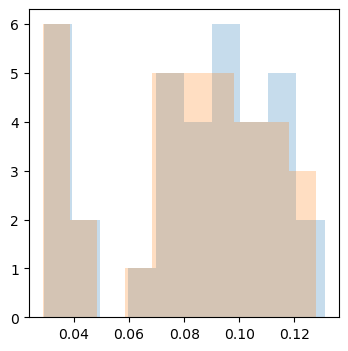

In [28]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.hist(np.linalg.norm(bias[:, 1, -1, 0, 2:4], axis=-1), alpha=0.25)
ax.hist(np.linalg.norm(bias[:, 1, -1, 1, 2:4], axis=-1), alpha=0.25)

(array([4., 6., 1., 6., 9., 5., 1., 1., 1., 1.]),
 array([0.00055077, 0.00142489, 0.00229901, 0.00317313, 0.00404724,
        0.00492136, 0.00579548, 0.00666959, 0.00754371, 0.00841783,
        0.00929195]),
 <BarContainer object of 10 artists>)

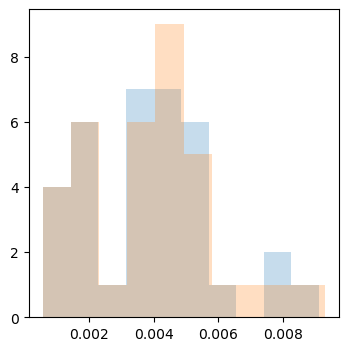

In [30]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.hist(np.linalg.norm(var[:, 1, -1, 0, 2:4], axis=-1), alpha=0.25)
ax.hist(np.linalg.norm(var[:, 1, -1, 1, 2:4], axis=-1), alpha=0.25)

(array([4., 4., 0., 2., 3., 6., 4., 5., 4., 3.]),
 array([0.02940845, 0.03977582, 0.05014319, 0.06051055, 0.07087792,
        0.08124529, 0.09161265, 0.10198002, 0.11234739, 0.12271475,
        0.13308212]),
 <BarContainer object of 10 artists>)

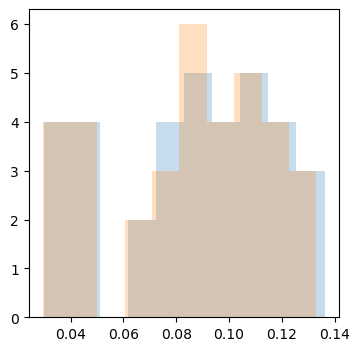

In [31]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.hist(np.linalg.norm(mse[:, 1, -1, 0, 2:4], axis=-1), alpha=0.25)
ax.hist(np.linalg.norm(mse[:, 1, -1, 1, 2:4], axis=-1), alpha=0.25)

In [ ]:
# This is odd, we should keep track of r^2 as well. Perhaps the overall decoding on the multipeak reaches is just not high enough.

In [ ]:
# Across data files, what is the histogram of the bias/variance across the 

### Windowed Bias vs. Variance

In [10]:
data_files = glob('/mnt/Secondary/data/sabes/*.mat')
dat = load_sabes(data_files[1])
dat = reach_segment_sabes(dat, start_times[data_files[1].split('/')[-1].split('.mat')[0]])

Reminder that start times depend on the bin size


/home/akumar/nse/neural_control/segmentation.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


In [7]:
# with open('/mnt/Secondary/data/postprocessed/indy_dimreduc_nocv.dat', 'rb') as f:
#     rl = pickle.load(f)
# sabes_df = pd.DataFrame(rl)

# data_idx = 0
# data_file = np.unique(sabes_df['data_file'].values)[data_idx]

# dat = load_sabes(data_file)
# dat = reach_segment_sabes(dat, start_times[data_file.split('/')[-1].split('.mat')[0]])

fls = glob('/home/akumar/nse/neural_control/data/biasvariance_vst/*.dat')
rl = []
for fl in fls:
    didx = int(fl.split('didx')[1].split('_')[0])
    with open(fl, 'rb') as f:
        bias = pickle.load(f)
        var = pickle.load(f)
        mse = pickle.load(f)
        wr2 = pickle.load(f)
        windows = pickle.load(f)        

    result = {}
    result['didx'] = didx
    result['bias'] = bias
    result['var'] = var
    result['mse'] = mse
    result['r2'] = wr2
    result['window'] = np.squeeze(windows)

    rl.append(result)

dvt_df = pd.DataFrame(rl)

In [8]:
# Create a new dataframe where we flatten across ranks
didxs = np.unique(dvt_df['didx'].values)
rl = []
for didx in didxs:
    d = apply_df_filters(dvt_df, didx=didx)
    result = {}

    windows = []
    bias = []
    var = []
    mse = []
    r2 = []
    for j in range(d.shape[0]):
        windows.extend(d.iloc[j]['window'])
        bias.append(d.iloc[j]['bias'])
        var.append(d.iloc[j]['var'])
        mse.append(d.iloc[j]['mse'])
        r2.append(d.iloc[j]['r2'])
    
    window_centers = [np.nanmean(w) for w in windows]
    center_order = np.argsort(window_centers)
    windows = np.array(windows)[center_order]
    bias = np.concatenate(bias)[center_order]
    var = np.concatenate(var)[center_order]
    mse = np.concatenate(mse)[center_order]
    r2 = np.concatenate(r2)[center_order]

    result['windows'] = windows
    result['didx'] = didx
    result['bias'] = bias
    result['var'] = var
    result['mse'] = mse
    result['r2'] = r2

    rl.append(result)

dvt_df = pd.DataFrame(rl)

/tmp/ipykernel_19370/3717778454.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  r2f = np.array(r2f).T
/tmp/ipykernel_19370/3717778454.py:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  r2p = np.array(r2p).T


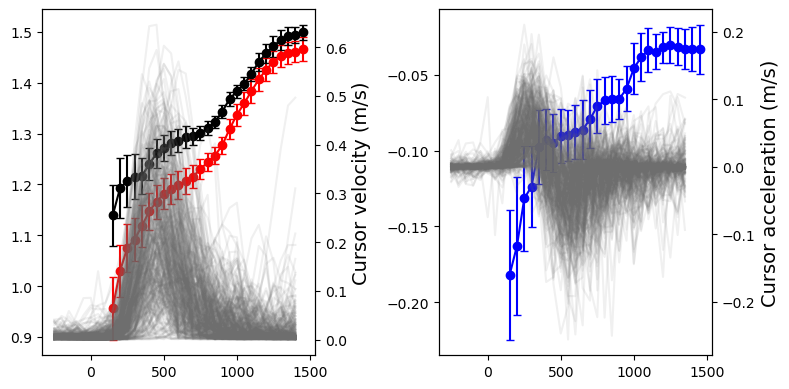

In [11]:
#fig, ax = plt.subplots(1, 3, figsize=(12, 4))
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
a = ax[0].twinx()
a2 = ax[1].twinx()


df_ = dvt_df
windows = dvt_df.iloc[0]['windows']
window_centers = np.nanmean(windows, axis=1)

r2f = []
r2p = []

mse_f = []
mse_p = []

bias_f = []
bias_p = []

var_f = []
var_p = []

for j in range(df_.shape[0]):
    r2f.append(df_.iloc[j]['r2'][:, 1, 4])
    r2p.append(df_.iloc[j]['r2'][:, 0, 4])        

    mse_f.append(np.linalg.norm(df_.iloc[j]['mse'][:, 1, 2:4], axis=-1))
    mse_p.append(np.linalg.norm(df_.iloc[j]['mse'][:, 0, 2:4], axis=-1))        

    bias_f.append(np.linalg.norm(df_.iloc[j]['bias'][:, 3, 2:4], axis=-1))
    bias_p.append(np.linalg.norm(df_.iloc[j]['bias'][:, 2, 2:4], axis=-1))        

    var_f.append(np.linalg.norm(df_.iloc[j]['var'][:, 1, 2:4], axis=-1))
    var_p.append(np.linalg.norm(df_.iloc[j]['var'][:, 0, 2:4], axis=-1))        

r2f = np.array(r2f).T
r2p = np.array(r2p).T

completed = [idx for idx, x in enumerate(r2f) if x.size == 30]

r2f = []
r2p = []

mse_f = []
mse_p = []

bias_f = []
bias_p = []

var_f = []
var_p = []

for j in completed:
    r2f.append(df_.iloc[j]['r2'][:, 1, 4])
    r2p.append(df_.iloc[j]['r2'][:, 0, 4])        

    mse_f.append(np.linalg.norm(df_.iloc[j]['mse'][:, 1, 2:4], axis=-1))
    mse_p.append(np.linalg.norm(df_.iloc[j]['mse'][:, 0, 2:4], axis=-1))        

    bias_f.append(np.linalg.norm(df_.iloc[j]['bias'][:, 1, 2:4], axis=-1))
    bias_p.append(np.linalg.norm(df_.iloc[j]['bias'][:, 0, 2:4], axis=-1))        

    var_f.append(np.linalg.norm(df_.iloc[j]['var'][:, 1, 2:4], axis=-1))
    var_p.append(np.linalg.norm(df_.iloc[j]['var'][:, 0, 2:4], axis=-1))        

r2f = np.array(bias_f).T
r2p = np.array(bias_p).T

transition_times = np.array(dat['transition_times'])
vel_all = []
acc_all = []
for tt in transition_times[::2]:
    vel = np.linalg.norm(np.diff(dat['behavior'][tt[0] - 5:tt[0] + 30], axis=0), axis=1)/(1e3 * 0.05)
    acc = np.diff(vel)
    vel_all.append(vel)
    acc_all.append(acc)
    a.plot(50 * np.arange(-5, 29), vel, color='#6e6e6e', alpha=0.1)
    a.set_ylabel('Cursor velocity (m/s)', fontsize=14)
    a2.plot(50 * np.arange(-5, 28), acc, color='#6e6e6e', alpha=0.1)
    a2.set_ylabel('Cursor acceleration (m/s)', fontsize=14)

ax[0].errorbar(50 * window_centers, [np.nanmean(r) for r in r2f], [np.nanstd(r)/np.sqrt(r.size) for r in r2f], linestyle='', capsize=3, color='r', zorder=0)
ax[0].errorbar(50 * window_centers, [np.nanmean(r) for r in r2p], [np.nanstd(r)/np.sqrt(r.size) for r in r2p], linestyle='', capsize=3, color='k', zorder=0)

ax[0].plot(50 * window_centers, [np.nanmean(r) for r in r2f], '-o', color='r', zorder=0, label='FCCA')
ax[0].plot(50 * window_centers, [np.nanmean(r) for r in r2p], '-o', color='k', zorder=0, label='PCA')

ax[1].errorbar(50 * window_centers, [np.nanmean(r1 - r2) for (r1, r2) in zip(r2f, r2p)], 
                   [np.nanstd(r1 - r2)/np.sqrt(r1.shape[0]) for (r1, r2) in zip(r2f, r2p)], linestyle='', capsize=3, color='b')
ax[1].plot(50 * window_centers, [np.nanmean(r1 - r2) for (r1, r2) in zip(r2f, r2p)], '-o', color='b')


fig.tight_layout()
#ax[0].set_ylim([0, 0.5])
#ax[1].set_ylim([0, 0.15])
# a2.set_ylim([-0.25, 0.25])


# ax[0].set_ylabel('Vel. Decoding ' + r'$r^2$', fontsize=14)
# ax[1].set_ylabel(r'$\Delta$'  + ' Vel. Decoding ' + r'$r^2$', fontsize=14)
# ax[0].set_xlabel('Decoding Window Center (ms)', fontsize=14)
# ax[1].set_xlabel('Decoding Window Center (ms)', fontsize=14)


# ax[0].set_title('Projection Dimension 6', fontsize=14)
# ax[1].set_title('Projection Dimension 6', fontsize=14)

# ax[0].legend(loc='upper left')
# ax[1].legend(loc='upper right')

# # In the last figure, plot the reaches
# z = []

# # reaches1 = np.array(dat['transition_times'])[np.argwhere(dat['target_pair_error'] >= high_error)[:, 0]]
# # reaches2 = np.array(dat['transition_times'])[np.argwhere(dat['target_pair_error'] <= low_error)[:, 0]]
# for i in range(transition_times.shape[0]):
#     z.append(dat['behavior'][transition_times[i, 0]:transition_times[i, 1]])
    
# # for i in range(0, transition_times.shape[0], 3):
# #     z_ = z[i] - z[i][0]
# #     ax[2].plot(z_[:, 0], z_[:, 1], color='k', alpha=0.25)
# #     ax[2].set_xlim([-180, 180])
# #     ax[2].set_ylim([-100, 100])    
# #     ax[2].set_aspect('equal')
# #     ax[2].set_xlabel('X (mm)', fontsize=12)
# #     ax[2].set_ylabel('Y (mm)', fontsize=12)
# #     ax[2].set_title('Example Reaches', fontsize=14)

# fig.tight_layout()
# # fig.savefig('/home/akumar/nse/neural_control/figs/decodingvtsummary/final.pdf', bbox_inches='tight', pad_inches=0)

transition_times = np.array(dat['transition_times'])
vel_all = []
acc_all = []
for tt in transition_times[::2]:
    vel = np.linalg.norm(np.diff(dat['behavior'][tt[0] - 5:tt[0] + 30], axis=0), axis=1)/(1e3 * 0.05)
    acc = np.diff(vel)
    vel_all.append(vel)
    acc_all.append(acc)
    a.plot(50 * np.arange(-5, 29), vel, color='#6e6e6e', alpha=0.1)
    a.set_ylabel('Cursor velocity (m/s)', fontsize=14)
    a2.plot(50 * np.arange(-5, 28), acc, color='#6e6e6e', alpha=0.1)
50 * window_centers

In [31]:
window_centers

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29.])

### Dim 6, Narrower Windows, using 0.4 peak criterion

In [16]:
data_files = glob('/mnt/Secondary/data/sabes/*.mat')
dat = load_sabes(data_files[1])
dat = reach_segment_sabes(dat, start_times[data_files[1].split('/')[-1].split('.mat')[0]])

Reminder that start times depend on the bin size


/home/akumar/nse/neural_control/segmentation.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


In [13]:
# with open('/mnt/Secondary/data/postprocessed/indy_dimreduc_nocv.dat', 'rb') as f:
#     rl = pickle.load(f)
# sabes_df = pd.DataFrame(rl)

# data_idx = 0
# data_file = np.unique(sabes_df['data_file'].values)[data_idx]

# dat = load_sabes(data_file)
# dat = reach_segment_sabes(dat, start_times[data_file.split('/')[-1].split('.mat')[0]])

fls = glob('/home/akumar/nse/neural_control/data/biasvariance_vst3/*.dat')
rl = []
for fl in fls:
    didx = int(fl.split('didx')[1].split('_')[0])
    with open(fl, 'rb') as f:
        bias = pickle.load(f)
        var = pickle.load(f)
        mse = pickle.load(f)
        wr2 = pickle.load(f)
        windows = pickle.load(f)        

    result = {}
    result['didx'] = didx
    result['bias'] = bias
    result['var'] = var
    result['mse'] = mse
    result['r2'] = wr2
    result['window'] = np.squeeze(windows)

    rl.append(result)

dvt_df = pd.DataFrame(rl)

In [14]:
# Create a new dataframe where we flatten across ranks
didxs = np.unique(dvt_df['didx'].values)
rl = []
for didx in didxs:
    d = apply_df_filters(dvt_df, didx=didx)
    result = {}

    windows = []
    bias = []
    var = []
    mse = []
    r2 = []
    for j in range(d.shape[0]):
        windows.extend(d.iloc[j]['window'])
        bias.append(d.iloc[j]['bias'])
        var.append(d.iloc[j]['var'])
        mse.append(d.iloc[j]['mse'])
        r2.append(d.iloc[j]['r2'])
    
    window_centers = [np.nanmean(w) for w in windows]
    center_order = np.argsort(window_centers)
    windows = np.array(windows)[center_order]
    bias = np.concatenate(bias)[center_order]
    var = np.concatenate(var)[center_order]
    mse = np.concatenate(mse)[center_order]
    r2 = np.concatenate(r2)[center_order]

    result['windows'] = windows
    result['didx'] = didx
    result['bias'] = bias
    result['var'] = var
    result['mse'] = mse
    result['r2'] = r2

    rl.append(result)

dvt_df = pd.DataFrame(rl)

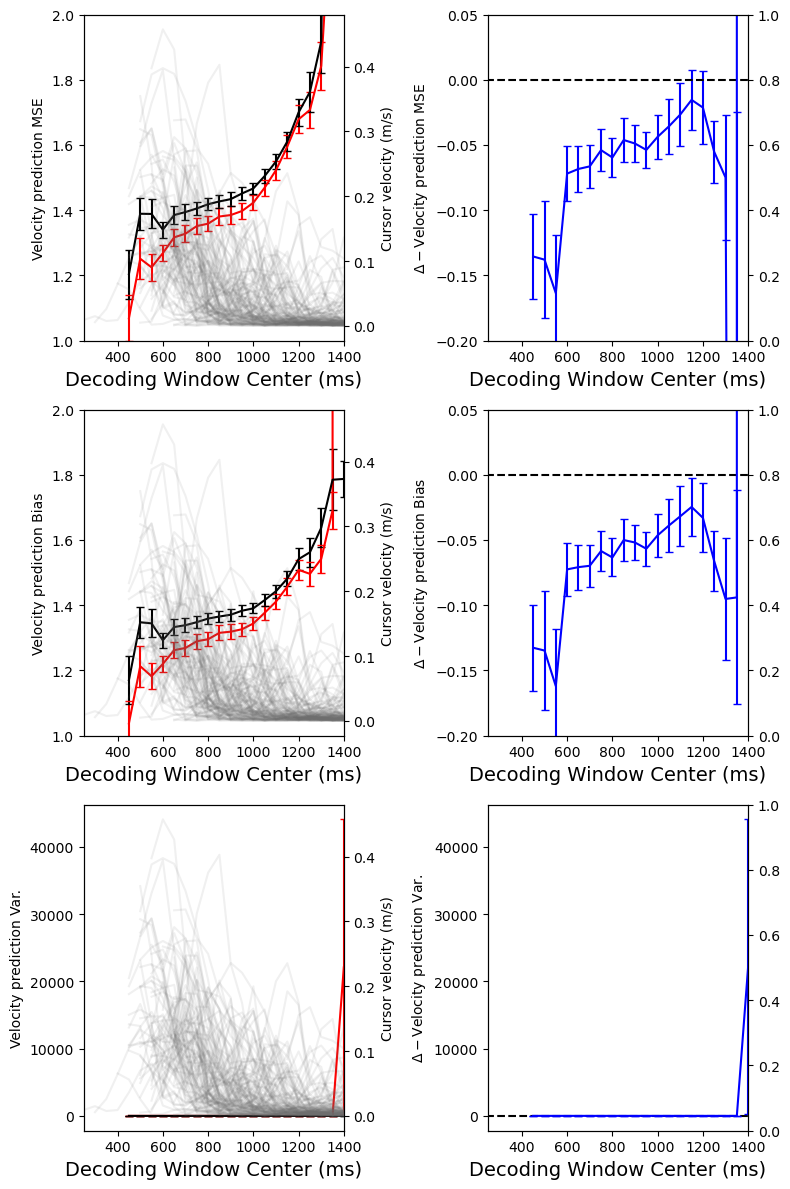

In [17]:
#fig, ax = plt.subplots(1, 3, figsize=(12, 4))
fig, ax = plt.subplots(3, 2, figsize=(8, 12))

a = [ax[j, 0].twinx() for j in range(3)]
a2 = [ax[j, 1].twinx() for j in range(3)]

df_ = dvt_df
windows = dvt_df.iloc[0]['windows']
window_centers = np.nanmean(windows, axis=1)

r2f = []
r2p = []

mse_f = []
mse_p = []

bias_f = []
bias_p = []

var_f = []
var_p = []

for j in range(df_.shape[0]):
    r2f.append(df_.iloc[j]['r2'][:, 3, 4])
    r2p.append(df_.iloc[j]['r2'][:, 2, 4])        

    mse_f.append(np.linalg.norm(df_.iloc[j]['mse'][:, 3, 2:4], axis=-1))
    mse_p.append(np.linalg.norm(df_.iloc[j]['mse'][:, 2, 2:4], axis=-1))        

    bias_f.append(np.linalg.norm(df_.iloc[j]['bias'][:, 3, 2:4], axis=-1))
    bias_p.append(np.linalg.norm(df_.iloc[j]['bias'][:, 2, 2:4], axis=-1))        

    var_f.append(np.linalg.norm(df_.iloc[j]['var'][:, 3, 2:4], axis=-1))
    var_p.append(np.linalg.norm(df_.iloc[j]['var'][:, 2, 2:4], axis=-1))        

r2f = np.array(r2f)
r2p = np.array(r2p)

completed = [idx for idx, x in enumerate(r2f) if x.size == 30]

r2f = []
r2p = []

mse_f = []
mse_p = []

bias_f = []
bias_p = []

var_f = []
var_p = []

for j in completed:
    r2f.append(df_.iloc[j]['r2'][:, 7, 4])
    r2p.append(df_.iloc[j]['r2'][:, 6, 4])        

    mse_f.append(np.linalg.norm(df_.iloc[j]['mse'][:, 3, 2:4], axis=-1))
    mse_p.append(np.linalg.norm(df_.iloc[j]['mse'][:, 2, 2:4], axis=-1))        

    bias_f.append(np.linalg.norm(df_.iloc[j]['bias'][:, 3, 2:4], axis=-1))
    bias_p.append(np.linalg.norm(df_.iloc[j]['bias'][:, 2, 2:4], axis=-1))        

    var_f.append(np.linalg.norm(df_.iloc[j]['var'][:, 3, 2:4], axis=-1))
    var_p.append(np.linalg.norm(df_.iloc[j]['var'][:, 2, 2:4], axis=-1))        

mse_f = np.array(mse_f).T
mse_p = np.array(mse_p).T

bias_f = np.array(bias_f).T
bias_p = np.array(bias_p).T

var_f = np.array(var_f).T
var_p = np.array(var_p).T

transition_times = np.array(dat['transition_times'])
vel_all = []
acc_all = []

for tt in transition_times[::2]:
    vel = np.linalg.norm(np.diff(dat['behavior'][tt[0] - 5:tt[0] + 30], axis=0), axis=1)/(1e3 * 0.05)
    velocity_normseg = vel/np.max(vel)
    pks = scipy.signal.find_peaks(velocity_normseg, height=0.5)[0]

    # Plot only the secondary velocity peaks, which are what the r^2 are assessed against
    def closest_peak(pks, pnt):
        if len(pks) > 0:
            pk_dist = [np.abs(pk - pnt) for pk in pks]
            return np.argmin(pk_dist)
        else:
            return 0

    pkassign = np.array([closest_peak(pks, t) for t in range(len(vel))])
    t = np.arange(-5, 29)[pkassign > 0]
    vel = vel[pkassign > 0]
    acc = np.diff(vel)
    # vel_all.append(vel)
    # acc_all.append(acc)
    for a_ in a:
        a_.plot(50 * t, vel, color='#6e6e6e', alpha=0.1)
        a_.set_ylabel('Cursor velocity (m/s)')
    #for a2_ in a2:
        #a2_.plot(50 * t[:-1], acc, color='#6e6e6e', alpha=0.1)
        #a2_.set_ylabel('Cursor acceleration (m/s)', fontsize=14)

ax[0, 0].errorbar(50 * window_centers, [np.nanmean(r) for r in mse_f], [np.nanstd(r)/np.sqrt(r.size) for r in mse_f], linestyle='-', capsize=3, color='r', zorder=0)
ax[0, 0].errorbar(50 * window_centers, [np.nanmean(r) for r in mse_p], [np.nanstd(r)/np.sqrt(r.size) for r in mse_p], linestyle='-', capsize=3, color='k', zorder=0)
ax[0, 1].errorbar(50 * window_centers, [np.nanmean(r1 - r2) for (r1, r2) in zip(mse_f, mse_p)], 
                [np.nanstd(r1 - r2)/np.sqrt(r1.shape[0]) for (r1, r2) in zip(mse_f, mse_p)], linestyle='-', capsize=3, color='b')

# ax[0].plot(50 * window_centers, [np.nanmean(r) for r in mse_f], [np.nanstd(r)/np.sqrt(r.size) for r in mse_f], e='', capsize=3, color='r', zorder=0)
# ax[0].plot(50 * window_centers, [np.nanmean(r) for r in mse_p], [np.nanstd(r)/np.sqrt(r.size) for r in mse_p], linestyle='', capsize=3, color='k', zorder=0)


# ax[0].plot(50 * window_centers, [np.nanmean(r) for r in r2f], '-o', color='r', zorder=0, label='FCCA')
# ax[0].plot(50 * window_centers, [np.nanmean(r) for r in r2p], '-o', color='k', zorder=0, label='PCA')

ax[1, 0].errorbar(50 * window_centers, [np.nanmean(r) for r in bias_f], [np.nanstd(r)/np.sqrt(r.size) for r in bias_f], linestyle='-', capsize=3, color='r', zorder=0)
ax[1, 0].errorbar(50 * window_centers, [np.nanmean(r) for r in bias_p], [np.nanstd(r)/np.sqrt(r.size) for r in bias_p], linestyle='-', capsize=3, color='k', zorder=0)
ax[1, 1].errorbar(50 * window_centers, [np.nanmean(r1 - r2) for (r1, r2) in zip(bias_f, bias_p)], 
                [np.nanstd(r1 - r2)/np.sqrt(r1.shape[0]) for (r1, r2) in zip(bias_f, bias_p)], linestyle='-', capsize=3, color='b')


ax[2, 0].errorbar(50 * window_centers, [np.nanmean(r) for r in var_f], [np.nanstd(r)/np.sqrt(r.size) for r in var_f], linestyle='-', capsize=3, color='r', zorder=0)
ax[2, 0].errorbar(50 * window_centers, [np.nanmean(r) for r in var_p], [np.nanstd(r)/np.sqrt(r.size) for r in var_p], linestyle='-', capsize=3, color='k', zorder=0)
ax[2, 1].errorbar(50 * window_centers, [np.nanmean(r1 - r2) for (r1, r2) in zip(var_f, var_p)], 
                [np.nanstd(r1 - r2)/np.sqrt(r1.shape[0]) for (r1, r2) in zip(var_f, var_p)], linestyle='-', capsize=3, color='b')

for j in range(3):
    ax[j, 1].hlines(0, 0, 1500, linestyles='dashed', colors='k')

ax[0, 0].set_ylabel('Velocity prediction MSE')
ax[1, 0].set_ylabel('Velocity prediction Bias')
ax[2, 0].set_ylabel('Velocity prediction Var.')

ax[0, 1].set_ylabel(r'$\Delta-$' + 'Velocity prediction MSE')
ax[1, 1].set_ylabel(r'$\Delta-$' + 'Velocity prediction Bias')
ax[2, 1].set_ylabel(r'$\Delta-$' + 'Velocity prediction Var.')

# ax[0].set_ylabel('Vel. Decoding ' + r'$r^2$', fontsize=14)
# ax[1].set_ylabel(r'$\Delta$'  + ' Vel. Decoding ' + r'$r^2$', fontsize=14)

for j in range(3):
    ax[j, 0].set_xlim(250, 1400)
    ax[j, 1].set_xlim(250, 1400)

    ax[j, 0].set_xlabel('Decoding Window Center (ms)', fontsize=14)
    ax[j, 1].set_xlabel('Decoding Window Center (ms)', fontsize=14)

ax[0, 0].set_ylim(1, 2)
ax[0, 1].set_ylim(-0.2, 0.05)

ax[1, 0].set_ylim(1, 2)
ax[1, 1].set_ylim(-0.2, 0.05)

fig.tight_layout()
#fig.savefig('/home/akumar/nse/neural_control/figs/decodingbias/singlepktrain_multipeaktest.pdf', bbox_inches='tight', pad_inches=0)

In [11]:
data_files = glob('/mnt/Secondary/data/sabes/*.mat')
dat = load_sabes(data_files[4])
dat = reach_segment_sabes(dat, start_times[data_files[1].split('/')[-1].split('.mat')[0]])
transition_times = np.array(dat['transition_times'])


Reminder that start times depend on the bin size


/home/akumar/nse/neural_control/segmentation.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


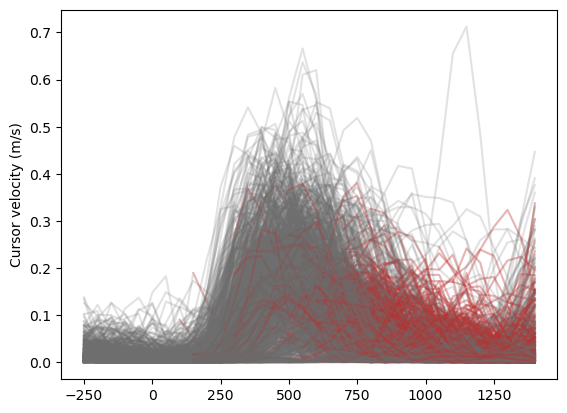

In [30]:
fig, ax = plt.subplots()
for tt in transition_times[::2]:
    vel = np.linalg.norm(np.diff(dat['behavior'][tt[0] - 5:tt[0] + 30], axis=0), axis=1)/(1e3 * 0.05)
    velocity_normseg = vel/np.max(vel)
    pks = scipy.signal.find_peaks(velocity_normseg, height=0.4)[0]

    # Plot only the secondary velocity peaks, which are what the r^2 are assessed against
    def closest_peak(pks, pnt):
        pk_dist = [np.abs(pk - pnt) for pk in pks]
        if len(pk_dist) > 0:
            return np.argmin(pk_dist)
        else:
            return 0

    pkassign = np.array([closest_peak(pks, t) for t in range(len(vel))])
    t = np.arange(-5, 29)
    ax.plot(50 * t, vel, color='#6e6e6e', alpha=0.2)
    t = np.arange(-5, 29)[pkassign > 0]
    vel = vel[pkassign > 0]
    ax.plot(50 * t, vel, color='red', alpha=0.2)
    ax.set_ylabel('Cursor velocity (m/s)')

In [ ]:
# Plot with gradient

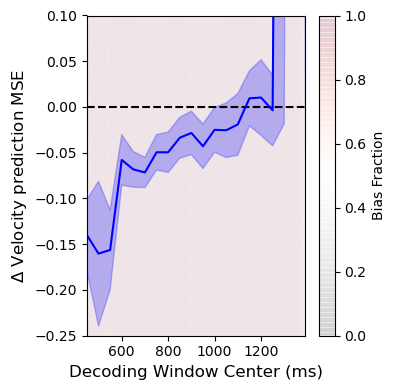

In [98]:
#fig, ax = plt.subplots(1, 3, figsize=(12, 4))
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

df_ = dvt_df
windows = dvt_df.iloc[0]['windows']
window_centers = np.nanmean(windows, axis=1)

r2f = []
r2p = []

mse_f = []
mse_p = []

bias_f = []
bias_p = []

var_f = []
var_p = []

for j in range(df_.shape[0]):
    r2f.append(df_.iloc[j]['r2'][:, 5, 4])
    r2p.append(df_.iloc[j]['r2'][:, 4, 4])        

    mse_f.append(np.linalg.norm(df_.iloc[j]['mse'][:, 5, 2:4], axis=-1))
    mse_p.append(np.linalg.norm(df_.iloc[j]['mse'][:, 4, 2:4], axis=-1))        

    bias_f.append(np.linalg.norm(df_.iloc[j]['bias'][:, 5, 2:4], axis=-1))
    bias_p.append(np.linalg.norm(df_.iloc[j]['bias'][:, 4, 2:4], axis=-1))        

    var_f.append(np.linalg.norm(df_.iloc[j]['var'][:, 5, 2:4], axis=-1))
    var_p.append(np.linalg.norm(df_.iloc[j]['var'][:, 4, 2:4], axis=-1))        xpca_j

r2f = np.array(r2f)
r2p = np.array(r2p)

completed = [idx for idx, x in enumerate(r2f) if x.size == 30]

r2f = []
r2p = []

mse_f = []
mse_p = []

bias_f = []
bias_p = []

var_f = []
var_p = []

for j in completed:
    r2f.append(df_.iloc[j]['r2'][:, 7, 4])
    r2p.append(df_.iloc[j]['r2'][:, 6, 4])        

    mse_f.append(np.linalg.norm(df_.iloc[j]['mse'][:, 5, 2:4], axis=-1))
    mse_p.append(np.linalg.norm(df_.iloc[j]['mse'][:, 4, 2:4], axis=-1))        

    bias_f.append(np.linalg.norm(df_.iloc[j]['bias'][:, 5, 2:4], axis=-1))
    bias_p.append(np.linalg.norm(df_.iloc[j]['bias'][:, 4, 2:4], axis=-1))        

    var_f.append(np.linalg.norm(df_.iloc[j]['var'][:, 5, 2:4], axis=-1))
    var_p.append(np.linalg.norm(df_.iloc[j]['var'][:, 4, 2:4], axis=-1))        

mse_f = np.array(mse_f).T
mse_p = np.array(mse_p).T

bias_f = np.array(bias_f).T
bias_p = np.array(bias_p).T

var_f = np.array(var_f).T
var_p = np.array(var_p).T

# Background gradient representing fraction of mse comprised of bias vs. variance
#x = np.linspace(50*window_centers[0], 50*window_centers[1],  256)
#y = np.linspace(1, 2, 256)

#xArray, yArray = np.meshgrid(x, y)
plotArray = np.array([np.nanmean(np.divide(np.abs(b1 - b2), np.abs(m1 - m2))) for b1, b2, m1, m2 in zip(bias_f, bias_p, mse_f, mse_p)])
#ax.plot(50 * window_centers, plotArray)

# Upsample and smooth
p = plotArray[np.invert(np.isnan(plotArray))]
wc = window_centers[np.invert(np.isnan(plotArray))]

p = scipy.signal.resample(p, 256)
wc_up = np.linspace(wc[0], wc[-1], 256)
p = scipy.ndimage.gaussian_filter(p, sigma=1)
h = ax.pcolormesh(50 * wc_up, np.linspace(-0.25, 0.1), np.tile(p[:, np.newaxis], (1, 50)).T, cmap='RdGy_r', shading='nearest', vmin=0, vmax=1, alpha=0.1, linewidth=0, antialiased=True)
ax.plot(50 * window_centers, [np.nanmean(r1 - r2) for (r1, r2) in zip(mse_f, mse_p)], linestyle='-', color='b')
fig.colorbar(h, label='Bias Fraction')
ax.fill_between(50 * window_centers, [np.nanmean(r1 - r2) - np.nanstd(r1 - r2)/np.sqrt(r1.size) for (r1, r2) in zip(mse_f, mse_p)], 
                                     [np.nanmean(r1 - r2) + np.nanstd(r1 - r2)/np.sqrt(r1.size) for (r1, r2) in zip(mse_f, mse_p)], color='b', alpha=0.25)

ax.set_ylabel(r'$\Delta$' + ' Velocity prediction MSE', fontsize=12)
ax.set_xlabel('Decoding Window Center (ms)', fontsize=12)
ax.hlines(0, 450, 1400,color='k', linestyles='--')
ax.set_xlim(450, 1390)
ax.set_ylim(-0.25, 0.1)


fig.tight_layout()
#fig.savefig('/home/akumar/nse/neural_control/figs/decodingbias/singlepktrain_multipeaktest.pdf', bbox_inches='tight', pad_inches=0)

### Trajectory Visualization

In [ ]:
# First align all multipeak trajectories together via rotation/scaling and then highlight the latter portion.
# Plot distance from the target as a function of time and highlight the latter portion
# Visualize actual trajectory vs. predictions.

In [18]:
# Choose the data file for which the bias/variance difference is greatest
bias_f.shape

(30, 35)

In [27]:
np.sum(bias_f[5:25] - bia    transition_times[idx] + 1
s_p[5:25], axis=0)

array([        nan,         nan,         nan, -0.32454033, -4.02242918,
               nan,         nan,         nan,         nan, -1.07101345,
               nan,         nan,         nan,         nan,         nan,
       -1.24207607,  0.28639333,         nan,  0.6899932 ,         nan,
               nan, -1.22932747, -0.1742514 ,         nan,         nan,
       -1.80090491,  0.24113655,  2.78416722, -4.9078979 , -3.84887804,
       -5.3537246 ,         nan, -2.73496825, -0.8506995 ,         nan])

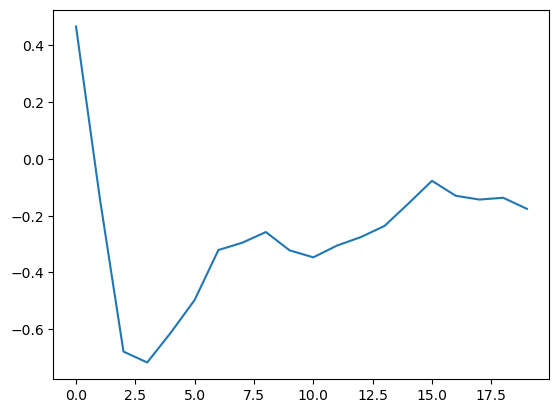

In [28]:
plt.plot(bias_f[5:25, 30] - bias_p[5:25, 30])

In [30]:
data_files = glob('/mnt/Secondary/data/sabes/*.mat')
dat = load_sabes(data_files[30])
dat = reach_segment_sabes(dat, start_times[data_files[30].split('/')[-1].split('.mat')[0]])

Reminder that start times depend on the bin size


/home/akumar/nse/neural_control/segmentation.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


In [31]:
from scipy.ndimage import gaussian_filter1d

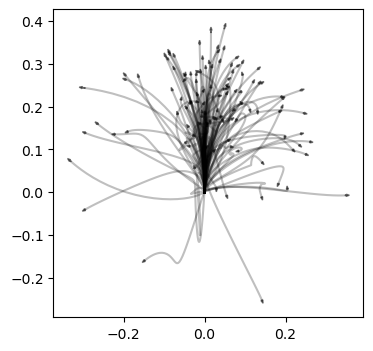

In [42]:
transition_times = np.array(dat['transition_times'])
fig, ax = plt.subplots(figsize=(4, 4))
z = dat['behavior']
vel = np.diff(dat['behavior'], axis=0)
# Find the multipeak reaches.
velocity = scipy.ndimage.gaussian_filter1d(vel, axis=0, sigma=1)
velocity_seg = [np.linalg.norm(velocity[t[0]:t[1], :], axis=1) for t in transition_times]
velocity_normseg = [v/np.max(v) for v in velocity_seg]
npks = [len(scipy.signal.find_peaks(v, height=0.15)[0]) for v in velocity_normseg]

single_peak = np.argwhere(np.array(npks) == 1).squeeze()
multi_peak = np.argwhere(np.bitwise_and(np.array(npks) > 1, np.array(npks) < 5)).squeeze()

for idx in multi_peak[::2]:
    t0 = transition_times[idx][0]
    t1 = transition_times[idx][1]
    #t1 = min(transition_times[idx][0] + 40, transition_times[idx][1])

    trajectory = gaussian_filter1d(z[t0:t1], 
                                sigma=5, axis=0)

    # Center and normalize trajectories
    trajectory -= trajectory[0]
    trajectory /= np.linalg.norm(trajectory)

    # Rotate trajectory so that the first 5 timesteps all go off at the same angle
    theta0 = np.arctan2(trajectory[5, 1], trajectory[5, 0])

    # Rotate *clockwise* by theta
    R = lambda theta: np.array([[np.cos(-1*theta), -np.sin(-theta)], \
                                    [np.sin(-theta), np.cos(theta)]])        
    trajectory = np.array([R(theta0 - np.pi/2) @ t[0:2] for t in trajectory])

    ax.plot(trajectory[:, 0], trajectory[:, 1], 'k', alpha=0.25)
    ax.arrow(trajectory[-1, 0], trajectory[-1, 1], 
                trajectory[-1, 0] - trajectory[-2, 0], trajectory[-1, 1] - trajectory[-2, 1], 
                head_width=0.005, color="k", alpha=0.5)


In [7]:
data_files = glob('/mnt/Secondary/data/sabes/*.mat')
good_loco_files = ['/mnt/Secondary/data/sabes/%s' % f for f in ['loco_20170210_03.mat',
'loco_20170213_02.mat',
'loco_20170215_02.mat',
'loco_20170227_04.mat',
'loco_20170228_02.mat',
'loco_20170301_05.mat',
'loco_20170302_02.mat']]
data_files = [fl for fl in data_files if fl in good_loco_files or 'indy' in fl ]

In [355]:
from itertools import groupby

In [367]:
np.max([len(list(group)) for key, group in groupby(np.sign([-1, -2, -3, -4, -5, -5])) if key < 0])

6

In [ ]:
result = max((list(group) for key, group in groupby(series) if key < 0), key=len)

In [467]:
# Across recording sessions, record the distance from target
dt = []
vel = []

dtpks = []
dtpkw = []
dttrghs = []
veltr = []
velpks = []

for i, data_file in tqdm(enumerate(data_files)):
    dat = load_sabes(data_file)
    # Note the lower error threshold
    dat = reach_segment_sabes(dat, data_file=data_file.split('/')[-1].split('.mat')[0], err_thresh=0.8)

    # Measure the distance from target
    dt.append([])
    vel.append([])
    dtpks.append([])
    dttrghs.append([])
    veltr.append([])
    velpks.append([])
    dtpkw.append([])
    # Calculate 
    # (1) The peaks in distance to target
    # (2) troughs in velocity
    # (3) Number of velocity peaks/velocity troughs

    # Intersection
    transition_times = np.array(dat['transition_times'])
    for j, tt in enumerate(transition_times):        
        target_loc = dat['target_pairs'][j][1]

        vel_ = np.linalg.norm(np.diff(dat['behavior'][tt[0]:tt[1]], axis=0), axis=1)
        dt_ = np.linalg.norm(dat['behavior'][tt[0]:tt[1]] - dat['target_pairs'][j][1], axis=1)

        vel[i].append(vel_)
        dt[i].append(dt_)
        
        pks, _ = scipy.signal.find_peaks(dt_/np.max(dt_), height=0.1, prominence=0.1)

        # Require that the peak comes after the maximum value
        pks = pks[pks > np.argmax(dt_)]
        # Require that we have gotten at least halfway to the target, but not too close
        if len(pks) > 0:
            if np.any((dt_/np.max(dt_))[:pks[0]] < 0.5) and not np.any((dt_/np.max(dt_))[:pks[0]] < 0.1):
                # Get the FWHM of the peak widths
                w, _, l, r = scipy.signal.peak_widths(dt_/np.max(dt_), [pks[0]], rel_height=0.5)
                dtpkw[i].append(int(np.floor(l[0])))
            else:
                pks = []
                dtpkw[i].append(np.nan)
        else:
            dtpkw[i].append(np.nan)

        trghs, _ = scipy.signal.find_peaks(-1*vel_/np.max(vel_), height=-0.5)
        
        dtpks[i].append(pks)
        veltr[i].append(trghs)

        pks, _ = scipy.signal.find_peaks(vel_/np.max(vel_), height=0.1, prominence=0.1)
        trghs, _ = scipy.signal.find_peaks(-1*dt_/np.max(dt_), height=-0.5)

        velpks[i].append(pks)
        dttrghs[i].append(trghs)

0it [00:00, ?it/s]/home/akumar/nse/neural_control/segmentation.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
1it [00:03,  3.31s/it]

Reminder that start times depend on the bin size


2it [00:14,  8.13s/it]

Reminder that start times depend on the bin size
Reminder that start times depend on the bin size


4it [00:33,  8.29s/it]

Reminder that start times depend on the bin size
Reminder that start times depend on the bin size


5it [00:55, 13.02s/it]

Reminder that start times depend on the bin size


7it [01:06,  8.68s/it]

Reminder that start times depend on the bin size


8it [01:09,  6.68s/it]

Reminder that start times depend on the bin size


9it [01:12,  5.54s/it]

Reminder that start times depend on the bin size


10it [01:14,  4.66s/it]

Reminder that start times depend on the bin size


11it [01:17,  4.00s/it]

Reminder that start times depend on the bin size


12it [01:20,  3.79s/it]

Reminder that start times depend on the bin size


13it [01:23,  3.62s/it]

Reminder that start times depend on the bin size


14it [01:28,  3.85s/it]

Reminder that start times depend on the bin size


15it [01:31,  3.71s/it]

Reminder that start times depend on the bin size


16it [01:35,  3.63s/it]

Reminder that start times depend on the bin size


17it [01:38,  3.47s/it]

Reminder that start times depend on the bin size


18it [01:41,  3.43s/it]

Reminder that start times depend on the bin size


19it [01:44,  3.38s/it]

Reminder that start times depend on the bin size


20it [01:48,  3.51s/it]

Reminder that start times depend on the bin size


21it [01:53,  3.87s/it]

Reminder that start times depend on the bin size


22it [01:56,  3.57s/it]

Reminder that start times depend on the bin size


23it [01:59,  3.58s/it]

Reminder that start times depend on the bin size


24it [02:03,  3.61s/it]

Reminder that start times depend on the bin size


25it [02:07,  3.72s/it]

Reminder that start times depend on the bin size


26it [02:11,  3.75s/it]

Reminder that start times depend on the bin size


27it [02:16,  4.06s/it]

Reminder that start times depend on the bin size


28it [02:21,  4.43s/it]

Reminder that start times depend on the bin size


29it [02:32,  6.48s/it]

Reminder that start times depend on the bin size
Reminder that start times depend on the bin size


31it [02:54,  8.47s/it]

Reminder that start times depend on the bin size
Reminder that start times depend on the bin size


32it [03:07,  9.85s/it]

Reminder that start times depend on the bin size


34it [03:27,  9.56s/it]

Reminder that start times depend on the bin size
Reminder that start times depend on the bin size


35it [03:42,  6.34s/it]


In [483]:
with open('dtcalc.pkl', 'wb') as f:
    for x in [dt, vel, dtpks, dttrghs, velpks, veltr, dtpkw]:    
        f.write(pickle.dumps(x))

In [374]:
# What is distribution of the time between a peak in the distance to target and a trough in the velocity?
dtvellag = []
for i in range(len(dt)):
    dtvellag.append([])
    for j in range(len(dt[i])):
        # For each peak in the dt, find the time to the closest trough in the velocity
        lags = []
        if len(veltr[i][j]) > 0:
            for pk in dtpks[i][j]:
                lags.append(np.min(np.abs(pk - np.array(veltr[i][j]))))
        dtvellag[i].append(lags)            

In [375]:
# What are the number of reaches with non-zero coincidence between a secondary peak in distance to target and trough in velocity?

In [439]:
cnt = 0
total_reaches = 0

cnt_per1 = np.zeros(len(dtvellag))
cnt_per2 = np.zeros(len(dt))
for i in range(len(dtvellag)):
    for j in range(len(dtvellag[i])):
        if np.any(np.array(dtvellag[i][j]) <= 2):
            cnt += 1
            cnt_per[i] += 1

        if len(dtpks[i][j]) > 0:
            cnt_per2[i] += 1
        
        total_reaches += 1

In [440]:
# Use data file 4 for visualization purposes
cnt_per2

array([ 16.,  49.,  55.,   5., 118.,  63.,  15.,  22.,  19.,   7.,  12.,
        14.,  15.,  21.,  22.,   8.,  21.,  16.,  18.,  25.,  18.,  22.,
        18.,  27.,  27.,  12.,  17.,  29.,  63., 109.,  33.,  34.,  42.,
        32.,  47.])

In [441]:
np.sum(cnt_per2)

1071.0

In [286]:
# Rotate reach to a common reference frame
def rotate_reach(z, trgt, th):
    trajectory = gaussian_filter1d(z, sigma=2, axis=0)

    # Center trajectory
    trajectory -= trajectory[0]

    # Rotate trajectory so that the first 5 timesteps all go off at the same angle
    #theta0 = np.arctan2(trajectory[5, 1], trajectory[5, 0])

    # Rotate trajectory so that the target start to end target has common alignment
    xy = trgt[1] - trgt[0]
    theta0 = np.arctan2(xy[1], xy[0])

    # Rotate *clockwise* by theta
    R = lambda theta: np.array([[np.cos(-1*theta), -np.sin(-theta)], \
                                    [np.sin(-theta), np.cos(theta)]])        
    trajectory = np.array([R(theta0 - th) @ t[0:2] for t in trajectory])

    return trajectory

In [480]:
dat = load_sabes(data_files[4])
dat = reach_segment_sabes(dat, data_file=data_files[4].split('/')[-1].split('.mat')[0], err_thresh=0.8)
transition_times = np.array(dat['transition_times'])
assert(len(transition_times) == len(dt[4]))

Reminder that start times depend on the bin size


/home/akumar/nse/neural_control/segmentation.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


In [ ]:
# Visualization 1: Straight vs. reaches with corrective component
# Visualization 2: Handful of dt and vel curves superimposed (~ 5)

In [389]:
from itertools import groupby

In [8]:
data_files[4]

'/mnt/Secondary/data/sabes/indy_20160627_01.mat'

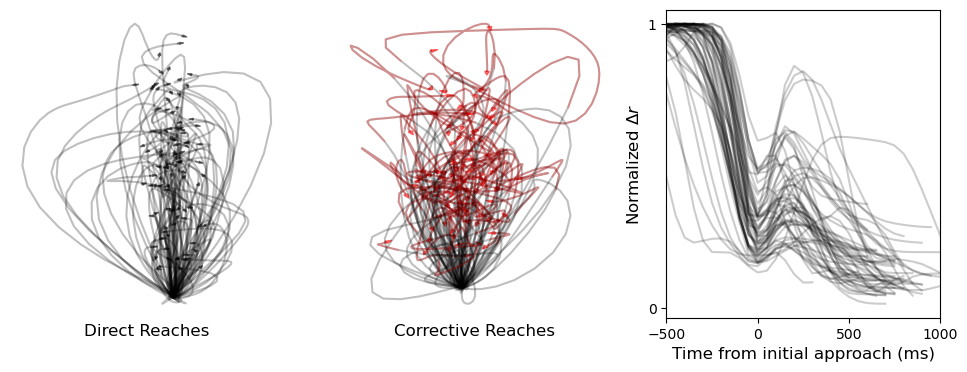

In [481]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

#corrective_reaches = [idx for idx in range(len(dtvellag[4])) if np.any(np.array(dtvellag[4][idx]) <= 2)]
#corrective_reaches = [idx for idx in range(len(dt[4])) if len(dttrghs[4][idx]) > 0] 
corrective_reaches = [idx for idx in range(len(dt[4])) if len(dtpks[4][idx]) > 0]
# In contrast, plot reaches that are straight
straight_reaches = [idx for idx in range(len(dt[4])) if len(dtpks[4][idx]) == 0]

for j in straight_reaches[0:100]:         
    tt = transition_times[j]
    # If the teach contains a secondary peak in dt accompanied by a dip in velocity, plot it
    z = dat['behavior'][tt[0]:tt[1], :]

    trajectory = rotate_reach(z, dat['target_pairs'][j], np.pi/2)
    ax[0].plot(trajectory[:, 0], trajectory[:, 1], 'k', alpha=0.25)
    ax[0].arrow(trajectory[-1, 0], trajectory[-1, 1], 
                trajectory[-1, 0] - trajectory[-2, 0], trajectory[-1, 1] - trajectory[-2, 1], 
                head_width=1, color="k", alpha=0.5)

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
ax[0].spines['left'].set_visible(False)

ax[0].set_xticks([])
ax[0].set_yticks([])

for j in corrective_reaches[0:100]:         
    tt = transition_times[j]
    # If the teach contains a secondary peak in dt accompanied by a dip in velocity, plot it
    z = dat['behavior'][tt[0]:tt[1], :]

    trajectory = rotate_reach(z, dat['target_pairs'][j], np.pi/2)
    ax[1].plot(trajectory[:, 0], trajectory[:, 1], 'k', alpha=0.25)
    
    assert(not np.any(np.isnan(dtpkw[4][j])))

    # Highlight the post trough portion of the reach (used in bias variance calculation)
    ax[1].plot(trajectory[dtpkw[4][j]:, 0], trajectory[dtpkw[4][j]:, 1], 'r', alpha=0.25)

    ax[1].arrow(trajectory[-1, 0], trajectory[-1, 1], 
                trajectory[-1, 0] - trajectory[-2, 0], trajectory[-1, 1] - trajectory[-2, 1], 
                head_width=1, color="r", alpha=0.5)

ax[0].set_xlabel('Direct Reaches', fontsize=12)
ax[1].set_xlabel('Corrective Reaches', fontsize=12)


ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
ax[1].spines['left'].set_visible(False)

ax[1].set_xticks([])
ax[1].set_yticks([])

ridxs = np.arange(0, len(corrective_reaches), 2)
for ridx in ridxs:
    dt_ = scipy.ndimage.gaussian_filter1d(dt[4][corrective_reaches[ridx]], sigma=1)
    vel_ = scipy.ndimage.gaussian_filter1d(vel[4][corrective_reaches[ridx]], sigma=1)

    # Normalize by max
    dt_ /= np.max(dt_)

    dt_0 = dt_[:dtpks[4][corrective_reaches[ridx]][0]]
    
    # Steepest decline
    dt_00 = dt_0[np.argmin(np.diff(dt_0)):]
    zero = np.argmin(dt_00) + np.argmin(np.diff(dt_0))
    x = np.arange(dt_.size) - zero

    # Exclude the really flat looking one
    if dt_.size < 100:
        ax[2].plot(50 * x, dt_, 'k', alpha=0.2)

ax[2].set_xlim(-10*50, 20*50)
ax[2].set_xticks([-500, 0, 500, 1000])
ax[2].set_xlabel('Time from initial approach (ms)', fontsize=12)
ax[2].set_ylabel('Normalized ' + r'$\Delta r$', fontsize=12)
ax[2].set_yticks([0, 1])
#fig.savefig('/home/akumar/nse/neural_control/figs/decodingbias/reach_examples2.pdf')

### Local testing

In [8]:
from decoders import lr_bv_windowed, lr_decode_windowed

In [9]:
def get_peak_assignments(vel, dtpkl):

    pkassign = []
    for j, v in enumerate(vel):
        if np.isnan(dtpkl[j]):
            pkassign.append(np.zeros(v.size))
        else:
            pka = np.zeros(v.size)
            pka[dtpkl[j] -1:] = 1
            pkassign.append(pka)

    return np.array(pkassign)

In [10]:
def get_peak_assignments_vel(velocity_seg):

    # Get the width of each peaks, exactly partitioning the time series
    velnorm = [v/np.max(v) for v in velocity_seg]    
    peak_indices = [scipy.signal.find_peaks(v, height=0.4)[0] for v in velnorm]
    peak_widths = [scipy.signal.peak_widths(v, peaks=pkidxs, rel_height=1.0) for v, pkidxs in zip(velnorm, peak_indices)]

    # Assign points to the closest peak
    def closest_peak(pks, pnt):
        pk_dist = [np.abs(pk - pnt) for pk in pks]
        if len(pk_dist) > 0:
            return np.argmin(pk_dist)
        else:
            # Shouldn't be used as these fall outside of both single peak and multi peak reaches
            return np.nan

    pkassign = [np.array([closest_peak(peak_indices[j], t) for t in range(len(v))]) for j, v in enumerate(velnorm)]

    return np.array(pkassign)

In [11]:
# Test out what happens to bias variance depending on the definition of direct/corrective reaches here
with open('/mnt/Secondary/data/postprocessed/indy_dimreduc_nocv.dat', 'rb') as f:
    indy_df = pickle.load(f)
for f in indy_df:
    f['data_file'] = f['data_file'].split('/')[-1]

indy_df = pd.DataFrame(indy_df)


with open('/mnt/Secondary/data/postprocessed/loco_dimreduc_nocv_df.dat', 'rb') as f:
    loco_df = pickle.load(f)
loco_df = pd.DataFrame(loco_df)
good_loco_files = ['loco_20170210_03.mat',
'loco_20170213_02.mat',
'loco_20170215_02.mat',
'loco_20170227_04.mat',
'loco_20170228_02.mat',
'loco_20170301_05.mat',
'loco_20170302_02.mat']

loco_df = apply_df_filters(loco_df, data_file=good_loco_files,   
                            loader_args={'bin_width': 50, 'filter_fn': 'none', 'filter_kwargs': {}, 'boxcox': 0.5, 'spike_threshold': 100, 'region': 'M1'})

sabes_df = pd.concat([indy_df, loco_df])

In [12]:
np.arange(0, 1)

array([0])

In [13]:
data_files = np.unique(sabes_df['data_file'].values)
data_file = data_files[3]
# This is the one we were using in trajectory visualization
print(data_file)

dimval = 12
lag = 2
decoding_window=5
data_path = '/mnt/Secondary/data/sabes'

window_width = 2
#window_centers = np.linspace(0, 35, 25)[0:9]
window_centers = np.arange(-5, 35)

# Pool together n decoding windows prior for training 
train_windows = [[(int(wc - window_width//2), int(wc + window_width//2))] for wc in window_centers]
train_windows = [[] for wc in window_centers]
for k in range(len(train_windows)):
    for l in range(max(0, k - 0), k + 1):
        train_windows[k].append((int(window_centers[l] - window_width//2), int(window_centers[l] + window_width//2)))

test_windows = [[(int(wc - window_width//2), int(wc + window_width//2))] for wc in window_centers]

indy_20160627_01.mat


In [18]:
dffca = apply_df_filters(sabes_df, data_file=data_file, dim=dimval, dimreduc_method='LQGCA')
dfpca = apply_df_filters(sabes_df, data_file=data_file, dim=dimval, dimreduc_method='PCA')

try:
    assert(dffca.shape[0] == 1)
    assert(dfpca.shape[0] == 1)
except:
    pdb.set_trace()        

coefpca = dfpca.iloc[0]['coef'][:, 0:dimval]
coeffcca = dffca.iloc[0]['coef'][:, 0:dimval]

dat = load_sabes('%s/%s' % (data_path, data_file))
# Note the lower error threshold
dat = reach_segment_sabes(dat, data_file=data_file.split('.mat')[0], err_thresh=0.9)

# Measure the distance from target
# Calculate 
# (1) The peaks in distance to target
# (2) troughs in velocity
# (3) Number of velocity peaks/velocity troughs
dt = []
vel = []
dtpks = []
dttrghs = []
veltr = []
velpks = []
dtpkw = []
velpkw = []

# Intersection

# We calculate velocity by using expand state space, and shift the transition times accordingly
Z, _ = expand_state_space([dat['behavior']], [dat['spike_rates'].squeeze()], True, True)
# Flatten list structure imposed by expand_state_space
Z = Z[0]

# Shift transition times by 2
transition_times = np.array([(t[0] - 2, t[1] - 2) for t in dat['transition_times']])
for j, tt in enumerate(transition_times):        
    target_loc = dat['target_pairs'][j][1]

    vel_ = np.linalg.norm(Z[tt[0]:tt[1], 2:4], axis=1)
    dt_ = np.linalg.norm(Z[tt[0]:tt[1], 0:2] - dat['target_pairs'][j][1], axis=1)

    vel.append(vel_)
    dt.append(dt_)
    
    pks, _ = scipy.signal.find_peaks(dt_/np.max(dt_), height=0.1, prominence=0.1)

    # Require that the peak comes after the maximum value
    pks = pks[pks > np.argmax(dt_)]
    # Require that we have gotten at least halfway to the target, but not too close
    if len(pks) > 0:
        if np.any((dt_/np.max(dt_))[:pks[0]] < 0.5) and not np.any((dt_/np.max(dt_))[:pks[0]] < 0.1):
            # Get the FWHM of the peak widths
            w, _, l, r = scipy.signal.peak_widths(dt_/np.max(dt_), [pks[0]], rel_height=0.5)
            dtpkw.append(int(np.floor(l[0])))
        else:
            pks = []
            dtpkw.append(np.nan)
    else:
        dtpkw.append(np.nan)

    trghs, _ = scipy.signal.find_peaks(-1*vel_/np.max(vel_), height=-0.5)
    
    dtpks.append(pks)
    veltr.append(trghs)

    pks, _ = scipy.signal.find_peaks(vel_/np.max(vel_), height=0.4, prominence=0.1)
    if len(pks) > 1:
        # Get the FWHM of the peak widths
        w, _, l, r = scipy.signal.peak_widths(vel_/np.max(vel_), [pks[1]], rel_height=0.0)
        velpkw.append(int(np.floor(l[0])))
    else:
        velpkw.append(np.nan)

    trghs, _ = scipy.signal.find_peaks(-1*dt_/np.max(dt_), height=-0.5)

    velpks.append(pks)
    dttrghs.append(trghs)

X = dat['spike_rates'].squeeze()

# Apply lag
X = X[lag:, :]
Z = Z[:-lag, :]

# Exclude any reaches that lie within +/- lag of the start/end of the session
too_soon = [j for j in range(len(transition_times)) if transition_times[j][0] < lag]
too_late = [j for j in range(len(transition_times)) if transition_times[j][1] > dat['behavior'].shape[0] - lag]

# Straight/Direct vs. Corrective reaches
# straight_reach = [idx for idx in range(len(dt)) if len(dtpks[idx]) == 0]
# correction_reach = [idx for idx in range(len(dt)) if len(dtpks[idx]) > 0]
straight_reach = [idx for idx in range(len(dt)) if len(velpks[idx]) == 1]
correction_reach = [idx for idx in range(len(dt)) if len(velpks[idx]) > 1]

for idx in too_soon:
    if idx in straight_reach:
        straight_reach.remove(idx)
    elif idx in correction_reach:
        correction_reach.remove(idx)
for idx in too_late:
    if idx in straight_reach:
        straight_reach.remove(idx)
    elif idx in correction_reach:
        correction_reach.remove(idx)

# Segment the corrective reaches by pre/post corrective movement
pkassign = get_peak_assignments_vel(vel)
#pkassign = get_peak_assignments(velocity_seg, dtpkw)

# Could add offsets so that time is measured with respect to different features for each reach
offsets = np.zeros(len(transition_times))


Reminder that start times depend on the bin size


/home/akumar/nse/neural_control/segmentation.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
/tmp/ipykernel_7229/1082122188.py:73: PeakPropertyWarning: some peaks have a width of 0
  w, _, l, r = scipy.signal.peak_widths(vel_/np.max(vel_), [pks[1]], rel_height=0.0)
/tmp/ipykernel_7229/3061889107.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(pkassign)


In [19]:
Xpca = X @ coefpca
Xlqg = X @ coeffcca

# We calculate velocity by using expand state space, and shift the transition times accordingly
Z, _ = expand_state_space([dat['behavior']], [dat['spike_rates'].squeeze()], True, True)
# Flatten list structure imposed by expand_state_space
Z = Z[0]

# Shift transition times by 2
transition_times = np.array([(t[0] - 2, t[1] - 2) for t in dat['transition_times']])

bias = np.zeros((len(test_windows), 8, 6))
var = np.zeros((len(test_windows), 8, 6))
mse = np.zeros((len(test_windows), 8, 6))
wr2 = np.zeros((len(test_windows), 8, 6))
ntr = np.zeros((len(test_windows), 8, 2))

# Pool calculation of the decoder across multiple windows in the train set
for j, train_window in enumerate(train_windows):
        mse_, bias_, var_, ntr_ =  lr_bv_windowed(Xpca, Z, 0, train_window, test_windows[j], transition_times, straight_reach, correction_reach, 
                                            pkassign, decoding_window=decoding_window, n_boots=200, random_seed=500, offsets=offsets)
        bias[j, 0, :] = bias_
        var[j, 0, :] = var_
        mse[j, 0, :] = mse_
        ntr[j, 0, 0] = ntr_

        mse_, bias_, var_, ntr_ =  lr_bv_windowed(Xlqg, Z, 0, train_window, test_windows[j], transition_times, straight_reach, correction_reach, 
                                            pkassign, decoding_window=decoding_window, n_boots=200, random_seed=500, offsets=offsets)
        bias[j, 1, :] = bias_
        var[j, 1, :] = var_
        mse[j, 1, :] = mse_
        ntr[j, 1, 0] = ntr_

        # Also keep track of the r2

        r2pos, r2vel, r2acc, r2post, r2velt, r2acct, msetr, msete,  _, ntr_ = lr_decode_windowed(Xpca, Z, 0, train_window, test_windows[j], transition_times, train_idxs=straight_reach,
                                                                                            test_idxs=correction_reach, decoding_window=decoding_window, pkassign=pkassign, offsets=offsets) 
        wr2[j, 0, :] = (r2pos, r2vel, r2acc, r2post, r2velt, r2acct)
        ntr[j, 0, 1] = ntr_

        r2pos, r2vel, r2acc, r2post, r2velt, r2acct, msetr, msete,  _, ntr_ = lr_decode_windowed(Xlqg, Z, 0, train_window, test_windows[j], transition_times, train_idxs=straight_reach,
                                                                                        test_idxs=correction_reach, decoding_window=decoding_window, 
                                                                                        pkassign=pkassign, offsets=offsets)
        wr2[j, 1, :] = (r2pos, r2vel, r2acc, r2post, r2velt, r2acct)
        ntr[j, 1, 1] = ntr_

        ############################################################# Second, we train on both single and multi peak reaches and test on the latter half of multi peak
        # Feed into lr_decoder. Use lag of 0 since we already applied, but feed in the decoding window
        mse_, bias_, var_, ntr_ =  lr_bv_windowed(Xpca, Z, 0, train_window, test_windows[j], transition_times, np.sort(np.concatenate([straight_reach, correction_reach])), 
                                            correction_reach, pkassign, decoding_window=decoding_window, n_boots=200, random_seed=500, apply_pk_to_train=True, offsets=offsets)
        bias[j, 2, :] = bias_
        var[j, 2, :] = var_
        mse[j, 2, :] = mse_
        ntr[j, 2, 0] = ntr_

        mse_, bias_, var_, ntr_ =  lr_bv_windowed(Xlqg, Z, 0, train_window, test_windows[j], transition_times, np.sort(np.concatenate([straight_reach, correction_reach])), 
                                            correction_reach, pkassign, decoding_window=decoding_window, n_boots=200, random_seed=500, apply_pk_to_train=True, offsets=offsets)
        bias[j, 3, :] = bias_
        var[j, 3, :] = var_
        mse[j, 3, :] = mse_
        ntr[j, 3, 0] = ntr_

        # Also keep track of the r2

        r2pos, r2vel, r2acc, r2post, r2velt, r2acct, msetr, msete,  _, ntr_ = lr_decode_windowed(Xpca, Z, 0, train_window, test_windows[j], transition_times, train_idxs=np.sort(np.concatenate([straight_reach, correction_reach])),
                                                                                            test_idxs=correction_reach, decoding_window=decoding_window, 
                                                                                            pkassign=pkassign,  apply_pk_to_train=True, offsets=offsets) 
        wr2[j, 2, :] = (r2pos, r2vel, r2acc, r2post, r2velt, r2acct)
        ntr[j, 2, 1] = ntr_
        

        r2pos, r2vel, r2acc, r2post, r2velt, r2acct, msetr, msete,  _, ntr_ = lr_decode_windowed(Xlqg, Z, 0, train_window, test_windows[j], transition_times, train_idxs=np.sort(np.concatenate([straight_reach, correction_reach])),
                                                                                        test_idxs=correction_reach, decoding_window=decoding_window, 
                                                                                        pkassign=pkassign,  apply_pk_to_train=True, offsets=offsets)
        wr2[j, 3, :] = (r2pos, r2vel, r2acc, r2post, r2velt, r2acct)
        ntr[j, 3, 1] = ntr_

        ############################################################## Third, we train on multi peak only during the first portion and test on the latter half
        # Feed into lr_decoder. Use lag of 0 since we already applied, but feed in the decoding window
        mse_, bias_, var_, ntr_ =  lr_bv_windowed(Xpca, Z, 0, train_window, test_windows[j], transition_times, correction_reach, 
                                            correction_reach, pkassign, decoding_window=decoding_window, n_boots=200, random_seed=500,  apply_pk_to_train=True, offsets=offsets)
        bias[j, 4, :] = bias_
        var[j, 4, :] = var_
        mse[j, 4, :] = mse_
        ntr[j, 4, 0] = ntr_

        mse_, bias_, var_, ntr_ =  lr_bv_windowed(Xlqg, Z, 0, train_window, test_windows[j], transition_times, correction_reach, 
                                            correction_reach, pkassign, decoding_window=decoding_window, n_boots=200, random_seed=500,  apply_pk_to_train=True, offsets=offsets)
        bias[j, 5, :] = bias_
        var[j, 5, :] = var_
        mse[j, 5, :] = mse_
        ntr[j, 5, 0] = ntr_

        # Also keep track of the r2

        r2pos, r2vel, r2acc, r2post, r2velt, r2acct, msetr, msete,  _, ntr_ = lr_decode_windowed(Xpca, Z, 0, train_window, test_windows[j], transition_times, train_idxs=correction_reach,
                                                                                            test_idxs=correction_reach, decoding_window=decoding_window, 
                                                                                            pkassign=pkassign,  apply_pk_to_train=True, offsets=offsets) 
        wr2[j, 4, :] = (r2pos, r2vel, r2acc, r2post, r2velt, r2acct)
        ntr[j, 4, 1] = ntr_

        r2pos, r2vel, r2acc, r2post, r2velt, r2acct, msetr, msete,  _, ntr_ = lr_decode_windowed(Xlqg, Z, 0, train_window, test_windows[j], transition_times, train_idxs=correction_reach,
                                                                                        test_idxs=correction_reach, decoding_window=decoding_window, 
                                                                                        pkassign=pkassign,  apply_pk_to_train=True, offsets=offsets)
        wr2[j, 5, :] = (r2pos, r2vel, r2acc, r2post, r2velt, r2acct)
        ntr[j, 5, 1] = ntr_

        ############################################################## Third, we train on multi peak only during the first portion and test on the latter half
        # # Feed into lr_decoder. Use lag of 0 since we already applied, but feed in the decoding window
        # # Lastly, train on t
        # mse_, bias_, var_ =  lr_bv_windowed(Xpca, Z, 0, window, transition_times, straight_reach, 
        #                                     correction_reach, pkassign=None, decoding_window=decoding_window, n_boots=200, random_seed=500, offsets=offsets)
        # bias[j, 6, :] = bias_
        # var[j, 6, :] = var_
        # mse[j, 6, :] = mse_

        # mse_, bias_, var_ =  lr_bv_windowed(Xlqg, Z, 0, window, transition_times, straight_reach, 
        #                                     correction_reach, pkassign=None, decoding_window=decoding_window, n_boots=200, random_seed=500, offsets=offsets)
        # bias[j, 7, :] = bias_
        # var[j, 7, :] = var_
        # mse[j, 7, :] = mse_

        # # Also keep track of the r2

        # r2pos, r2vel, r2acc, r2post, r2velt, r2acct, msetr, msete,  _ = lr_decode_windowed(Xpca, Z, lag, window, transition_times, train_idxs=straight_reach,
        #                                                                                     test_idxs=correction_reach, decoding_window=decoding_window, 
        #                                                                                     pkassign=None, offsets=offsets) 
        # wr2[j, 6, :] = (r2pos, r2vel, r2acc, r2post, r2velt, r2acct)
        # r2pos, r2vel, r2acc, r2post, r2velt, r2acct, msetr, msete,  _ = lr_decode_windowed(Xlqg, Z, lag, window, transition_times, train_idxs=straight_reach,
        #                                                                                 test_idxs=correction_reach, decoding_window=decoding_window, 
        #                                                                                 pkassign=None, offsets=offsets)
        # wr2[j, 7, :] = (r2pos, r2vel, r2acc, r2post, r2velt, r2acct)


/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/metrics/_regres

(67255, 2)

In [48]:
print(ntr[:, 3, 0])
print(ntr[:, 3, 1])

[  0.   0.   0.   0.   0.   0.   0.   0.   1.   2.   6.  16.  30.  38.
  55.  90. 132. 199. 268. 323. 381. 426. 455. 469. 473. 483. 481. 470.
 457. 432. 402. 348. 303. 267. 233. 198. 166. 139. 125. 100.]
[  0.   0.   0.   0.   0.   0.   0.   0.   1.   2.   6.  16.  30.  38.
  55.  90. 132. 199. 268. 323. 381. 426. 455. 469. 473. 483. 481. 470.
 457. 432. 402. 348. 303. 267. 233. 198. 166. 139. 125. 100.]


In [164]:
window_centers

array([-5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,
       12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24])

In [172]:
ntr.shape

(30, 8, 2)

In [20]:
# Rotate reach to a common reference frame
def rotate_reach(z, trgt, th):
    trajectory = scipy.ndimage.gaussian_filter1d(z, sigma=2, axis=0)

    # Center trajectory
    trajectory -= trajectory[0]

    # Rotate trajectory so that the first 5 timesteps all go off at the same angle
    #theta0 = np.arctan2(trajectory[5, 1], trajectory[5, 0])

    # Rotate trajectory so that the target start to end target has common alignment
    xy = trgt[1] - trgt[0]
    theta0 = np.arctan2(xy[1], xy[0])

    # Rotate *clockwise* by theta
    R = lambda theta: np.array([[np.cos(-1*theta), -np.sin(-theta)], \
                                    [np.sin(-theta), np.cos(theta)]])        
    trajectory = np.array([R(theta0 - th) @ t[0:2] for t in trajectory])

    return trajectory

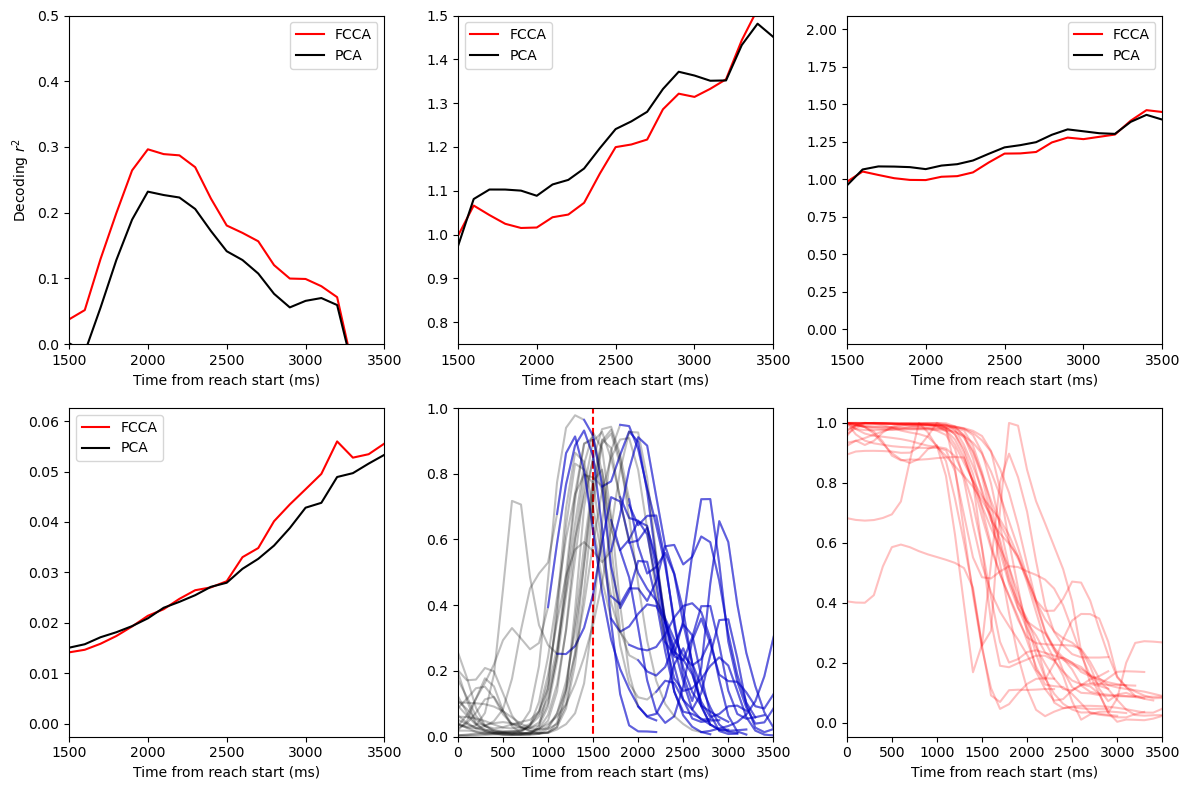

In [49]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8))

ax[0, 0].plot(wr2[:, 1, 4], color='r', label='FCCA')
ax[0, 0].plot(wr2[:, 0, 4], color='k', label='PCA')
ax[0, 0].legend()
ax[0, 0].set_ylim([0, 0.5])b
ax[1, 0].plot(np.linalg.norm(var[:, 0, 2:4], axis=-1), color='k', label='PCA')
ax[1, 0].legend()

# Plot behavior so we know what's going on
# ax[0, 2].plot(ntr[:, 0, 0])
# ax[0, 2].set_ylabel('Number of Reaches in Test Set')

for j, k in enumerate(correction_reach):
    if j % 25 == 0:
        tt = transition_times[k]
        offset = offsets[k]

        # Expand the window centers to go back to the beginning of the reach
        t0 = tt[0] + window_centers[0]
        t1 = tt[0] + offset + window_centers[-1]
        t1 = min(t1, tt[1])
        t0 = int(t0)
        t1 = int(t1)

        z_ = dat['behavior'][t0:t1]
        vel_ = np.linalg.norm(np.diff(z_, axis=0), axis=1)
        vel_ /= np.max(vel_)

        # Distance to target
        z_ = np.linalg.norm(z_ - dat['target_pairs'][k][1], axis=1)
        
        # Color velocity by first peak and second peak
        
        # Smooth the time series prior to plotting
        vel_ = scipy.ndimage.gaussian_filter1d(vel_, sigma=1)

        ax[1, 1].plot(np.arange(-offset, t1 - t0 - offset - 1), vel_, 'k', alpha=0.25)
        sidx = np.argwhere(np.diff(pkassign[k]))[0][0]
        ax[1, 1].plot(np.arange(vel_.size)[sidx - window_centers[0]:] , vel_[sidx - window_centers[0]:], 'b', alpha=0.5)

        ax[1, 2].plot(np.arange(-offset, t1 - t0 - offset), z_/np.max(z_), 'r', alpha=0.25)

for i in range(6):
    a = ax[np.unravel_index(i, (2, 3))]
    a.set_xlim(15, 35)
    a.set_xticks([15, 20, 25, 30, 35])
    a.set_xticklabels([1500, 2000, 2500, 3000, 3500])
    a.set_xlabel('Time from reach start (ms)')

ax[1, 1].set_xlim(0, 35)
ax[1, 1].set_xticks([0, 5, 10, 15, 20, 25, 30, 35])
ax[1, 1].set_xticklabels([0, 500, 1000, 1500, 2000, 2500, 3000, 3500])
ax[1, 1].vlines(15, -1, 2, color='r', linestyles='--')
ax[1, 1].set_ylim([0, 1])

ax[1, 2].set_xlim(0, 35)
ax[1, 2].set_xticks([0, 5, 10, 15, 20, 25, 30, 35])
ax[1, 2].set_xticklabels([0, 500, 1000, 1500, 2000, 2500, 3000, 3500])

fig.tight_layout()


In [ ]:
# Final visualization: (1) Single phase vs. dual phase reaches and the resulting velocity profiles. 
# MSE difference
# Reaches with bias variance of predictions co-plotted

In [ ]:
# For maximum visual contrast, identify those single peak reaches with the

In [306]:
straight_dev_order

array([ 505,  624, 1053, ..., 1297, 1368, 1345])

In [340]:
len(correction_reach)

540

In [339]:
len(straight_reach)

1556

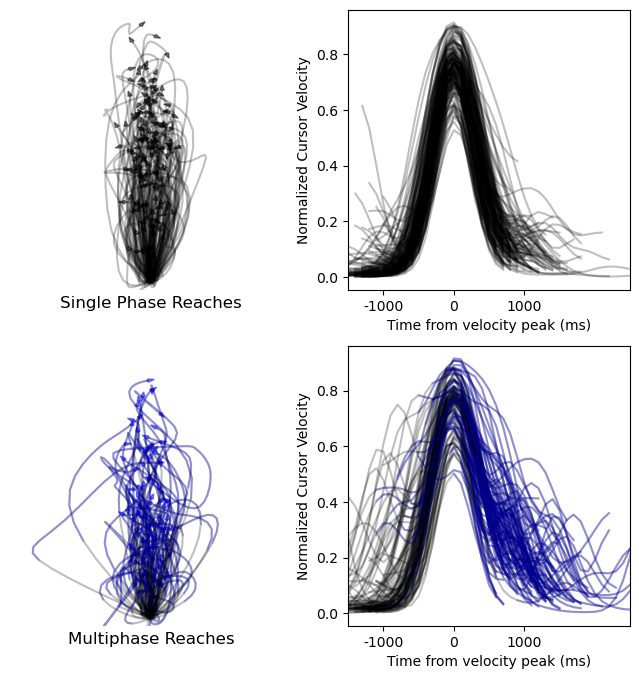

In [25]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))

# straight_dev_straight_reach = np.array(dat['straight_dev'])[straight_reach]
# straight_dev_order = np.argsort(straight_dev_straight_reach)[::-1]

for j in np.array(straight_reach)[0::10]:         
    tt = transition_times[j]
    # If the teach contains a secondary peak in dt accompanied by a dip in velocity, plot it
    z = dat['behavior'][tt[0]:tt[1], :]

    trajectory = rotate_reach(z, dat['target_pairs'][j], np.pi/2)
    ax[0, 0].plot(trajectory[:, 0], trajectory[:, 1], 'k', alpha=0.25)
    ax[0, 0].arrow(trajectory[-1,0], trajectory[-1, 1], 
                trajectory[-1, 0] - trajectory[-2, 0], trajectory[-1, 1] - trajectory[-2, 1], 
                head_width=2, color="k", alpha=0.5)

    vel_ = np.linalg.norm(np.diff(z, axis=0), axis=1)
    vel_ /= np.max(vel_)

    # Distance to target
    z_ = np.linalg.norm(z - dat['target_pairs'][j][1], axis=1)
    z_ /= np.max(z_)
    # Smooth the time series prior to plotting
    vel_ = scipy.ndimage.gaussian_filter1d(vel_, sigma=2)
    z_ = scipy.ndimage.gaussian_filter1d(z_, sigma=2)


    # Align to the peak
    vlpk_ = np.argmax(vel_)
    ax[0, 1].plot(np.arange(vel_.size) - vlpk_, vel_, 'k', alpha=0.25)

    # Align to steepest change
    #ax[0, 2].plot(np.arange(z_.size) - vlpk_, z_, 'k', alpha=0.25)

ax[0, 0].spines['top'].set_visible(False)
ax[0, 0].spines['right'].set_visible(False)
ax[0, 0].spines['bottom'].set_visible(False)
ax[0, 0].spines['left'].set_visible(False)

ax[0, 0].set_xlim([-65, 65])
ax[0, 0].set_ylim([-5, 165])
ax[0, 0].set_xticks([])
ax[0, 0].set_yticks([])

ax[0, 1].set_xlim([-15, 25])
ax[0, 1].set_xticks([-10, 0, 10])
ax[0, 1].set_xticklabels([-1000, 0, 1000])
ax[0, 1].set_xlabel('Time from velocity peak (ms)')
ax[0, 1].set_ylabel('Normalized Cursor Velocity')

# ax[0, 2].set_xlim([-15, 25])
# ax[0, 2].set_xticks([-10, 0, 10])
# ax[0, 2].set_xticklabels([-1000, 0, 1000])
# ax[0, 2].set_xlabel('Time from velocity peak (ms)')
# ax[0, 2].set_ylabel('Normalized ' + r'$\Delta r$')

# straight_dev_creach = np.array(dat['straight_dev'])[correction_reach]
# straight_dev_order = np.argsort(straight_dev_creach)[::-1]

for j in np.array(correction_reach)[0::5]:         
    tt = transition_times[j]
    # If the teach contains a secondary peak in dt accompanied by a dip in velocity, plot it
    z = dat['behavior'][tt[0]:tt[1], :]

    trajectory = rotate_reach(z, dat['target_pairs'][j], np.pi/2)
    ax[1, 0].plot(trajectory[:, 0], trajectory[:, 1], 'k', alpha=0.25)
    
    sidx = np.argwhere(np.diff(pkassign[j]))[0][0]
    ax[1, 0].plot(trajectory[sidx:, 0], trajectory[sidx:, 1], 'b', alpha=0.25)

    ax[1, 0].arrow(trajectory[-1, 0], trajectory[-1, 1], 
                trajectory[-1, 0] - trajectory[-2, 0], trajectory[-1, 1] - trajectory[-2, 1], 
                head_width=2, color="b", alpha=0.5)

    vel_ = np.linalg.norm(np.diff(z, axis=0), axis=1)
    vel_ /= np.max(vel_)

    # Distance to target
    z_ = np.linalg.norm(z - dat['target_pairs'][j][1], axis=1)
    z_ /= np.max(z_)
    # Smooth the time series prior to plotting
    vel_ = scipy.ndimage.gaussian_filter1d(vel_, sigma=2)
    z_ = scipy.ndimage.gaussian_filter1d(z_, sigma=2)

    # Align to the peak
    vlpk_ = np.argmax(vel_)
    ax[1, 1].plot(np.arange(vel_.size) - vlpk_, vel_, 'k', alpha=0.25)

    sidx = np.argwhere(np.diff(pkassign[j]))[0][0]
    ax[1, 1].plot(np.arange(vel_.size)[sidx:] - vlpk_, vel_[sidx:], 'b', alpha=0.25)

    #ax[1, 2].plot(np.arange(z_.size) - vlpk_, z_, 'k', alpha=0.25)


ax[0, 0].set_xlabel('Single Phase Reaches', fontsize=12)
ax[1, 0].set_xlabel('Multiphase Reaches', fontsize=12)


ax[1, 0].spines['top'].set_visible(False)
ax[1, 0].spines['right'].set_visible(False)
ax[1, 0].spines['bottom'].set_visible(False)
ax[1, 0].spines['left'].set_visible(False)

ax[1, 0].set_xlim([-65, 65])
ax[1, 0].set_ylim([-5, 165])
ax[1, 0].set_xticks([])
ax[1, 0].set_yticks([])
ax[1, 0].set_xticks([])
ax[1, 0].set_yticks([])



ax[1, 1].set_xlim([-15, 25])
ax[1, 1].set_xticks([-10, 0, 10])
ax[1, 1].set_xticklabels([-1000, 0, 1000])
ax[1, 1].set_xlabel('Time from velocity peak (ms)')
ax[1, 1].set_ylabel('Normalized Cursor Velocity')

# ax[1, 2].set_xlim([-15, 25])
# ax[1, 2].set_xticks([-10, 0, 10])
# ax[1, 2].set_xticklabels([-1000, 0, 1000])
# ax[1, 2].set_xlabel('Time from velocity peak (ms)')
# ax[1, 2].set_ylabel('Normalized ' + r'$\Delta r$')

fig.savefig('/home/akumar/nse/neural_control/figs/decodingbias/reach_examples3.pdf')

### BVT

In [29]:
with open('/mnt/Secondary/data/postprocessed/indy_dimreduc_nocv.dat', 'rb') as f:
    indy_df = pickle.load(f)
for f in indy_df:
    f['data_file'] = f['data_file'].split('/')[-1]

indy_df = pd.DataFrame(indy_df)


with open('/mnt/Secondary/data/postprocessed/loco_dimreduc_nocv_df.dat', 'rb') as f:
    loco_df = pickle.load(f)
loco_df = pd.DataFrame(loco_df)
good_loco_files = ['loco_20170210_03.mat',
'loco_20170213_02.mat',
'loco_20170215_02.mat',
'loco_20170227_04.mat',
'loco_20170228_02.mat',
'loco_20170301_05.mat',
'loco_20170302_02.mat']

loco_df = apply_df_filters(loco_df, data_file=good_loco_files,   
                            loader_args={'bin_width': 50, 'filter_fn': 'none', 'filter_kwargs': {}, 'boxcox': 0.5, 'spike_threshold': 100, 'region': 'M1'})

sabes_df = pd.concat([indy_df, loco_df])

data_files = np.unique(sabes_df['data_file'].values)

In [54]:
# with open('/mnt/Secondary/data/postprocessed/indy_dimreduc_nocv.dat', 'rb') as f:
#     rl = pickle.load(f)
# sabes_df = pd.DataFrame(rl)

# data_idx = 0
# data_file = np.unique(sabes_df['data_file'].values)[data_idx]

# dat = load_sabes(data_file)
# dat = reach_segment_sabes(dat, start_times[data_file.split('/')[-1].split('.mat')[0]])

fls = glob('/home/akumar/nse/neural_control/data/biasvariance_vst_norm/*.dat')
rl = []
for fl in fls:
    didx = int(fl.split('didx')[1].split('_')[0])
    with open(fl, 'rb') as f:
        bias = pickle.load(f)
        var = pickle.load(f)
        mse = pickle.load(f)
        wr2 = pickle.load(f)
        train_windows = pickle.load(f)
        windows = pickle.load(f)        
        offsets = pickle.load(f)
        # Skip dimval
        _ = pickle.load(f)
        ntr = pickle.load(f)

    result = {}
    result['didx'] = didx
    result['bias'] = bias
    result['var'] = var
    result['mse'] = mse
    result['r2'] = wr2
    result['windows'] = np.squeeze(windows)
    result['offsets'] = offsets
    result['ntr'] = ntr

    rl.append(result)

dvt_df = pd.DataFrame(rl)

In [55]:
# Create a new dataframe where we flatten across ranks
didxs = np.unique(dvt_df['didx'].values)
rl = []
for didx in didxs:
    d = apply_df_filters(dvt_df, didx=didx)
    result = {}

    windows = []
    bias = []
    var = []
    mse = []
    r2 = []
    ntr = []
    for j in range(d.shape[0]):
        windows.extend(d.iloc[j]['windows'])
        bias.append(d.iloc[j]['bias'])
        var.append(d.iloc[j]['var'])
        mse.append(d.iloc[j]['mse'])
        r2.append(d.iloc[j]['r2'])
        ntr.append(d.iloc[j]['ntr'])

    offsets = d.iloc[j]['offsets']
    
    window_centers = [np.nanmean(w) for w in windows]
    center_order = np.argsort(window_centers)
    windows = np.array(windows)[center_order]
    bias = np.concatenate(bias)[center_order]
    var = np.concatenate(var)[center_order]
    mse = np.concatenate(mse)[center_order]
    r2 = np.concatenate(r2)[center_order]
    ntr = np.concatenate(ntr, axis=0)[center_order]

    result['windows'] = windows
    result['didx'] = didx
    result['bias'] = bias
    result['var'] = var
    result['mse'] = mse
    result['r2'] = r2
    result['offsets'] = offsets
    result['ntr'] = ntr

    rl.append(result)

dvt_df = pd.DataFrame(rl)

In [32]:
# Assemble acceleration/velcocity of reaches across all recording sessions
vel_all = []
acc_all = []
vel_pk = []
acc_w1 = []
acc_w2 = []

for data_idx in tqdm(didxs):
    data_file = np.unique(sabes_df['data_file'].values)[data_idx]
    dat = load_sabes('/mnt/Secondary/data/sabes/%s' % data_file)
    dat = reach_segment_sabes(dat, data_file=data_file.split('/')[-1].split('.mat')[0])

    d = apply_df_filters(df_, didx=data_idx)
    # Intersection

    X = dat['spike_rates'].squeeze()
    Z = dat['behavior']

    Z, X = expand_state_space([Z], [X], True, True)
    X = X[0]
    Z = Z[0]

    transition_times = np.array(dat['transition_times'])
    transition_times = np.array([(t[0] - 2, t[1] - 2) for t in transition_times])

    # Shift all transition times by 2

    vel_all.append([])
    acc_all.append([])
    vel_pk.append([])
    acc_w1.append([])
    acc_w2.append([])
    
    for tt in transition_times:

        # Only include vel/acc for reaches of length at least 35
        if tt[1] - tt[0] > 35:
            vel = np.linalg.norm(Z[tt[0] - 5:tt[0] + 35, 2:4], axis=1)/(1e3 * 0.05)
            acc = np.linalg.norm(Z[tt[0] - 5:tt[0] + 35, 4:6], axis=1)/(1e3 * 0.05 * 0.05)
            vel_all[data_idx].append(vel)
            acc_all[data_idx].append(acc)

            # Find the peak of velocity, and the rising and falling shoulder of the acceleration
            vpk = np.argmax(vel)
            vel_pk[data_idx].append(vpk)
        else:
            continue           

  3%|▎         | 1/35 [00:11<06:46, 11.95s/it]

Reminder that start times depend on the bin size


  6%|▌         | 2/35 [00:27<07:50, 14.27s/it]

Reminder that start times depend on the bin size


  9%|▊         | 3/35 [00:31<04:57,  9.29s/it]

Reminder that start times depend on the bin size
Reminder that start times depend on the bin size


 14%|█▍        | 5/35 [01:02<06:15, 12.53s/it]

Reminder that start times depend on the bin size


 17%|█▋        | 6/35 [01:05<04:25,  9.15s/it]

Reminder that start times depend on the bin size


 20%|██        | 7/35 [01:07<03:15,  6.96s/it]

Reminder that start times depend on the bin size


 23%|██▎       | 8/35 [01:10<02:34,  5.72s/it]

Reminder that start times depend on the bin size


 26%|██▌       | 9/35 [01:13<02:04,  4.78s/it]

Reminder that start times depend on the bin size


 29%|██▊       | 10/35 [01:15<01:41,  4.07s/it]

Reminder that start times depend on the bin size


 31%|███▏      | 11/35 [01:19<01:32,  3.84s/it]

Reminder that start times depend on the bin size


 34%|███▍      | 12/35 [01:22<01:23,  3.65s/it]

Reminder that start times depend on the bin size


 37%|███▋      | 13/35 [01:26<01:25,  3.89s/it]

Reminder that start times depend on the bin size


 40%|████      | 14/35 [01:30<01:18,  3.75s/it]

Reminder that start times depend on the bin size


 43%|████▎     | 15/35 [01:33<01:12,  3.65s/it]

Reminder that start times depend on the bin size


 46%|████▌     | 16/35 [01:37<01:07,  3.53s/it]

Reminder that start times depend on the bin size


 49%|████▊     | 17/35 [01:40<01:01,  3.40s/it]

Reminder that start times depend on the bin size


 51%|█████▏    | 18/35 [01:43<00:57,  3.39s/it]

Reminder that start times depend on the bin size


 54%|█████▍    | 19/35 [01:46<00:53,  3.34s/it]

Reminder that start times depend on the bin size


 57%|█████▋    | 20/35 [01:50<00:52,  3.48s/it]

Reminder that start times depend on the bin size


 60%|██████    | 21/35 [01:55<00:54,  3.86s/it]

Reminder that start times depend on the bin size


 63%|██████▎   | 22/35 [01:58<00:46,  3.59s/it]

Reminder that start times depend on the bin size


 66%|██████▌   | 23/35 [02:01<00:43,  3.61s/it]

Reminder that start times depend on the bin size


 69%|██████▊   | 24/35 [02:05<00:40,  3.64s/it]

Reminder that start times depend on the bin size


 71%|███████▏  | 25/35 [02:09<00:37,  3.74s/it]

Reminder that start times depend on the bin size


 74%|███████▍  | 26/35 [02:13<00:33,  3.78s/it]

Reminder that start times depend on the bin size


 77%|███████▋  | 27/35 [02:18<00:32,  4.09s/it]

Reminder that start times depend on the bin size


 80%|████████  | 28/35 [02:23<00:31,  4.43s/it]

Reminder that start times depend on the bin size


 83%|████████▎ | 29/35 [02:34<00:38,  6.47s/it]

Reminder that start times depend on the bin size


 86%|████████▌ | 30/35 [02:50<00:45,  9.16s/it]

Reminder that start times depend on the bin size


 89%|████████▊ | 31/35 [02:57<00:34,  8.57s/it]

Reminder that start times depend on the bin size


 91%|█████████▏| 32/35 [03:10<00:29,  9.96s/it]

Reminder that start times depend on the bin size


 94%|█████████▍| 33/35 [03:22<00:20, 10.50s/it]

Reminder that start times depend on the bin size


 97%|█████████▋| 34/35 [03:29<00:09,  9.66s/it]

Reminder that start times depend on the bin size


100%|██████████| 35/35 [03:45<00:00,  6.43s/it]

Reminder that start times depend on the bin size


In [40]:
vall = np.array([np.mean(np.array(v), axis=0) for v in vel_all]).T

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


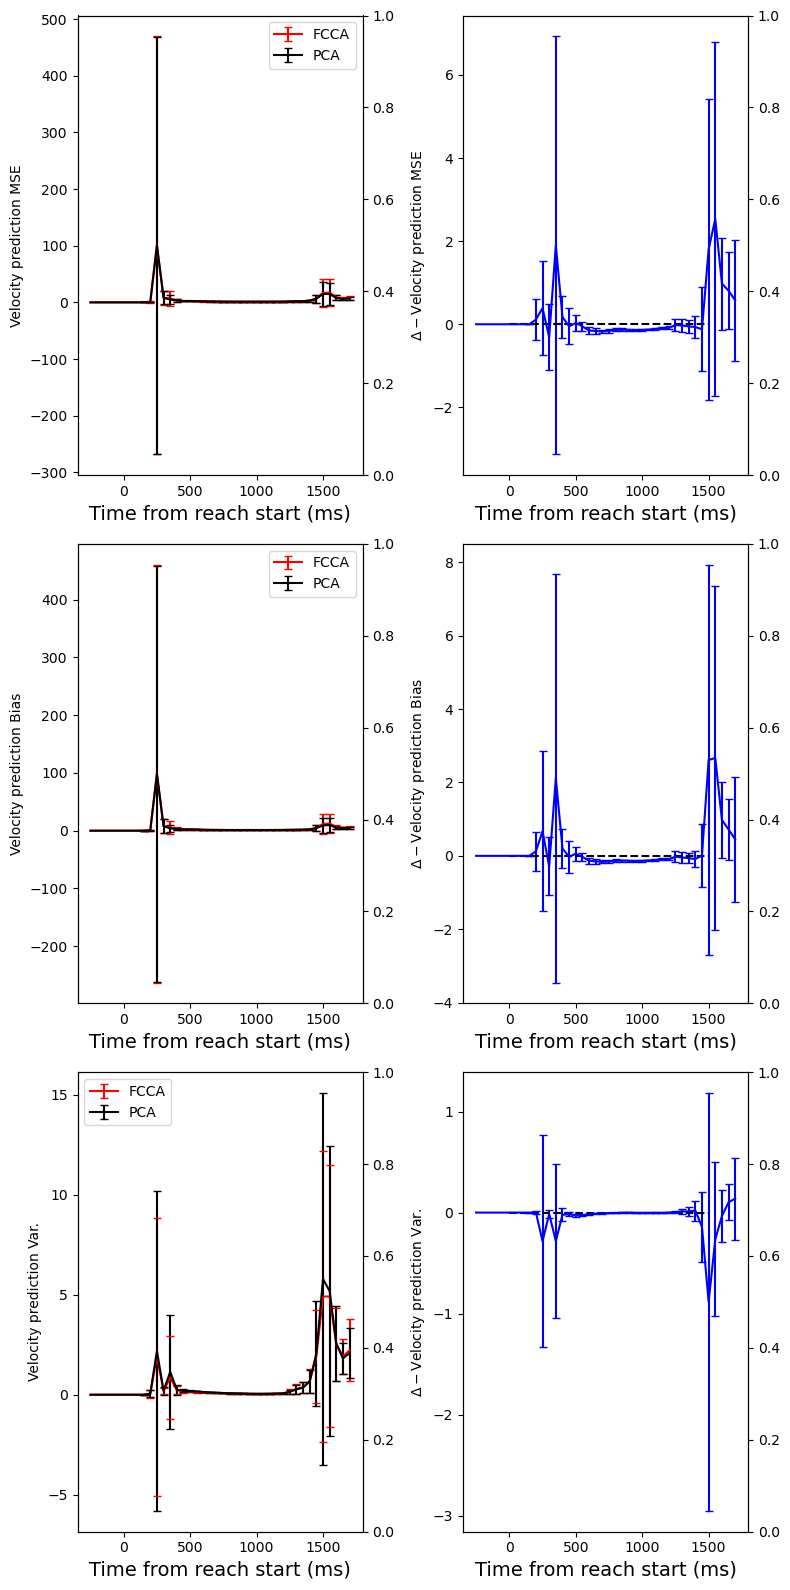

In [56]:
#fig, ax = plt.subplots(1, 3, figsize=(12, 4))
fig, ax = plt.subplots(3, 2, figsize=(8, 16))

a = [ax[j, 0].twinx() for j in range(3)]
a2 = [ax[j, 1].twinx() for j in range(3)]

df_ = dvt_df
windows = dvt_df.iloc[0]['windows']
window_centers = np.nanmean(windows, axis=1)

r2f = []
r2p = []

mse_f = []
mse_p = []

bias_f = []
bias_p = []

var_f = []
var_p = []

num_reaches = []


for j in range(df_.shape[0]):
    r2f.append(df_.iloc[j]['r2'][:, 1, 4])
    r2p.append(df_.iloc[j]['r2'][:, 0, 4])        

    mse_f.append(np.linalg.norm(df_.iloc[j]['mse'][:, 1, 2:4], axis=-1))
    mse_p.append(np.linalg.norm(df_.iloc[j]['mse'][:, 0, 2:4], axis=-1))        

    bias_f.append(np.linalg.norm(df_.iloc[j]['bias'][:, 1, 2:4], axis=-1))
    bias_p.append(np.linalg.norm(df_.iloc[j]['bias'][:, 0, 2:4], axis=-1))        

    var_f.append(np.linalg.norm(df_.iloc[j]['var'][:, 1, 2:4], axis=-1))
    var_p.append(np.linalg.norm(df_.iloc[j]['var'][:, 0, 2:4], axis=-1))        

    num_reaches.append(np.max(dvt_df.iloc[j]['ntr'][:, 0, 0]))

num_reaches = np.array(num_reaches)
r2f = np.array(r2f).T
r2p = np.array(r2p).T

mse_f = np.array(mse_f).T
mse_p = np.array(mse_p).T

bias_f = np.array(bias_f).T
bias_p = np.array(bias_p).T

var_f = np.array(var_f).T
var_p = np.array(var_p).T

#oksess = np.argwhere(np.nanmin(r2f, axis=0) > -10).squeeze()
oksess = np.arange(35)

r2f = r2f[:, oksess]
r2p = r2p[:, oksess]
mse_f = mse_f[:, oksess]
mse_p = mse_p[:, oksess]

bias_f = bias_f[:, oksess]
bias_p = bias_p[:, oksess]

var_f = var_f[:, oksess]
var_p = var_p[:, oksess]

ax[0, 0].errorbar(50 * window_centers, [np.nansum(np.multiply(r, num_reaches))/np.sum(num_reaches) for r in mse_f], 
                  [np.nanstd(r) * np.sqrt(np.sum(num_reaches**2)/np.sum(num_reaches)**2) for r in mse_f], linestyle='-', capsize=3, color='r', zorder=0)
ax[0, 0].errorbar(50 * window_centers, [np.nansum(np.multiply(r, num_reaches))/np.sum(num_reaches) for r in mse_p], 
                  [np.nanstd(r) * np.sqrt(np.sum(num_reaches**2)/np.sum(num_reaches)**2) for r in mse_p], linestyle='-', capsize=3, color='k', zorder=0)
ax[0, 1].errorbar(50 * window_centers, [np.nansum(np.multiply((r1 - r2), num_reaches))/np.sum(num_reaches) for (r1, r2) in zip(mse_f, mse_p)], 
                [np.nanstd(r1 - r2) * np.sqrt(np.sum(num_reaches**2)/np.sum(num_reaches)**2) for (r1, r2) in zip(mse_f, mse_p)], linestyle='-', capsize=3, color='b')

# ax[0].plot(50 * window_centers, [np.nanmean(r) for r in mse_f], [np.nanstd(r)/np.sqrt(r.size) for r in mse_f], e='', capsize=3, color='r', zorder=0)
# ax[0].plot(50 * window_centers, [np.nanmean(r) for r in mse_p], [np.nanstd(r)/np.sqrt(r.size) for r in mse_p], linestyle='', capsize=3, color='k', zorder=0)


# ax[0].plot(50 * window_centers, [np.nanmean(r) for r in r2f], '-o', color='r', zorder=0, label='FCCA')
# ax[0].plot(50 * window_centers, [np.nanmean(r) for r in r2p], '-o', color='k', zorder=0, label='PCA')

ax[1, 0].errorbar(50 * window_centers, [np.nansum(np.multiply(r, num_reaches))/np.sum(num_reaches) for r in bias_f], 
                  [np.nanstd(r) * np.sqrt(np.sum(num_reaches**2)/np.sum(num_reaches)**2) for r in bias_f], linestyle='-', capsize=3, color='r', zorder=0)
ax[1, 0].errorbar(50 * window_centers, [np.nansum(np.multiply(r, num_reaches))/np.sum(num_reaches) for r in bias_p], 
                  [np.nanstd(r) * np.sqrt(np.sum(num_reaches**2)/np.sum(num_reaches)**2) for r in bias_p], linestyle='-', capsize=3, color='k', zorder=0)
ax[1, 1].errorbar(50 * window_centers, [np.nansum(np.multiply((r1 - r2), num_reaches))/np.sum(num_reaches) for (r1, r2) in zip(bias_f, bias_p)], 
                [np.nanstd(r1 - r2) * np.sqrt(np.sum(num_reaches**2)/np.sum(num_reaches)**2) for (r1, r2) in zip(bias_f, bias_p)], linestyle='-', capsize=3, color='b')

ax[2, 0].errorbar(50 * window_centers, [np.nansum(np.multiply(r, num_reaches))/np.sum(num_reaches) for r in var_f], 
                  [np.nanstd(r) * np.sqrt(np.sum(num_reaches**2)/np.sum(num_reaches)**2) for r in var_f], linestyle='-', capsize=3, color='r', zorder=0)
ax[2, 0].errorbar(50 * window_centers, [np.nansum(np.multiply(r, num_reaches))/np.sum(num_reaches) for r in var_p], 
                  [np.nanstd(r) * np.sqrt(np.sum(num_reaches**2)/np.sum(num_reaches)**2) for r in var_p], linestyle='-', capsize=3, color='k', zorder=0)
ax[2, 1].errorbar(50 * window_centers, [np.nansum(np.multiply((r1 - r2), num_reaches))/np.sum(num_reaches) for (r1, r2) in zip(var_f, var_p)], 
                [np.nanstd(r1 - r2) * np.sqrt(np.sum(num_reaches**2)/np.sum(num_reaches)**2) for (r1, r2) in zip(var_f, var_p)], linestyle='-', capsize=3, color='b')

# ax[3, 0].errorbar(50 * window_centers, [np.nansum(np.multiply(r, num_reaches))/np.sum(num_reaches) for r in r2f], 
#                   [np.nanstd(r) * np.sqrt(np.sum(num_reaches**2)/np.sum(num_reaches)**2) for r in r2f], linestyle='-', capsize=3, color='r', zorder=0)
# ax[3, 0].errorbar(50 * window_centers, [np.nansum(np.multiply(r, num_reaches))/np.sum(num_reaches) for r in r2p], 
#                   [np.nanstd(r) * np.sqrt(np.sum(num_reaches**2)/np.sum(num_reaches)**2) for r in r2p], linestyle='-', capsize=3, color='k', zorder=0)
# ax[3, 1].errorbar(50 * window_centers, [np.nansum(np.multiply((r1 - r2), num_reaches))/np.sum(num_reaches) for (r1, r2) in zip(r2f, r2p)], 
#                 [np.nanstd(r1 - r2) * np.sqrt(np.sum(num_reaches**2)/np.sum(num_reaches)**2) for (r1, r2) in zip(r2f, r2p)], linestyle='-', capsize=3, color='b')

# ax[3, 0].set_ylim([0, 0.5])
# ax[3, 1].set_ylim([-0.2, 0.2])


for j in range(3):
    ax[j, 1].hlines(0, 0, 1500, linestyles='dashed', colors='k')

ax[0, 0].set_ylabel('Velocity prediction MSE')
ax[1, 0].set_ylabel('Velocity prediction Bias')
ax[2, 0].set_ylabel('Velocity prediction Var.')

ax[0, 1].set_ylabel(r'$\Delta-$' + 'Velocity prediction MSE')
ax[1, 1].set_ylabel(r'$\Delta-$' + 'Velocity prediction Bias')
ax[2, 1].set_ylabel(r'$\Delta-$' + 'Velocity prediction Var.')


# ax[0].set_ylabel('Vel. Decoding ' + r'$r^2$', fontsize=14)
# ax[1].set_ylabel(r'$\Delta$'  + ' Vel. Decoding ' + r'$r^2$', fontsize=14)

for j in range(3):
    ax[j, 0].set_xlabel('Time from reach start (ms)', fontsize=14)
    ax[j, 1].set_xlabel('Time from reach start (ms)', fontsize=14)
    ax[j, 0].legend(['FCCA', 'PCA'])

#ax[0, 0].set_ylim(0.5, 2)
#ax[0, 1].set_ylim(-0.2, 0.05)

#ax[1, 0].set_ylim(0.5, 2)
#ax[1, 1].set_ylim(-0.2, 0.05)

fig.tight_layout()
#fig.savefig('/home/akumar/nse/neural_control/figs/decodingbias/singlepktrain_multipeaktest.pdf', bbox_inches='tight', pad_inches=0)

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


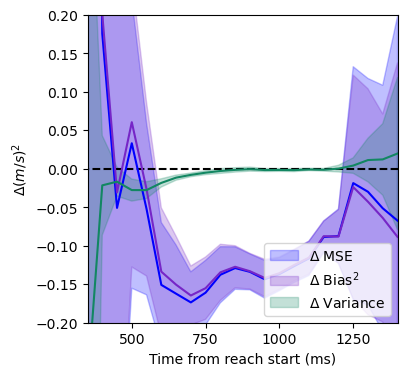

In [60]:
# Final visualization of delta MSE and the relative contribution of bias/variance
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

# Plot the MSE diff on a contracted xlimit and color by the 
range_idxs = np.arange(12, 34)

# ax.plot(50 * window_centers[range_idxs], np.array([np.nansum(np.multiply((r1 - r2), num_reaches))/np.sum(num_reaches) for (r1, r2) in zip(mse_f, mse_p)])[range_idxs]/(1e3 * 0.05), color='b')
# ax.fill_between(50 * window_centers[range_idxs], np.array([np.nansum(np.multiply((r1 - r2), num_reaches))/np.sum(num_reaches) for (r1, r2) in zip(mse_f, mse_p)])[range_idxs]/(1e3 * 0.05) + 
#                 np.array([np.nanstd(r1 - r2) * np.sqrt(np.sum(num_reaches**2)/np.sum(num_reaches)**2) for (r1, r2) in zip(mse_f, mse_p)])[range_idxs]/(1e3 * 0.05), 
#                 np.array([np.nansum(np.multiply((r1 - r2), num_reaches))/np.sum(num_reaches) for (r1, r2) in zip(mse_f, mse_p)])[range_idxs]/(1e3 * 0.05) - 
#                 np.array([np.nanstd(r1 - r2) * np.sqrt(np.sum(num_reaches**2)/np.sum(num_reaches)**2) for (r1, r2) in zip(mse_f, mse_p)])[range_idxs]/(1e3 * 0.05),                
#                 color='b', alpha=0.25, label=r'$\Delta$' + ' MSE')

# ax.plot(50 * window_centers[range_idxs], np.array([np.nansum(np.multiply((r1 - r2), num_reaches))/np.sum(num_reaches) for (r1, r2) in zip(bias_f, bias_p)])[range_idxs]/(1e3 * 0.05), color='#7626c7')
# ax.fill_between(50 * window_centers[range_idxs], np.array([np.nansum(np.multiply((r1 - r2), num_reaches))/np.sum(num_reaches) for (r1, r2) in zip(bias_f, bias_p)])[range_idxs]/(1e3 * 0.05) + 
#                 np.array([np.nanstd(r1 - r2) * np.sqrt(np.sum(num_reaches**2)/np.sum(num_reaches)**2) for (r1, r2) in zip(bias_f, bias_p)])[range_idxs]/(1e3 * 0.05), 
#                 np.array([np.nansum(np.multiply((r1 - r2), num_reaches))/np.sum(num_reaches) for (r1, r2) in zip(bias_f, bias_p)])[range_idxs]/(1e3 * 0.05) - 
#                 np.array([np.nanstd(r1 - r2) * np.sqrt(np.sum(num_reaches**2)/np.sum(num_reaches)**2) for (r1, r2) in zip(bias_f, bias_p)])[range_idxs]/(1e3 * 0.05),                
#                 color='#7626c7', alpha=0.25, label=r'$\Delta$' + ' Bias' + r'$^2$')

# ax.plot(50 * window_centers[range_idxs], np.array([np.nansum(np.multiply((r1 - r2), num_reaches))/np.sum(num_reaches) for (r1, r2) in zip(var_f, var_p)])[range_idxs]/(1e3 * 0.05), color='#128762')
# ax.fill_between(50 * window_centers[range_idxs], np.array([np.nansum(np.multiply((r1 - r2), num_reaches))/np.sum(num_reaches) for (r1, r2) in zip(var_f, var_p)])[range_idxs]/(1e3 * 0.05) + 
#                 np.array([np.nanstd(r1 - r2) * np.sqrt(np.sum(num_reaches**2)/np.sum(num_reaches)**2) for (r1, r2) in zip(var_f, var_p)])[range_idxs]/(1e3 * 0.05), 
#                 np.array([np.nansum(np.multiply((r1 - r2), num_reaches))/np.sum(num_reaches) for (r1, r2) in zip(var_f, var_p)])[range_idxs]/(1e3 * 0.05) - 
#                 np.array([np.nanstd(r1 - r2) * np.sqrt(np.sum(num_reaches**2)/np.sum(num_reaches)**2) for (r1, r2) in zip(var_f, var_p)])[range_idxs]/(1e3 * 0.05),                
#                 color='#128762', alpha=0.25, label=r'$\Delta$' + ' Variance')

ax.plot(50 * window_centers[range_idxs], np.array([np.nansum(np.multiply((r1 - r2), num_reaches))/np.sum(num_reaches) for (r1, r2) in zip(mse_f, mse_p)])[range_idxs], color='b')
ax.fill_between(50 * window_centers[range_idxs], np.array([np.nansum(np.multiply((r1 - r2), num_reaches))/np.sum(num_reaches) for (r1, r2) in zip(mse_f, mse_p)])[range_idxs] + 
                np.array([np.nanstd(r1 - r2) * np.sqrt(np.sum(num_reaches**2)/np.sum(num_reaches)**2) for (r1, r2) in zip(mse_f, mse_p)])[range_idxs], 
                np.array([np.nansum(np.multiply((r1 - r2), num_reaches))/np.sum(num_reaches) for (r1, r2) in zip(mse_f, mse_p)])[range_idxs] - 
                np.array([np.nanstd(r1 - r2) * np.sqrt(np.sum(num_reaches**2)/np.sum(num_reaches)**2) for (r1, r2) in zip(mse_f, mse_p)])[range_idxs],                
                color='b', alpha=0.25, label=r'$\Delta$' + ' MSE')

ax.plot(50 * window_centers[range_idxs], np.array([np.nansum(np.multiply((r1 - r2), num_reaches))/np.sum(num_reaches) for (r1, r2) in zip(bias_f, bias_p)])[range_idxs], color='#7626c7')
ax.fill_between(50 * window_centers[range_idxs], np.array([np.nansum(np.multiply((r1 - r2), num_reaches))/np.sum(num_reaches) for (r1, r2) in zip(bias_f, bias_p)])[range_idxs] + 
                np.array([np.nanstd(r1 - r2) * np.sqrt(np.sum(num_reaches**2)/np.sum(num_reaches)**2) for (r1, r2) in zip(bias_f, bias_p)])[range_idxs], 
                np.array([np.nansum(np.multiply((r1 - r2), num_reaches))/np.sum(num_reaches) for (r1, r2) in zip(bias_f, bias_p)])[range_idxs] - 
                np.array([np.nanstd(r1 - r2) * np.sqrt(np.sum(num_reaches**2)/np.sum(num_reaches)**2) for (r1, r2) in zip(bias_f, bias_p)])[range_idxs],                
                color='#7626c7', alpha=0.25, label=r'$\Delta$' + ' Bias' + r'$^2$')

ax.plot(50 * window_centers[range_idxs], np.array([np.nansum(np.multiply((r1 - r2), num_reaches))/np.sum(num_reaches) for (r1, r2) in zip(var_f, var_p)])[range_idxs], color='#128762')
ax.fill_between(50 * window_centers[range_idxs], np.array([np.nansum(np.multiply((r1 - r2), num_reaches))/np.sum(num_reaches) for (r1, r2) in zip(var_f, var_p)])[range_idxs] + 
                np.array([np.nanstd(r1 - r2) * np.sqrt(np.sum(num_reaches**2)/np.sum(num_reaches)**2) for (r1, r2) in zip(var_f, var_p)])[range_idxs], 
                np.array([np.nansum(np.multiply((r1 - r2), num_reaches))/np.sum(num_reaches) for (r1, r2) in zip(var_f, var_p)])[range_idxs] - 
                np.array([np.nanstd(r1 - r2) * np.sqrt(np.sum(num_reaches**2)/np.sum(num_reaches)**2) for (r1, r2) in zip(var_f, var_p)])[range_idxs],                
                color='#128762', alpha=0.25, label=r'$\Delta$' + ' Variance')


ax.hlines(0, 2000, 0, color='k', linestyles='--')
ax.set_xlim(50*window_centers[range_idxs][0], 50 * window_centers[range_idxs][-1])
ax.set_xticks([500, 750, 1000, 1250])
ax.set_xlabel('Time from reach start (ms)')
ax.set_ylabel(r'$\Delta(m/s)^2$')
ax.set_ylim([-0.2, 0.2])
#ax.set_yticks([-0.08, 0])

ax.legend(loc='lower right')
#fig.savefig('/home/akumar/nse/neural_control/figs/decodingbias/final1.pdf', bbox_inches='tight', pad_inhces=0)

In [ ]:
### Doing the same thing, but now looking at a train test split that only includes single phase reaches. 

In [62]:
# with open('/mnt/Secondary/data/postprocessed/indy_dimreduc_nocv.dat', 'rb') as f:
#     rl = pickle.load(f)
# sabes_df = pd.DataFrame(rl)

# data_idx = 0
# data_file = np.unique(sabes_df['data_file'].values)[data_idx]

# dat = load_sabes(data_file)
# dat = reach_segment_sabes(dat, start_times[data_file.split('/')[-1].split('.mat')[0]])

#fls = glob.glob('/home/akumar/nse/neural_control/data/biasvariance_vst6/*.dat')
fls = glob.glob('/home/akumar/nse/neural_control/data/biasvariance_vst_norm/*.dat')
rl = []
for fl in fls:
    didx = int(fl.split('didx')[1].split('_')[0])
    with open(fl, 'rb') as f:
        bias = pickle.load(f)
        var = pickle.load(f)
        mse = pickle.load(f)
        wr2 = pickle.load(f)
        train_windows = pickle.load(f)
        windows = pickle.load(f)        
        offsets = pickle.load(f)
        # Skip dimval
        _ = pickle.load(f)
        ntr = pickle.load(f)

    result = {}
    result['didx'] = didx
    result['bias'] = bias
    result['var'] = var
    result['mse'] = mse
    result['r2'] = wr2
    result['windows'] = np.squeeze(windows)
    result['offsets'] = offsets
    result['ntr'] = ntr

    rl.append(result)

dvt_df = pd.DataFrame(rl)

In [63]:
# Create a new dataframe where we flatten across ranks
didxs = np.unique(dvt_df['didx'].values)
rl = []
for didx in didxs:
    d = apply_df_filters(dvt_df, didx=didx)
    result = {}

    windows = []
    bias = []
    var = []
    mse = []
    r2 = []
    ntr = []
    for j in range(d.shape[0]):
        windows.extend(d.iloc[j]['windows'])
        bias.append(d.iloc[j]['bias'])
        var.append(d.iloc[j]['var'])
        mse.append(d.iloc[j]['mse'])
        r2.append(d.iloc[j]['r2'])
        ntr.append(d.iloc[j]['ntr'])

    offsets = d.iloc[j]['offsets']
    
    window_centers = [np.nanmean(w) for w in windows]
    center_order = np.argsort(window_centers)
    windows = np.array(windows)[center_order]
    bias = np.concatenate(bias)[center_order]
    var = np.concatenate(var)[center_order]
    mse = np.concatenate(mse)[center_order]
    r2 = np.concatenate(r2)[center_order]
    ntr = np.concatenate(ntr, axis=0)[center_order]

    result['windows'] = windows
    result['didx'] = didx
    result['bias'] = bias
    result['var'] = var
    result['mse'] = mse
    result['r2'] = r2
    result['offsets'] = offsets
    result['ntr'] = ntr

    rl.append(result)

dvt_df = pd.DataFrame(rl)

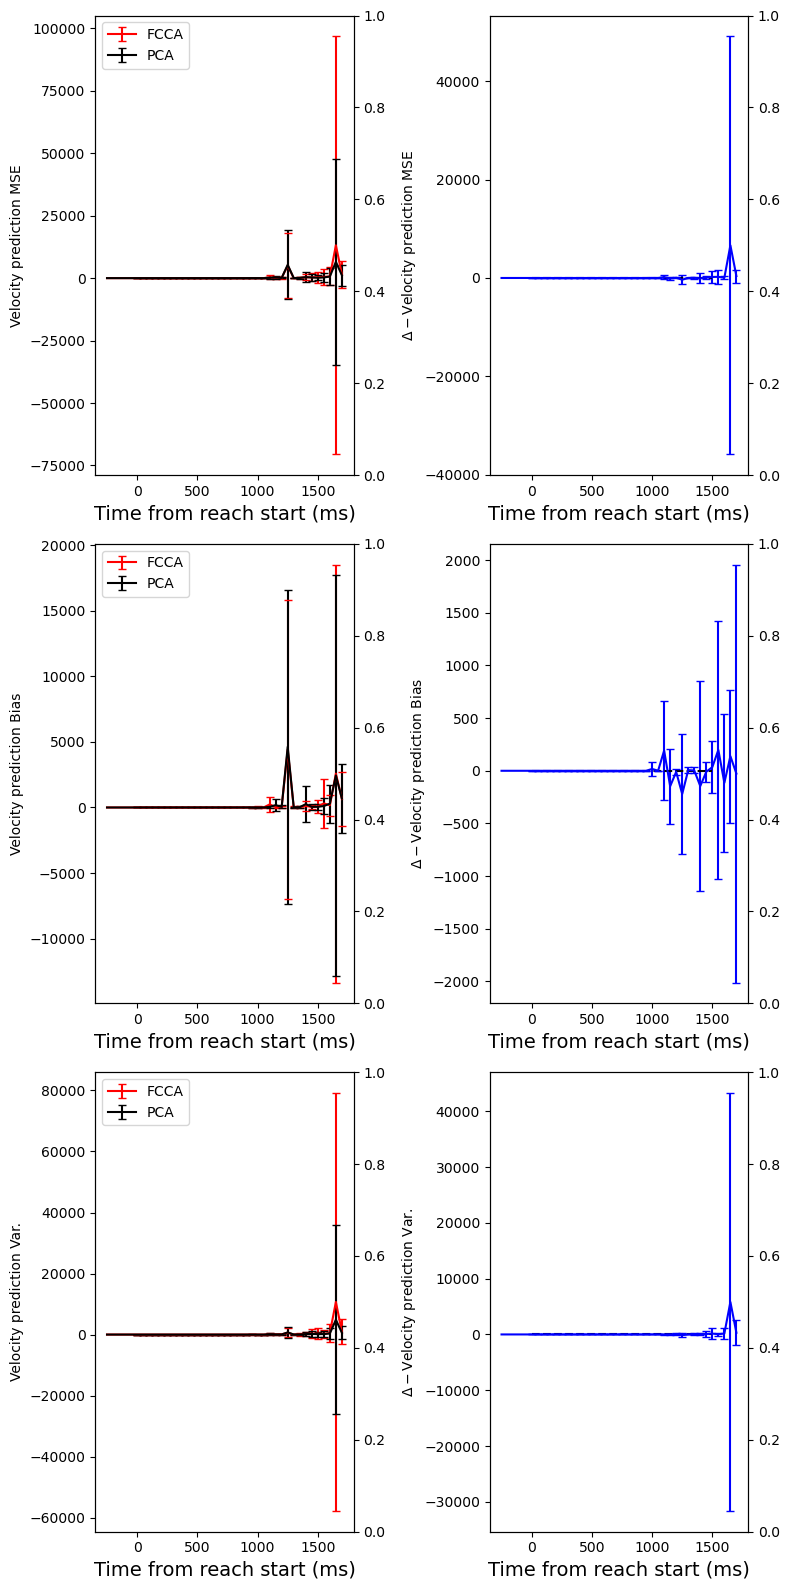

In [61]:
#fig, ax = plt.subplots(1, 3, figsize=(12, 4))
fig, ax = plt.subplots(3, 2, figsize=(8, 16))

a = [ax[j, 0].twinx() for j in range(3)]
a2 = [ax[j, 1].twinx() for j in range(3)]

df_ = dvt_df
windows = dvt_df.iloc[0]['windows']
window_centers = np.nanmean(windows, axis=1)

r2f = []
r2p = []

mse_f = []
mse_p = []

bias_f = []
bias_p = []

var_f = []
var_p = []

num_reaches = []

for j in range(df_.shape[0]):
    r2f.append(df_.iloc[j]['r2'][:, 7, 4])
    r2p.append(df_.iloc[j]['r2'][:, 6, 4])        

    mse_f.append(np.linalg.norm(df_.iloc[j]['mse'][:, 7, 2:4], axis=-1))
    mse_p.append(np.linalg.norm(df_.iloc[j]['mse'][:, 6, 2:4], axis=-1))        

    bias_f.append(np.linalg.norm(df_.iloc[j]['bias'][:, 7, 2:4], axis=-1))
    bias_p.append(np.linalg.norm(df_.iloc[j]['bias'][:, 6, 2:4], axis=-1))        

    var_f.append(np.linalg.norm(df_.iloc[j]['var'][:, 7, 2:4], axis=-1))
    var_p.append(np.linalg.norm(df_.iloc[j]['var'][:, 6, 2:4], axis=-1))        

    num_reaches.append(np.max(dvt_df.iloc[j]['ntr'][:, 0, 0]))

num_reaches = np.array(num_reaches)
r2f = np.array(r2f).T
r2p = np.array(r2p).T

mse_f = np.array(mse_f).T
mse_p = np.array(mse_p).T

bias_f = np.array(bias_f).T
bias_p = np.array(bias_p).T

var_f = np.array(var_f).T
var_p = np.array(var_p).T

#oksess = np.argwhere(np.nanmin(r2f, axis=0) > -10).squeeze()
oksess = np.arange(35)

r2f = r2f[:, oksess]
r2p = r2p[:, oksess]
mse_f = mse_f[:, oksess]
mse_p = mse_p[:, oksess]

bias_f = bias_f[:, oksess]
bias_p = bias_p[:, oksess]

var_f = var_f[:, oksess]
var_p = var_p[:, oksess]

ax[0, 0].errorbar(50 * window_centers, [np.nansum(np.multiply(r, num_reaches))/np.sum(num_reaches) for r in mse_f], 
                  [np.nanstd(r) * np.sqrt(np.sum(num_reaches**2)/np.sum(num_reaches)**2) for r in mse_f], linestyle='-', capsize=3, color='r', zorder=0)
ax[0, 0].errorbar(50 * window_centers, [np.nansum(np.multiply(r, num_reaches))/np.sum(num_reaches) for r in mse_p], 
                  [np.nanstd(r) * np.sqrt(np.sum(num_reaches**2)/np.sum(num_reaches)**2) for r in mse_p], linestyle='-', capsize=3, color='k', zorder=0)
ax[0, 1].errorbar(50 * window_centers, [np.nansum(np.multiply((r1 - r2), num_reaches))/np.sum(num_reaches) for (r1, r2) in zip(mse_f, mse_p)], 
                [np.nanstd(r1 - r2) * np.sqrt(np.sum(num_reaches**2)/np.sum(num_reaches)**2) for (r1, r2) in zip(mse_f, mse_p)], linestyle='-', capsize=3, color='b')

# ax[0].plot(50 * window_centers, [np.nanmean(r) for r in mse_f], [np.nanstd(r)/np.sqrt(r.size) for r in mse_f], e='', capsize=3, color='r', zorder=0)
# ax[0].plot(50 * window_centers, [np.nanmean(r) for r in mse_p], [np.nanstd(r)/np.sqrt(r.size) for r in mse_p], linestyle='', capsize=3, color='k', zorder=0)


# ax[0].plot(50 * window_centers, [np.nanmean(r) for r in r2f], '-o', color='r', zorder=0, label='FCCA')
# ax[0].plot(50 * window_centers, [np.nanmean(r) for r in r2p], '-o', color='k', zorder=0, label='PCA')

ax[1, 0].errorbar(50 * window_centers, [np.nansum(np.multiply(r, num_reaches))/np.sum(num_reaches) for r in bias_f], 
                  [np.nanstd(r) * np.sqrt(np.sum(num_reaches**2)/np.sum(num_reaches)**2) for r in bias_f], linestyle='-', capsize=3, color='r', zorder=0)
ax[1, 0].errorbar(50 * window_centers, [np.nansum(np.multiply(r, num_reaches))/np.sum(num_reaches) for r in bias_p], 
                  [np.nanstd(r) * np.sqrt(np.sum(num_reaches**2)/np.sum(num_reaches)**2) for r in bias_p], linestyle='-', capsize=3, color='k', zorder=0)
ax[1, 1].errorbar(50 * window_centers, [np.nansum(np.multiply((r1 - r2), num_reaches))/np.sum(num_reaches) for (r1, r2) in zip(bias_f, bias_p)], 
                [np.nanstd(r1 - r2) * np.sqrt(np.sum(num_reaches**2)/np.sum(num_reaches)**2) for (r1, r2) in zip(bias_f, bias_p)], linestyle='-', capsize=3, color='b')

ax[2, 0].errorbar(50 * window_centers, [np.nansum(np.multiply(r, num_reaches))/np.sum(num_reaches) for r in var_f], 
                  [np.nanstd(r) * np.sqrt(np.sum(num_reaches**2)/np.sum(num_reaches)**2) for r in var_f], linestyle='-', capsize=3, color='r', zorder=0)
ax[2, 0].errorbar(50 * window_centers, [np.nansum(np.multiply(r, num_reaches))/np.sum(num_reaches) for r in var_p], 
                  [np.nanstd(r) * np.sqrt(np.sum(num_reaches**2)/np.sum(num_reaches)**2) for r in var_p], linestyle='-', capsize=3, color='k', zorder=0)
ax[2, 1].errorbar(50 * window_centers, [np.nansum(np.multiply((r1 - r2), num_reaches))/np.sum(num_reaches) for (r1, r2) in zip(var_f, var_p)], 
                [np.nanstd(r1 - r2) * np.sqrt(np.sum(num_reaches**2)/np.sum(num_reaches)**2) for (r1, r2) in zip(var_f, var_p)], linestyle='-', capsize=3, color='b')

# ax[3, 0].errorbar(50 * window_centers, [np.nansum(np.multiply(r, num_reaches))/np.sum(num_reaches) for r in r2f], 
#                   [np.nanstd(r) * np.sqrt(np.sum(num_reaches**2)/np.sum(num_reaches)**2) for r in r2f], linestyle='-', capsize=3, color='r', zorder=0)
# ax[3, 0].errorbar(50 * window_centers, [np.nansum(np.multiply(r, num_reaches))/np.sum(num_reaches) for r in r2p], 
#                   [np.nanstd(r) * np.sqrt(np.sum(num_reaches**2)/np.sum(num_reaches)**2) for r in r2p], linestyle='-', capsize=3, color='k', zorder=0)
# ax[3, 1].errorbar(50 * window_centers, [np.nansum(np.multiply((r1 - r2), num_reaches))/np.sum(num_reaches) for (r1, r2) in zip(r2f, r2p)], 
#                 [np.nanstd(r1 - r2) * np.sqrt(np.sum(num_reaches**2)/np.sum(num_reaches)**2) for (r1, r2) in zip(r2f, r2p)], linestyle='-', capsize=3, color='b')

# ax[3, 0].set_ylim([0, 0.5])
# ax[3, 1].set_ylim([-0.2, 0.2])


for j in range(3):
    ax[j, 1].hlines(0, 0, 1500, linestyles='dashed', colors='k')

ax[0, 0].set_ylabel('Velocity prediction MSE')
ax[1, 0].set_ylabel('Velocity prediction Bias')
ax[2, 0].set_ylabel('Velocity prediction Var.')

ax[0, 1].set_ylabel(r'$\Delta-$' + 'Velocity prediction MSE')
ax[1, 1].set_ylabel(r'$\Delta-$' + 'Velocity prediction Bias')
ax[2, 1].set_ylabel(r'$\Delta-$' + 'Velocity prediction Var.')


# ax[0].set_ylabel('Vel. Decoding ' + r'$r^2$', fontsize=14)
# ax[1].set_ylabel(r'$\Delta$'  + ' Vel. Decoding ' + r'$r^2$', fontsize=14)

for j in range(3):
    ax[j, 0].set_xlabel('Time from reach start (ms)', fontsize=14)
    ax[j, 1].set_xlabel('Time from reach start (ms)', fontsize=14)
    ax[j, 0].legend(['FCCA', 'PCA'])
    #ax[j, 0].set_xlim([0, 1000])
    #ax[j, 1].set_xlim([0, 1000])

    #ax[j, 0].set_ylim([0, 100])
    #ax[j, 1].set_ylim([0, 1000])

#ax[0, 0].set_ylim(0.5, 2)
#ax[0, 1].set_ylim(-0.2, 0.05)

#ax[1, 0].set_ylim(0.5, 2)
#ax[1, 1].set_ylim(-0.2, 0.05)

fig.tight_layout()
#fig.savefig('/home/akumar/nse/neural_control/figs/decodingbias/singlepktrain_multipeaktest.pdf', bbox_inches='tight', pad_inches=0)

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


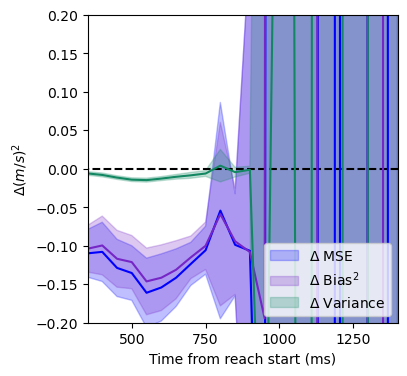

In [64]:
# Final visualization of delta MSE and the relative contribution of bias/variance
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

# Plot the MSE diff on a contracted xlimit and color by the 
range_idxs = np.arange(12, 34)

# ax.plot(50 * window_centers[range_idxs], np.array([np.nansum(np.multiply((r1 - r2), num_reaches))/np.sum(num_reaches) for (r1, r2) in zip(mse_f, mse_p)])[range_idxs]/(1e3 * 0.05), color='b')
# ax.fill_between(50 * window_centers[range_idxs], np.array([np.nansum(np.multiply((r1 - r2), num_reaches))/np.sum(num_reaches) for (r1, r2) in zip(mse_f, mse_p)])[range_idxs]/(1e3 * 0.05) + 
#                 np.array([np.nanstd(r1 - r2) * np.sqrt(np.sum(num_reaches**2)/np.sum(num_reaches)**2) for (r1, r2) in zip(mse_f, mse_p)])[range_idxs]/(1e3 * 0.05), 
#                 np.array([np.nansum(np.multiply((r1 - r2), num_reaches))/np.sum(num_reaches) for (r1, r2) in zip(mse_f, mse_p)])[range_idxs]/(1e3 * 0.05) - 
#                 np.array([np.nanstd(r1 - r2) * np.sqrt(np.sum(num_reaches**2)/np.sum(num_reaches)**2) for (r1, r2) in zip(mse_f, mse_p)])[range_idxs]/(1e3 * 0.05),                
#                 color='b', alpha=0.25, label=r'$\Delta$' + ' MSE')

# ax.plot(50 * window_centers[range_idxs], np.array([np.nansum(np.multiply((r1 - r2), num_reaches))/np.sum(num_reaches) for (r1, r2) in zip(bias_f, bias_p)])[range_idxs]/(1e3 * 0.05), color='#7626c7')
# ax.fill_between(50 * window_centers[range_idxs], np.array([np.nansum(np.multiply((r1 - r2), num_reaches))/np.sum(num_reaches) for (r1, r2) in zip(bias_f, bias_p)])[range_idxs]/(1e3 * 0.05) + 
#                 np.array([np.nanstd(r1 - r2) * np.sqrt(np.sum(num_reaches**2)/np.sum(num_reaches)**2) for (r1, r2) in zip(bias_f, bias_p)])[range_idxs]/(1e3 * 0.05), 
#                 np.array([np.nansum(np.multiply((r1 - r2), num_reaches))/np.sum(num_reaches) for (r1, r2) in zip(bias_f, bias_p)])[range_idxs]/(1e3 * 0.05) - 
#                 np.array([np.nanstd(r1 - r2) * np.sqrt(np.sum(num_reaches**2)/np.sum(num_reaches)**2) for (r1, r2) in zip(bias_f, bias_p)])[range_idxs]/(1e3 * 0.05),                
#                 color='#7626c7', alpha=0.25, label=r'$\Delta$' + ' Bias' + r'$^2$')

# ax.plot(50 * window_centers[range_idxs], np.array([np.nansum(np.multiply((r1 - r2), num_reaches))/np.sum(num_reaches) for (r1, r2) in zip(var_f, var_p)])[range_idxs]/(1e3 * 0.05), color='#128762')
# ax.fill_between(50 * window_centers[range_idxs], np.array([np.nansum(np.multiply((r1 - r2), num_reaches))/np.sum(num_reaches) for (r1, r2) in zip(var_f, var_p)])[range_idxs]/(1e3 * 0.05) + 
#                 np.array([np.nanstd(r1 - r2) * np.sqrt(np.sum(num_reaches**2)/np.sum(num_reaches)**2) for (r1, r2) in zip(var_f, var_p)])[range_idxs]/(1e3 * 0.05), 
#                 np.array([np.nansum(np.multiply((r1 - r2), num_reaches))/np.sum(num_reaches) for (r1, r2) in zip(var_f, var_p)])[range_idxs]/(1e3 * 0.05) - 
#                 np.array([np.nanstd(r1 - r2) * np.sqrt(np.sum(num_reaches**2)/np.sum(num_reaches)**2) for (r1, r2) in zip(var_f, var_p)])[range_idxs]/(1e3 * 0.05),                
#                 color='#128762', alpha=0.25, label=r'$\Delta$' + ' Variance')

ax.plot(50 * window_centers[range_idxs], np.array([np.nansum(np.multiply((r1 - r2), num_reaches))/np.sum(num_reaches) for (r1, r2) in zip(mse_f, mse_p)])[range_idxs], color='b')
ax.fill_between(50 * window_centers[range_idxs], np.array([np.nansum(np.multiply((r1 - r2), num_reaches))/np.sum(num_reaches) for (r1, r2) in zip(mse_f, mse_p)])[range_idxs] + 
                np.array([np.nanstd(r1 - r2) * np.sqrt(np.sum(num_reaches**2)/np.sum(num_reaches)**2) for (r1, r2) in zip(mse_f, mse_p)])[range_idxs], 
                np.array([np.nansum(np.multiply((r1 - r2), num_reaches))/np.sum(num_reaches) for (r1, r2) in zip(mse_f, mse_p)])[range_idxs] - 
                np.array([np.nanstd(r1 - r2) * np.sqrt(np.sum(num_reaches**2)/np.sum(num_reaches)**2) for (r1, r2) in zip(mse_f, mse_p)])[range_idxs],                
                color='b', alpha=0.25, label=r'$\Delta$' + ' MSE')

ax.plot(50 * window_centers[range_idxs], np.array([np.nansum(np.multiply((r1 - r2), num_reaches))/np.sum(num_reaches) for (r1, r2) in zip(bias_f, bias_p)])[range_idxs], color='#7626c7')
ax.fill_between(50 * window_centers[range_idxs], np.array([np.nansum(np.multiply((r1 - r2), num_reaches))/np.sum(num_reaches) for (r1, r2) in zip(bias_f, bias_p)])[range_idxs] + 
                np.array([np.nanstd(r1 - r2) * np.sqrt(np.sum(num_reaches**2)/np.sum(num_reaches)**2) for (r1, r2) in zip(bias_f, bias_p)])[range_idxs], 
                np.array([np.nansum(np.multiply((r1 - r2), num_reaches))/np.sum(num_reaches) for (r1, r2) in zip(bias_f, bias_p)])[range_idxs] - 
                np.array([np.nanstd(r1 - r2) * np.sqrt(np.sum(num_reaches**2)/np.sum(num_reaches)**2) for (r1, r2) in zip(bias_f, bias_p)])[range_idxs],                
                color='#7626c7', alpha=0.25, label=r'$\Delta$' + ' Bias' + r'$^2$')

ax.plot(50 * window_centers[range_idxs], np.array([np.nansum(np.multiply((r1 - r2), num_reaches))/np.sum(num_reaches) for (r1, r2) in zip(var_f, var_p)])[range_idxs], color='#128762')
ax.fill_between(50 * window_centers[range_idxs], np.array([np.nansum(np.multiply((r1 - r2), num_reaches))/np.sum(num_reaches) for (r1, r2) in zip(var_f, var_p)])[range_idxs] + 
                np.array([np.nanstd(r1 - r2) * np.sqrt(np.sum(num_reaches**2)/np.sum(num_reaches)**2) for (r1, r2) in zip(var_f, var_p)])[range_idxs], 
                np.array([np.nansum(np.multiply((r1 - r2), num_reaches))/np.sum(num_reaches) for (r1, r2) in zip(var_f, var_p)])[range_idxs] - 
                np.array([np.nanstd(r1 - r2) * np.sqrt(np.sum(num_reaches**2)/np.sum(num_reaches)**2) for (r1, r2) in zip(var_f, var_p)])[range_idxs],                
                color='#128762', alpha=0.25, label=r'$\Delta$' + ' Variance')

ax.hlines(0, 2000, 0, color='k', linestyles='--')
ax.set_xlim(50*window_centers[range_idxs][0], 50 * window_centers[range_idxs][-1])
ax.set_xticks([500, 750, 1000, 1250])
ax.set_xlabel('Time from reach start (ms)')
ax.set_ylabel(r'$\Delta(m/s)^2$')
ax.set_ylim([-0.2, 0.2])

ax.legend(loc='lower right')
#fig.savefig('/home/akumar/nse/neural_control/figs/decodingbias/straight_biasvar.pdf', bbox_inches='tight', pad_inhces=0)

In [11]:
# Using a standard train/test split (i.e. no straight/corrective distinction)
# # Cross-validated using the dimreduc fit on each fold
with open('/mnt/Secondary/data/postprocessed/indy_decoding_df2.dat', 'rb') as f:
    rl = pickle.load(f)
indy_df = pd.DataFrame(rl)

with open('/mnt/Secondary/data/postprocessed/loco_decoding_df.dat', 'rb') as f:
    loco_df = pickle.load(f)
loco_df = pd.DataFrame(loco_df)
loco_df = apply_df_filters(loco_df,
                        loader_args={'bin_width': 50, 'filter_fn': 'none', 'filter_kwargs': {}, 'boxcox': 0.5, 'spike_threshold': 100, 'region': 'M1'},
                        decoder_args={'trainlag': 4, 'testlag': 4, 'decoding_window': 5})
good_loco_files = ['loco_20170210_03.mat',
'loco_20170213_02.mat',
'loco_20170215_02.mat',
'loco_20170227_04.mat',
'loco_20170228_02.mat',
'loco_20170301_05.mat',
'loco_20170302_02.mat']

loco_df = apply_df_filters(loco_df, data_file=good_loco_files)        

sabes_df = pd.concat([indy_df, loco_df])

data_idx = 0
data_file = np.unique(sabes_df['data_file'].values)[data_idx]

dat = load_sabes('/mnt/Secondary/data/sabes/%s' % data_file)
dat = reach_segment_sabes(dat, data_file=data_file.split('/')[-1].split('.mat')[0])

fls = glob('/home/akumar/nse/neural_control/data/biasvariance_vst_all/*.dat')
rl = []
for fl in fls:
    didx = int(fl.split('didx')[1].split('_')[0])
    with open(fl, 'rb') as f:

        bias = pickle.load(f)
        var = pickle.load(f)
        mse = pickle.load(f)
        wr2 = pickle.load(f)
        train_windows = pickle.load(f)
        windows = pickle.load(f)        
        # Skip dimval
        _ = pickle.load(f)
        ntr = pickle.load(f)

    result = {}
    result['didx'] = didx
    result['bias'] = bias
    result['var'] = var
    result['mse'] = mse
    result['r2'] = wr2
    result['windows'] = np.squeeze(windows)
    result['ntr'] = ntr

    rl.append(result)

dvt_df = pd.DataFrame(rl)

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearRegression from version 0.24.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearRegression from version 0.24.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Reminder that start times depend on the bin size


/home/akumar/nse/neural_control/segmentation.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


In [13]:
# Create a new dataframe where we flatten across ranks
didxs = np.unique(dvt_df['didx'].values)
rl = []
for didx in didxs:
    d = apply_df_filters(dvt_df, didx=didx)
    result = {}

    windows = []
    bias = []
    var = []
    mse = []
    r2 = []
    ntr = []
    for j in range(d.shape[0]):
        windows.extend(d.iloc[j]['windows'])
        bias.append(d.iloc[j]['bias'])
        var.append(d.iloc[j]['var'])
        mse.append(d.iloc[j]['mse'])
        r2.append(d.iloc[j]['r2'])
        ntr.append(d.iloc[j]['ntr'])

    
    window_centers = [np.nanmean(w) for w in windows]
    center_order = np.argsort(window_centers)
    windows = np.array(windows)[center_order]
    bias = np.concatenate(bias)[center_order]
    var = np.concatenate(var)[center_order]
    mse = np.concatenate(mse)[center_order]
    r2 = np.concatenate(r2)[center_order]
    ntr = np.concatenate(ntr, axis=0)[center_order]

    result['windows'] = windows
    result['didx'] = didx
    result['bias'] = bias
    result['var'] = var
    result['mse'] = mse
    result['r2'] = r2
    result['ntr'] = ntr

    rl.append(result)

dvt_df = pd.DataFrame(rl)

In [14]:
dvt_df.iloc[0]['mse'].shape

(40, 2, 5, 6)

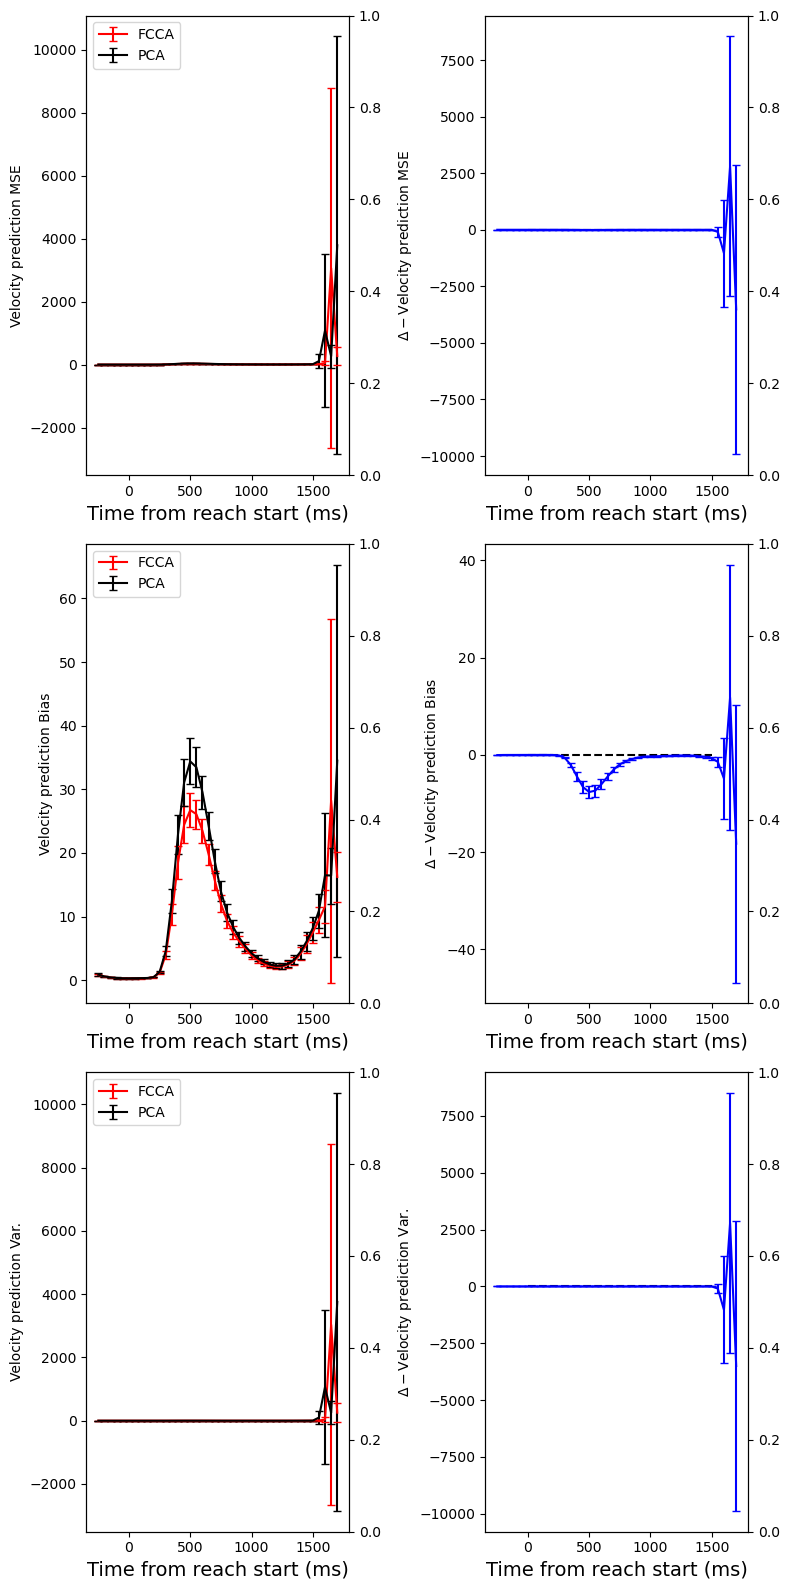

In [16]:
#fig, ax = plt.subplots(1, 3, figsize=(12, 4))
fig, ax = plt.subplots(3, 2, figsize=(8, 16))

a = [ax[j, 0].twinx() for j in range(3)]
a2 = [ax[j, 1].twinx() for j in range(3)]

df_ = dvt_df
windows = dvt_df.iloc[0]['windows']
window_centers = np.nanmean(windows, axis=1)

r2f = []
r2p = []

mse_f = []
mse_p = []

bias_f = []
bias_p = []

var_f = []
var_p = []

num_reaches = []

for j in range(df_.shape[0]):
    r2f.append(np.mean(df_.iloc[j]['r2'][:, 1, :, 4], axis=1))
    r2p.append(np.mean(df_.iloc[j]['r2'][:, 0, :, 4], axis=1))        

    mse_f.append(np.mean(np.linalg.norm(df_.iloc[j]['mse'][:, 1, :,  2:4], axis=-1), axis=1))
    mse_p.append(np.mean(np.linalg.norm(df_.iloc[j]['mse'][:, 0, :, 2:4], axis=-1), axis=1)) 

    bias_f.append(np.mean(np.linalg.norm(df_.iloc[j]['bias'][:, 1, :, 2:4], axis=-1), axis=1))
    bias_p.append(np.mean(np.linalg.norm(df_.iloc[j]['bias'][:, 0, :, 2:4], axis=-1), axis=1))

    var_f.append(np.mean(np.linalg.norm(df_.iloc[j]['var'][:, 1, :, 2:4], axis=-1), axis=1))
    var_p.append(np.mean(np.linalg.norm(df_.iloc[j]['var'][:, 0, :, 2:4], axis=-1), axis=1))        

    num_reaches.append(np.max(np.mean(dvt_df.iloc[j]['ntr'][:, 0, :, 0], axis=1)))

num_reaches = np.array(num_reaches)
r2f = np.array(r2f).T
r2p = np.array(r2p).T

mse_f = np.array(mse_f).T
mse_p = np.array(mse_p).T

bias_f = np.array(bias_f).T
bias_p = np.array(bias_p).T

var_f = np.array(var_f).T
var_p = np.array(var_p).T

#oksess = np.argwhere(np.nanmin(r2f, axis=0) > -10).squeeze()
oksess = np.arange(35)

r2f = r2f[:, oksess]
r2p = r2p[:, oksess]
mse_f = mse_f[:, oksess]
mse_p = mse_p[:, oksess]

bias_f = bias_f[:, oksess]
bias_p = bias_p[:, oksess]

var_f = var_f[:, oksess]
var_p = var_p[:, oksess]

ax[0, 0].errorbar(50 * window_centers, [np.nansum(np.multiply(r, num_reaches))/np.sum(num_reaches) for r in mse_f], 
                  [np.nanstd(r) * np.sqrt(np.sum(num_reaches**2)/np.sum(num_reaches)**2) for r in mse_f], linestyle='-', capsize=3, color='r', zorder=0)
ax[0, 0].errorbar(50 * window_centers, [np.nansum(np.multiply(r, num_reaches))/np.sum(num_reaches) for r in mse_p], 
                  [np.nanstd(r) * np.sqrt(np.sum(num_reaches**2)/np.sum(num_reaches)**2) for r in mse_p], linestyle='-', capsize=3, color='k', zorder=0)
ax[0, 1].errorbar(50 * window_centers, [np.nansum(np.multiply((r1 - r2), num_reaches))/np.sum(num_reaches) for (r1, r2) in zip(mse_f, mse_p)], 
                [np.nanstd(r1 - r2) * np.sqrt(np.sum(num_reaches**2)/np.sum(num_reaches)**2) for (r1, r2) in zip(mse_f, mse_p)], linestyle='-', capsize=3, color='b')

# ax[0].plot(50 * window_centers, [np.nanmean(r) for r in mse_f], [np.nanstd(r)/np.sqrt(r.size) for r in mse_f], e='', capsize=3, color='r', zorder=0)
# ax[0].plot(50 * window_centers, [np.nanmean(r) for r in mse_p], [np.nanstd(r)/np.sqrt(r.size) for r in mse_p], linestyle='', capsize=3, color='k', zorder=0)


# ax[0].plot(50 * window_centers, [np.nanmean(r) for r in r2f], '-o', color='r', zorder=0, label='FCCA')
# ax[0].plot(50 * window_centers, [np.nanmean(r) for r in r2p], '-o', color='k', zorder=0, label='PCA')

ax[1, 0].errorbar(50 * window_centers, [np.nansum(np.multiply(r, num_reaches))/np.sum(num_reaches) for r in bias_f], 
                  [np.nanstd(r) * np.sqrt(np.sum(num_reaches**2)/np.sum(num_reaches)**2) for r in bias_f], linestyle='-', capsize=3, color='r', zorder=0)
ax[1, 0].errorbar(50 * window_centers, [np.nansum(np.multiply(r, num_reaches))/np.sum(num_reaches) for r in bias_p], 
                  [np.nanstd(r) * np.sqrt(np.sum(num_reaches**2)/np.sum(num_reaches)**2) for r in bias_p], linestyle='-', capsize=3, color='k', zorder=0)
ax[1, 1].errorbar(50 * window_centers, [np.nansum(np.multiply((r1 - r2), num_reaches))/np.sum(num_reaches) for (r1, r2) in zip(bias_f, bias_p)], 
                [np.nanstd(r1 - r2) * np.sqrt(np.sum(num_reaches**2)/np.sum(num_reaches)**2) for (r1, r2) in zip(bias_f, bias_p)], linestyle='-', capsize=3, color='b')

ax[2, 0].errorbar(50 * window_centers, [np.nansum(np.multiply(r, num_reaches))/np.sum(num_reaches) for r in var_f], 
                  [np.nanstd(r) * np.sqrt(np.sum(num_reaches**2)/np.sum(num_reaches)**2) for r in var_f], linestyle='-', capsize=3, color='r', zorder=0)
ax[2, 0].errorbar(50 * window_centers, [np.nansum(np.multiply(r, num_reaches))/np.sum(num_reaches) for r in var_p], 
                  [np.nanstd(r) * np.sqrt(np.sum(num_reaches**2)/np.sum(num_reaches)**2) for r in var_p], linestyle='-', capsize=3, color='k', zorder=0)
ax[2, 1].errorbar(50 * window_centers, [np.nansum(np.multiply((r1 - r2), num_reaches))/np.sum(num_reaches) for (r1, r2) in zip(var_f, var_p)], 
                [np.nanstd(r1 - r2) * np.sqrt(np.sum(num_reaches**2)/np.sum(num_reaches)**2) for (r1, r2) in zip(var_f, var_p)], linestyle='-', capsize=3, color='b')

# ax[3, 0].errorbar(50 * window_centers, [np.nansum(np.multiply(r, num_reaches))/np.sum(num_reaches) for r in r2f], 
#                   [np.nanstd(r) * np.sqrt(np.sum(num_reaches**2)/np.sum(num_reaches)**2) for r in r2f], linestyle='-', capsize=3, color='r', zorder=0)
# ax[3, 0].errorbar(50 * window_centers, [np.nansum(np.multiply(r, num_reaches))/np.sum(num_reaches) for r in r2p], 
#                   [np.nanstd(r) * np.sqrt(np.sum(num_reaches**2)/np.sum(num_reaches)**2) for r in r2p], linestyle='-', capsize=3, color='k', zorder=0)
# ax[3, 1].errorbar(50 * window_centers, [np.nansum(np.multiply((r1 - r2), num_reaches))/np.sum(num_reaches) for (r1, r2) in zip(r2f, r2p)], 
#                 [np.nanstd(r1 - r2) * np.sqrt(np.sum(num_reaches**2)/np.sum(num_reaches)**2) for (r1, r2) in zip(r2f, r2p)], linestyle='-', capsize=3, color='b')

# ax[3, 0].set_ylim([0, 0.5])
# ax[3, 1].set_ylim([-0.2, 0.2])


for j in range(3):
    ax[j, 1].hlines(0, 0, 1500, linestyles='dashed', colors='k')

ax[0, 0].set_ylabel('Velocity prediction MSE')
ax[1, 0].set_ylabel('Velocity prediction Bias')
ax[2, 0].set_ylabel('Velocity prediction Var.')

ax[0, 1].set_ylabel(r'$\Delta-$' + 'Velocity prediction MSE')
ax[1, 1].set_ylabel(r'$\Delta-$' + 'Velocity prediction Bias')
ax[2, 1].set_ylabel(r'$\Delta-$' + 'Velocity prediction Var.')


# ax[0].set_ylabel('Vel. Decoding ' + r'$r^2$', fontsize=14)
# ax[1].set_ylabel(r'$\Delta$'  + ' Vel. Decoding ' + r'$r^2$', fontsize=14)

for j in range(3):
    ax[j, 0].set_xlabel('Time from reach start (ms)', fontsize=14)
    ax[j, 1].set_xlabel('Time from reach start (ms)', fontsize=14)
    ax[j, 0].legend(['FCCA', 'PCA'])
    #ax[j, 0].set_xlim([0, 1000])
    #ax[j, 1].set_xlim([0, 1000])

    #ax[j, 0].set_ylim([0, 100])
    #ax[j, 1].set_ylim([0, 1000])

#ax[0, 0].set_ylim(0.5, 2)
#ax[0, 1].set_ylim(-0.2, 0.05)

#ax[1, 0].set_ylim(0.5, 2)
#ax[1, 1].set_ylim(-0.2, 0.05)

fig.tight_layout()
#fig.savefig('/home/akumar/nse/neural_control/figs/decodingbias/singlepktrain_multipeaktest.pdf', bbox_inches='tight', pad_inches=0)

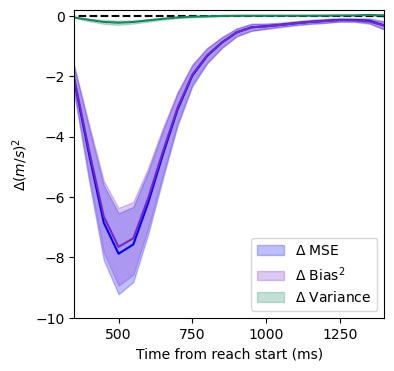

In [22]:
# Final visualization of delta MSE and the relative contribution of bias/variance
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

# Plot the MSE diff on a contracted xlimit and color by the 
range_idxs = np.arange(12, 34)

# ax.plot(50 * window_centers[range_idxs], np.array([np.nansum(np.multiply((r1 - r2), num_reaches))/np.sum(num_reaches) for (r1, r2) in zip(mse_f, mse_p)])[range_idxs]/(1e3 * 0.05), color='b')
# ax.fill_between(50 * window_centers[range_idxs], np.array([np.nansum(np.multiply((r1 - r2), num_reaches))/np.sum(num_reaches) for (r1, r2) in zip(mse_f, mse_p)])[range_idxs]/(1e3 * 0.05) + 
#                 np.array([np.nanstd(r1 - r2) * np.sqrt(np.sum(num_reaches**2)/np.sum(num_reaches)**2) for (r1, r2) in zip(mse_f, mse_p)])[range_idxs]/(1e3 * 0.05), 
#                 np.array([np.nansum(np.multiply((r1 - r2), num_reaches))/np.sum(num_reaches) for (r1, r2) in zip(mse_f, mse_p)])[range_idxs]/(1e3 * 0.05) - 
#                 np.array([np.nanstd(r1 - r2) * np.sqrt(np.sum(num_reaches**2)/np.sum(num_reaches)**2) for (r1, r2) in zip(mse_f, mse_p)])[range_idxs]/(1e3 * 0.05),                
#                 color='b', alpha=0.25, label=r'$\Delta$' + ' MSE')

# ax.plot(50 * window_centers[range_idxs], np.array([np.nansum(np.multiply((r1 - r2), num_reaches))/np.sum(num_reaches) for (r1, r2) in zip(bias_f, bias_p)])[range_idxs]/(1e3 * 0.05), color='#7626c7')
# ax.fill_between(50 * window_centers[range_idxs], np.array([np.nansum(np.multiply((r1 - r2), num_reaches))/np.sum(num_reaches) for (r1, r2) in zip(bias_f, bias_p)])[range_idxs]/(1e3 * 0.05) + 
#                 np.array([np.nanstd(r1 - r2) * np.sqrt(np.sum(num_reaches**2)/np.sum(num_reaches)**2) for (r1, r2) in zip(bias_f, bias_p)])[range_idxs]/(1e3 * 0.05), 
#                 np.array([np.nansum(np.multiply((r1 - r2), num_reaches))/np.sum(num_reaches) for (r1, r2) in zip(bias_f, bias_p)])[range_idxs]/(1e3 * 0.05) - 
#                 np.array([np.nanstd(r1 - r2) * np.sqrt(np.sum(num_reaches**2)/np.sum(num_reaches)**2) for (r1, r2) in zip(bias_f, bias_p)])[range_idxs]/(1e3 * 0.05),                
#                 color='#7626c7', alpha=0.25, label=r'$\Delta$' + ' Bias' + r'$^2$')

# ax.plot(50 * window_centers[range_idxs], np.array([np.nansum(np.multiply((r1 - r2), num_reaches))/np.sum(num_reaches) for (r1, r2) in zip(var_f, var_p)])[range_idxs]/(1e3 * 0.05), color='#128762')
# ax.fill_between(50 * window_centers[range_idxs], np.array([np.nansum(np.multiply((r1 - r2), num_reaches))/np.sum(num_reaches) for (r1, r2) in zip(var_f, var_p)])[range_idxs]/(1e3 * 0.05) + 
#                 np.array([np.nanstd(r1 - r2) * np.sqrt(np.sum(num_reaches**2)/np.sum(num_reaches)**2) for (r1, r2) in zip(var_f, var_p)])[range_idxs]/(1e3 * 0.05), 
#                 np.array([np.nansum(np.multiply((r1 - r2), num_reaches))/np.sum(num_reaches) for (r1, r2) in zip(var_f, var_p)])[range_idxs]/(1e3 * 0.05) - 
#                 np.array([np.nanstd(r1 - r2) * np.sqrt(np.sum(num_reaches**2)/np.sum(num_reaches)**2) for (r1, r2) in zip(var_f, var_p)])[range_idxs]/(1e3 * 0.05),                
#                 color='#128762', alpha=0.25, label=r'$\Delta$' + ' Variance')

ax.plot(50 * window_centers[range_idxs], np.array([np.nansum(np.multiply((r1 - r2), num_reaches))/np.sum(num_reaches) for (r1, r2) in zip(mse_f, mse_p)])[range_idxs], color='b')
ax.fill_between(50 * window_centers[range_idxs], np.array([np.nansum(np.multiply((r1 - r2), num_reaches))/np.sum(num_reaches) for (r1, r2) in zip(mse_f, mse_p)])[range_idxs] + 
                np.array([np.nanstd(r1 - r2) * np.sqrt(np.sum(num_reaches**2)/np.sum(num_reaches)**2) for (r1, r2) in zip(mse_f, mse_p)])[range_idxs], 
                np.array([np.nansum(np.multiply((r1 - r2), num_reaches))/np.sum(num_reaches) for (r1, r2) in zip(mse_f, mse_p)])[range_idxs] - 
                np.array([np.nanstd(r1 - r2) * np.sqrt(np.sum(num_reaches**2)/np.sum(num_reaches)**2) for (r1, r2) in zip(mse_f, mse_p)])[range_idxs],                
                color='b', alpha=0.25, label=r'$\Delta$' + ' MSE')

ax.plot(50 * window_centers[range_idxs], np.array([np.nansum(np.multiply((r1 - r2), num_reaches))/np.sum(num_reaches) for (r1, r2) in zip(bias_f, bias_p)])[range_idxs], color='#7626c7')
ax.fill_between(50 * window_centers[range_idxs], np.array([np.nansum(np.multiply((r1 - r2), num_reaches))/np.sum(num_reaches) for (r1, r2) in zip(bias_f, bias_p)])[range_idxs] + 
                np.array([np.nanstd(r1 - r2) * np.sqrt(np.sum(num_reaches**2)/np.sum(num_reaches)**2) for (r1, r2) in zip(bias_f, bias_p)])[range_idxs], 
                np.array([np.nansum(np.multiply((r1 - r2), num_reaches))/np.sum(num_reaches) for (r1, r2) in zip(bias_f, bias_p)])[range_idxs] - 
                np.array([np.nanstd(r1 - r2) * np.sqrt(np.sum(num_reaches**2)/np.sum(num_reaches)**2) for (r1, r2) in zip(bias_f, bias_p)])[range_idxs],                
                color='#7626c7', alpha=0.25, label=r'$\Delta$' + ' Bias' + r'$^2$')

ax.plot(50 * window_centers[range_idxs], np.array([np.nansum(np.multiply((r1 - r2), num_reaches))/np.sum(num_reaches) for (r1, r2) in zip(var_f, var_p)])[range_idxs], color='#128762')
ax.fill_between(50 * window_centers[range_idxs], np.array([np.nansum(np.multiply((r1 - r2), num_reaches))/np.sum(num_reaches) for (r1, r2) in zip(var_f, var_p)])[range_idxs] + 
                np.array([np.nanstd(r1 - r2) * np.sqrt(np.sum(num_reaches**2)/np.sum(num_reaches)**2) for (r1, r2) in zip(var_f, var_p)])[range_idxs], 
                np.array([np.nansum(np.multiply((r1 - r2), num_reaches))/np.sum(num_reaches) for (r1, r2) in zip(var_f, var_p)])[range_idxs] - 
                np.array([np.nanstd(r1 - r2) * np.sqrt(np.sum(num_reaches**2)/np.sum(num_reaches)**2) for (r1, r2) in zip(var_f, var_p)])[range_idxs],                
                color='#128762', alpha=0.25, label=r'$\Delta$' + ' Variance')

ax.hlines(0, 2000, 0, color='k', linestyles='--')
ax.set_xlim(50*window_centers[range_idxs][0], 50 * window_centers[range_idxs][-1])
ax.set_xticks([500, 750, 1000, 1250])
ax.set_xlabel('Time from reach start (ms)')
ax.set_ylabel(r'$\Delta(m/s)^2$')
ax.set_ylim([-10.0, 0.2])

ax.legend(loc='lower right')
fig.savefig('/home/akumar/nse/neural_control/figs/decodingbias/straight_biasvar.pdf', bbox_inches='tight', pad_inches=0)

### Bias/Variance Trajectory Visualization

In [40]:
# Test out what happens to bias variance depending on the definition of direct/corrective reaches here
with open('/mnt/Secondary/data/postprocessed/indy_dimreduc_nocv.dat', 'rb') as f:
    indy_df = pickle.load(f)
for f in indy_df:
    f['data_file'] = f['data_file'].split('/')[-1]

indy_df = pd.DataFrame(indy_df)


with open('/mnt/Secondary/data/postprocessed/loco_dimreduc_nocv_df.dat', 'rb') as f:
    loco_df = pickle.load(f)
loco_df = pd.DataFrame(loco_df)
good_loco_files = ['loco_20170210_03.mat',
'loco_20170213_02.mat',
'loco_20170215_02.mat',
'loco_20170227_04.mat',
'loco_20170228_02.mat',
'loco_20170301_05.mat',
'loco_20170302_02.mat']

loco_df = apply_df_filters(loco_df, data_file=good_loco_files,   
                            loader_args={'bin_width': 50, 'filter_fn': 'none', 'filter_kwargs': {}, 'boxcox': 0.5, 'spike_threshold': 100, 'region': 'M1'})

sabes_df = pd.concat([indy_df, loco_df])

In [41]:
# For a few trajectories in the correction category with high deviation from straight reaches, plot the trajectory, and then the velocity vectors
# as tangents along a few points 
data_path = '/mnt/Secondary/data/sabes'
data_files = np.unique(sabes_df['data_file'].values)
data_file = data_files[3]
dat = load_sabes('%s/%s' % (data_path, data_file))
# Note the lower error threshold
dat = reach_segment_sabes(dat, data_file=data_file.split('.mat')[0], err_thresh=0.9)

# This is the one we were using in trajectory visualization

Reminder that start times depend on the bin size


/home/akumar/nse/neural_control/segmentation.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


In [42]:
# Measure the distance from target
# Calculate 
# (1) The peaks in distance to target
# (2) troughs in velocity
# (3) Number of velocity peaks/velocity troughs
dt = []
vel = []
dtpks = []
dttrghs = []
veltr = []
velpks = []
dtpkw = []
velpkw = []

# Intersection

# We calculate velocity by using expand state space, and shift the transition times accordingly
Z, _ = expand_state_space([dat['behavior']], [dat['spike_rates'].squeeze()], True, True)
# Flatten list structure imposed by expand_state_space
Z = Z[0]

# Shift transition times by 2
transition_times = np.array([(t[0] - 2, t[1] - 2) for t in dat['transition_times']])
for j, tt in enumerate(transition_times):        
    target_loc = dat['target_pairs'][j][1]

    vel_ = np.linalg.norm(Z[tt[0]:tt[1], 2:4], axis=1)
    dt_ = np.linalg.norm(Z[tt[0]:tt[1], 0:2] - dat['target_pairs'][j][1], axis=1)

    vel.append(vel_)
    dt.append(dt_)
    
    pks, _ = scipy.signal.find_peaks(dt_/np.max(dt_), height=0.1, prominence=0.1)

    # Require that the peak comes after the maximum value
    pks = pks[pks > np.argmax(dt_)]
    # Require that we have gotten at least halfway to the target, but not too close
    if len(pks) > 0:
        if np.any((dt_/np.max(dt_))[:pks[0]] < 0.5) and not np.any((dt_/np.max(dt_))[:pks[0]] < 0.1):
            # Get the FWHM of the peak widths
            w, _, l, r = scipy.signal.peak_widths(dt_/np.max(dt_), [pks[0]], rel_height=0.5)
            dtpkw.append(int(np.floor(l[0])))
        else:
            pks = []
            dtpkw.append(np.nan)
    else:
        dtpkw.append(np.nan)

    trghs, _ = scipy.signal.find_peaks(-1*vel_/np.max(vel_), height=-0.5)
    
    dtpks.append(pks)
    veltr.append(trghs)

    pks, _ = scipy.signal.find_peaks(vel_/np.max(vel_), height=0.4, prominence=0.1)
    if len(pks) > 1:
        # Get the FWHM of the peak widths
        w, _, l, r = scipy.signal.peak_widths(vel_/np.max(vel_), [pks[1]], rel_height=0.0)
        velpkw.append(int(np.floor(l[0])))
    else:
        velpkw.append(np.nan)

    trghs, _ = scipy.signal.find_peaks(-1*dt_/np.max(dt_), height=-0.5)

    velpks.append(pks)
    dttrghs.append(trghs)

X = dat['spike_rates'].squeeze()

# Apply lag
X = X[lag:, :]
Z = Z[:-lag, :]

# Exclude any reaches that lie within +/- lag of the start/end of the session
too_soon = [j for j in range(len(transition_times)) if transition_times[j][0] < lag]
too_late = [j for j in range(len(transition_times)) if transition_times[j][1] > dat['behavior'].shape[0] - lag]

# Straight/Direct vs. Corrective reaches
# straight_reach = [idx for idx in range(len(dt)) if len(dtpks[idx]) == 0]
# correction_reach = [idx for idx in range(len(dt)) if len(dtpks[idx]) > 0]
straight_reach = [idx for idx in range(len(dt)) if len(velpks[idx]) == 1]
correction_reach = [idx for idx in range(len(dt)) if len(velpks[idx]) > 1]

for idx in too_soon:
    if idx in straight_reach:
        straight_reach.remove(idx)
    elif idx in correction_reach:
        correction_reach.remove(idx)
for idx in too_late:
    if idx in straight_reach:
        straight_reach.remove(idx)
    elif idx in correction_reach:
        correction_reach.remove(idx)

# Segment the corrective reaches by pre/post corrective movement
pkassign = get_peak_assignments_vel(vel)
#pkassign = get_peak_assignments(velocity_seg, dtpkw)


/tmp/ipykernel_7229/3255581567.py:57: PeakPropertyWarning: some peaks have a width of 0
  w, _, l, r = scipy.signal.peak_widths(vel_/np.max(vel_), [pks[1]], rel_height=0.0)
/tmp/ipykernel_7229/3061889107.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(pkassign)


In [43]:
# Rotate *clockwise* by theta
def Rot(theta):
 return np.array([[np.cos(-1*theta), -np.sin(-theta)], \
                  [np.sin(-theta), np.cos(theta)]])        

# Rotate reach to a common reference frame
def rotate_reach(z, trgt, th):
    trajectory = scipy.ndimage.gaussian_filter1d(z, sigma=2, axis=0)

    # Center trajectory
    trajectory -= trajectory[0]

    # Rotate trajectory so that the first 5 timesteps all go off at the same angle
    #theta0 = np.arctan2(trajectory[5, 1], trajectory[5, 0])

    # Rotate trajectory so that the target start to end target has common alignment
    xy = trgt[1] - trgt[0]
    theta0 = np.arctan2(xy[1], xy[0])

    trajectory = np.array([Rot(theta0 - th) @ t[0:2] for t in trajectory])

    return trajectory

# Given a smoothed, rotated trajectory, adjust the vectors defined by x, y, dx, dy so they lie
# along the trajectory
def adjust_vectors(z, zsmooth, x, y, dx, dy):

    # Find the index of x, y in z
    # xadj yadj is then just the corresponding values at index in zmooth
    # dx dy is obtained by applying the same linear transformation that maps (x, y) to (xadj yadj) to (dx, dy)

    xadj = np.zeros(len(x))
    yadj = np.zeros(len(y))
    dxadj = np.zeros(len(dx))
    dyadj = np.zeros(len(dy))

    for i in range(len(x)):

        idx = np.argwhere(np.bitwise_and(np.isclose(z[:, 0], x[i]), np.isclose(z[:, 1], y[i])))[0][0]
        xadj[i] = zsmooth[idx][0]
        yadj[i] = zsmooth[idx][1]

        # The new difference vector should be the new difference between idx and idx - 1. 
        # Find the rotation and scaling that is applied to this new tangent with respect to the 
        # old tangent and apply the same rotations and scalings to dx[i], dy[i]
        tan0 = z[idx] - z[idx - 1]
        tan1 = zsmooth[idx] - zsmooth[idx - 1]

        th = np.arccos(tan0/np.linalg.norm(tan0) @ tan1/np.linalg.norm(tan1))
        R = np.linalg.norm(tan1)/np.linalg.norm(tan0)

        # Since arccos will always be between 0 and pi, there is some ambiguity as to whether to rotate cw or ccw
        # The rule is that tan0 should be mapped to tan1. 
        if not np.allclose(R * Rot(th) @ tan0, tan1):
            th *= -1

        z0 = np.array([dx[i], dy[i]])
        z1 = R * Rot(th) @ z0
        dxadj[i] = z1[0]
        dyadj[i] = z1[1]

    return xadj, yadj, dxadj, dyadj


In [50]:
dimval = 6
dffca = apply_df_filters(sabes_df, data_file=data_file, dim=dimval, dimreduc_method='LQGCA')
dfpca = apply_df_filters(sabes_df, data_file=data_file, dim=dimval, dimreduc_method='PCA')

try:
    assert(dffca.shape[0] == 1)
    assert(dfpca.shape[0] == 1)
except:
    pdb.set_trace()        

coefpca = dfpca.iloc[0]['coef'][:, 0:dimval]
coeffcca = dffca.iloc[0]['coef'][:, 0:dimval]

In [93]:
# Sliding windows
window_width = 1
#window_centers = np.linspace(0, 35, 25)[0:9]
window_centers = np.arange(-5, 35)
win_min = window_centers[0]
# Pool together n decoding windows prior for training 
train_windows = [[(wc, wc + 1)] for wc in window_centers]
test_windows = train_windows
train_idxs = straight_reach
test_idxs = correction_reach

tt_train = [(t, idx) for idx, t in enumerate(transition_times) 
            if idx in train_idxs and t[0] > (lag + np.abs(win_min)) and t[1] < (Z.shape[0] - lag - np.abs(win_min))]
# Re-assign train idxs removing those reaches that were outside the start/end region
train_idxs = [x[1] for x in tt_train]
tt_train = [x[0] for x in tt_train]

offsets_train = None

# Filter out by transitions that lie within the test idxs, and stay clear of the start and end
tt_test = [(t, idx) for idx, t in enumerate(transition_times) 
            if idx in test_idxs and t[0] > (lag + np.abs(win_min)) and t[1] < (Z.shape[0] - lag - np.abs(win_min))]
# Re-assign test idxs removing those reaches that were outside the start/end region
test_idxs = [x[1] for x in tt_test]
tt_test = [x[0] for x in tt_test]
offsets_test = None

# Ultimately what we want
zpred_boot_fca = []
zpred_boot_pca = []

reach_idxs_pca = []
reach_idxs_fca = []

ztest = []

n_boots=200
rand = np.random.RandomState(seed=123)
for j, train_window in enumerate(train_windows):
    zpred_boot_fca.append([])
    zpred_boot_pca.append([])

    # Get trialized, windowed data
    ############### PCA

    Xtrain, Ztrain = apply_window(X @ coefpca, Z, lag, train_window, tt_train, decoding_window, False, False, offsets=offsets_train)
    assert(np.all([s.size == np.arange(t[0], t[1]).size for (s, t) in zip(pkassign[test_idxs], tt_test)]))
    subset_selection = [np.argwhere(np.array(s) != 0).squeeze() for s in pkassign[test_idxs]]
    Xtest, Ztest, rip = apply_window(X @ coefpca, Z, lag, test_windows[j], tt_test, decoding_window, False, False, subset_selection, offsets=offsets_test, return_valid_indices=True)

    reach_idxs_pca.append(rip)
    num_test_reaches = len(Xtest)
    print('nrt: %d' % num_test_reaches)
    # verify dimensionalities
    if len(Xtrain) > 0:
        Xtrain = np.concatenate(Xtrain)
        Ztrain = np.concatenate(Ztrain)
    else:
        continue

    if len(Xtest) > 0:
        Xtest = np.concatenate(Xtest)
        Ztest = np.concatenate(Ztest)
        Xtrain = StandardScaler().fit_transform(Xtrain)
        Ztrain = StandardScaler().fit_transform(Ztrain)
        Xtest = StandardScaler().fit_transform(Xtest)
        ztestscaler = StandardScaler()
        Ztest = ztestscaler.fit_transform(Ztest)

        # Run lr_decoder over bootstrapped samples of xtrain and xtest. Use this to calculate bias and variance of the estimator
        for k in range(n_boots):

            xboot, zboot = _draw_bootstrap_sample(rand, Xtrain, Ztrain)
            decodingregressor = LinearRegression(fit_intercept=True)
            decodingregressor.fit(xboot, zboot)
            zpred = decodingregressor.predict(Xtest)
            # Reverse scaling transformation
            zpred_boot_pca[j].append(ztestscaler.inverse_transform(zpred))

        #assert(np.allclose((np.array(zpred_boot_pca[j]) - Ztest).shape, np.array(zpred_boot_pca[j]).shape))

    ############### FCCA

    Xtrain, Ztrain = apply_window(X @ coeffcca, Z, lag, train_window, tt_train, decoding_window, False, False, offsets=offsets_train)
    assert(np.all([s.size == np.arange(t[0], t[1]).size for (s, t) in zip(pkassign[test_idxs], tt_test)]))
    subset_selection = [np.argwhere(np.array(s) != 0).squeeze() for s in pkassign[test_idxs]]
    Xtest, Ztest, rif = apply_window(X @ coeffcca, Z, lag, test_windows[j], tt_test, decoding_window, False, False, subset_selection, offsets=offsets_test, return_valid_indices=True)
    reach_idxs_fca.append(rif)


    num_test_reaches = len(Xtest)
    print('nrt: %d' % num_test_reaches)
    ztest.append(Ztest)

    # verify dimensionalities
    if len(Xtrain) > 0:
        Xtrain = np.concatenate(Xtrain)
        Ztrain = np.concatenate(Ztrain)
    else:
        continue

    if len(Xtest) > 0:
        Xtest = np.concatenate(Xtest)
        Ztest = np.concatenate(Ztest)

        Xtrain = StandardScaler().fit_transform(Xtrain)
        Ztrain = StandardScaler().fit_transform(Ztrain)
        Xtest = StandardScaler().fit_transform(Xtest)
        ztestscaler = StandardScaler()
        Ztest = ztestscaler.fit_transform(Ztest)

        # Run lr_decoder over bootstrapped samples of xtrain and xtest. Use this to calculate bias and variance of the estimator
        for k in range(n_boots):

            xboot, zboot = _draw_bootstrap_sample(rand, Xtrain, Ztrain)
            decodingregressor = LinearRegression(fit_intercept=True)
            decodingregressor.fit(xboot, zboot)
            zpred = decodingregressor.predict(Xtest)
            # Reverse scaling transformation
            zpred_boot_fca[j].append(ztestscaler.inverse_transform(zpred))

        #assert(np.allclose((np.array(zpred_boot_fca[j]) - Ztest).shape, np.array(zpred_boot_fca[j]).shape))


nrt: 0
nrt: 0
nrt: 0
nrt: 0
nrt: 0
nrt: 0
nrt: 0
nrt: 0
nrt: 0
nrt: 0
nrt: 0
nrt: 0
nrt: 0
nrt: 0
nrt: 0
nrt: 0
nrt: 1
nrt: 1
nrt: 2
nrt: 2
nrt: 5
nrt: 5
nrt: 13
nrt: 13
nrt: 22
nrt: 22
nrt: 36
nrt: 36
nrt: 44
nrt: 44
nrt: 61
nrt: 61
nrt: 96
nrt: 96
nrt: 136
nrt: 136
nrt: 203
nrt: 203
nrt: 271
nrt: 271
nrt: 325
nrt: 325
nrt: 383
nrt: 383
nrt: 426
nrt: 426
nrt: 445
nrt: 445
nrt: 457
nrt: 457
nrt: 458
nrt: 458
nrt: 456
nrt: 456
nrt: 450
nrt: 450
nrt: 428
nrt: 428
nrt: 399
nrt: 399
nrt: 345
nrt: 345
nrt: 302
nrt: 302
nrt: 266
nrt: 266
nrt: 229
nrt: 229
nrt: 195
nrt: 195
nrt: 165
nrt: 165
nrt: 138
nrt: 138
nrt: 124
nrt: 124
nrt: 99
nrt: 99
nrt: 90
nrt: 90


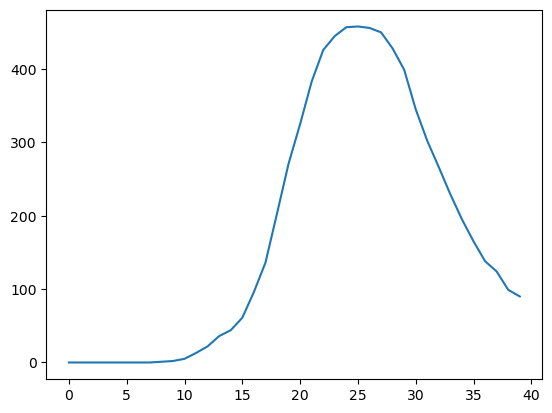

In [94]:
plt.plot([len(x) for x in reach_idxs_pca])

In [125]:
# Identify reaches that contain the most vectors that have lower bias for FCCA than PCA
nbetter = []
err = np.zeros((len(correction_reach), 50, 2))


for i, j in enumerate(correction_reach):
    tt = transition_times[j]
    # If the teach contains a secondary peak in dt accompanied by a dip in velocity, plot it
    z = Z[tt[0]:tt[1], :]
    sidx = np.argwhere(np.diff(pkassign[j]))[0][0] + 1
#    for k, pnt in enumerate([sidx, sidx+3, sidx+6]):
    for k, pnt in enumerate(np.arange(sidx, min(window_centers[-1], z.shape[0]))):
        if pnt < z.shape[0] and pnt < window_centers[-1]:
            x = z[pnt, 0]
            dx = z[pnt, 2]
            y = z[pnt, 1]
            dy = z[pnt, 3]
    
            window_idx = list(window_centers).index(pnt)
            if correction_reach.index(j) in reach_idxs_pca[window_idx]:
                zpredf = np.concatenate([zpred_boot_fca[window_idx][b][reach_idxs_pca[window_idx].index(correction_reach.index(j))][np.newaxis, :] for b in range(n_boots)])

                zpredf = np.mean(zpredf, axis=0)
                zpredp = np.concatenate([zpred_boot_pca[window_idx][b][reach_idxs_pca[window_idx].index(correction_reach.index(j))][np.newaxis, :] for b in range(n_boots)])
                zpredp = np.mean(zpredp, axis=0)

                # Minimize the angle            

                tan0 = np.array([dx, dy])/np.linalg.norm(np.array([dx, dy]))
                tanf = zpredf[2:4]/np.linalg.norm(zpredf[2:4])
                tanp = zpredp[2:4]/np.linalg.norm(zpredp[2:4])

                err[i, k, 0] = np.arccos(tan0/np.linalg.norm(tan0) @ tanf/np.linalg.norm(tanf))
                err[i, k, 1] = np.arccos(tan0/np.linalg.norm(tan0) @ tanp/np.linalg.norm(tanp))

                # err[k, 0] = np.linalg.norm(np.array([x, y]) - zpredf[2:4])
                # err[k, 1] = np.linalg.norm(np.array([x, y]) - zpredp[2:4])
            else:
                err[i, k, 0] = np.inf
                err[i, k, 1] = np.inf
        else:

            err[i, k, 0] = np.inf


    nbetter.append(np.argwhere(err[i, :, 0] < err[i, :, 1]).squeeze().size)

In [126]:
# Start with index 20 and beyond - intersection of valid reach indices and correction reaches
#idx_set1 = list(np.array(correction_reach)[list(reach_idxs_pca[20])])
idx_set1 = np.array(correction_reach)[np.argsort(nbetter)[::-1]]

straight_dev = dat['straight_dev']
ordering = np.argsort(straight_dev)[::-1]

idx_set2 = ordering[0:len(ordering)//2]

intrsct = list(set(idx_set1[:len(idx_set1)//2]).intersection(set(idx_set2)))
intrsct = idx_set1

In [206]:
from matplotlib.legend_handler import HandlerPatch
import matplotlib.patches as mpatches

In [207]:
def make_legend_arrow(legend, orig_handle,
                      xdescent, ydescent,
                      width, height, fontsize):
    p = mpatches.FancyArrow(0, 0.5*height, width, 0, length_includes_head=True, head_width=0.75*height )
    return p

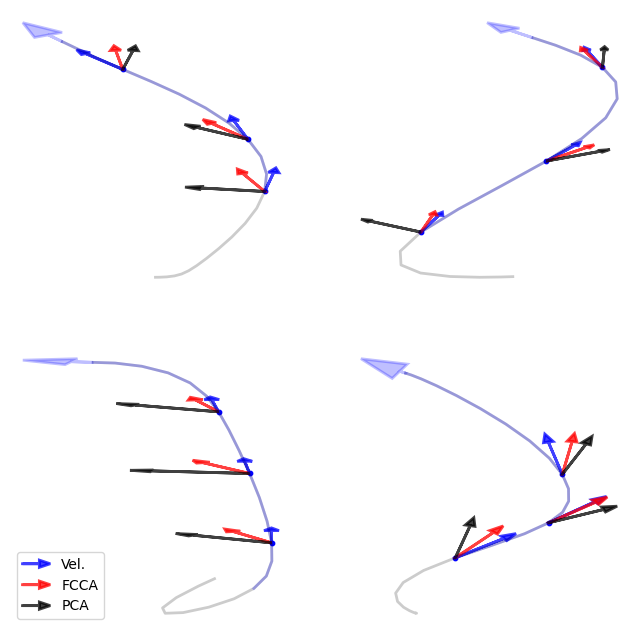

In [209]:
# Choose 4 trajectories with high curvature and obtain bias/variance of decoding from FCCA/PCA
fig, ax = plt.subplots(2, 2, figsize=(8, 8))

straight_dev = dat['straight_dev'][correction_reach]
ordering = np.argsort(straight_dev)[::-1]

# For this to be repeatable, have to fix the seed above.
# 0, 16
# 11 needs 3, 6, 9
# 24
# Shorten 34
reaches = [intrsct[i] for i in [0, 16, 11, 35]]

# Manually adjust these to get the curvature point
#trpnts = [window_centers[20] + 3, window_centers[20] - 3, window_centers[20] + 1, window_centers[20] + 2]
trpnts = [window_centers[20], window_centers[20], window_centers[20], window_centers[20]]

hw_ = [3, 3, 1, 3]
hl_ = [4.5, 4.5, 1, 4.5]
hw = [1, 1, 0.3, 1]
truncate = [12, 12, 1, 5]
scales = [6, 8, 2, 6]
for i, j in enumerate(reaches):         
    trpnt = trpnts[i]

    a = ax[np.unravel_index(i, (2, 2))]
    tt = transition_times[j]
    # If the teach contains a secondary peak in dt accompanied by a dip in velocity, plot it
    z = Z[tt[0]:tt[1], :]

    # (x, y): a point along the curve1=0, 11, 28, 35
    # (dx, dy): velocity vector at that point
    x = []
    y = []
    dx = []
    dy = []

    dxf = []
    dyf = []

    dxp = []
    dyp = []

    # Highlight corrective portion
    sidx = np.argwhere(np.diff(pkassign[j]))[0][0] + 1

    if i == 0 or i == 1:
        pnts = [sidx, sidx+3, sidx+8]
    elif i == 2:
        pnts = [sidx+3, sidx+6, sidx+9]
    elif i == 3:
        pnts = [sidx, sidx+3, sidx+7]

    # Plot all the arrows we can. 
    for k, pnt in enumerate(pnts):
        x.append(z[pnt, 0])
        dx.append(z[pnt, 2])
        y.append(z[pnt, 1])
        dy.append(z[pnt, 3])

        # Co-plot the average velocity prediction over bootstraps
        window_idx = list(window_centers).index(pnt)
        # Verify indexing
        #zz = ztest[window_idx][list(reach_idxs_pca[window_idx]).index(correction_reach.index(j))].squeeze()
        #a.arrow(zz[0], zz[1], norm * zz[2], norm * zz[3], head_width=0.5, color='r', alpha=0.75)

        zpred = np.concatenate([zpred_boot_fca[window_idx][b][reach_idxs_pca[window_idx].index(correction_reach.index(j))][np.newaxis, :] for b in range(n_boots)])
        dxf.append(np.mean(zpred[:, 2]))
        dyf.append(np.mean(zpred[:, 3]))

        zpred = np.concatenate([zpred_boot_pca[window_idx][b][reach_idxs_pca[window_idx].index(correction_reach.index(j))][np.newaxis, :] for b in range(n_boots)])
        dxp.append(np.mean(zpred[:, 2]))
        dyp.append(np.mean(zpred[:, 3]))

    trajectory = rotate_reach(z, dat['target_pairs'][j], np.pi/2)
    xadj, yadj, dxadj, dyadj = adjust_vectors(z[:, 0:2], trajectory, x, y, dx, dy)
    _, _, dxfadj, dyfadj = adjust_vectors(z[:, 0:2], trajectory, x, y, dxf, dyf)
    _, _, dxpadj, dypadj = adjust_vectors(z[:, 0:2], trajectory, x, y, dxp, dyp)


    a.plot(trajectory[:-truncate[i], 0], trajectory[:-truncate[i], 1], 'k', alpha=0.2, linewidth=2)
    a.plot(trajectory[sidx:-truncate[i], 0], trajectory[sidx:-truncate[i], 1], 'b', alpha=0.25, linewidth=2)
    a.arrow(trajectory[-truncate[i] - 1, 0], trajectory[-truncate[i] - 1, 1], 
                trajectory[-truncate[i] - 1, 0] - trajectory[-truncate[i] - 2, 0], trajectory[-truncate[i] - 1, 1] - trajectory[-truncate[i] - 2, 1], 
                head_width=hw_[i], head_length=hl_[i], color="b", alpha=0.25, linewidth=2, edgecolor=None)

    a.scatter(xadj, yadj, color='b', s=10)

    for k in range(len(x)):
        scale = scales[i]
        norm = np.sqrt(dxadj[k]**2 + dyadj[k]**2)
        normf = np.sqrt(dxfadj[k]**2 + dyfadj[k]**2)
        normp = np.sqrt(dxpadj[k]**2 + dypadj[k]**2)

        a1 = a.arrow(xadj[k], yadj[k], scale/norm * dxadj[k], scale/norm * dyadj[k], head_width=hw[i], color='b', alpha=0.75, linewidth=2, label='Vel.')
        a2 = a.arrow(xadj[k], yadj[k], scale/normf * dxfadj[k], scale/normf * dyfadj[k], head_width=hw[i], color='r', alpha=0.75, linewidth=2, label='FCCA')
        a3 = a.arrow(xadj[k], yadj[k], scale/normp * dxpadj[k], scale/normp * dypadj[k], head_width=hw[i], color='k', alpha=0.75, linewidth=2, label='PCA')


    


    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.spines['bottom'].set_visible(False)
    a.spines['left'].set_visible(False)

    a.set_xticks([])
    a.set_yticks([])

# Adjust x/y ranges
ax[1, 0].legend([a1, a2, a3], ['Vel.', 'FCCA', 'PCA'], handler_map={mpatches.FancyArrow: HandlerPatch(patch_func=make_legend_arrow)})    


fig.savefig('/home/akumar/nse/neural_control/figs/decodingbias/reach_vectors.pdf', bbox_inches='tight', pad_inches=0)


In [511]:
th = np.arccos(tan0/np.linalg.norm(tan0) @ tan1/np.linalg.norm(tan1))

In [526]:
th

2.664870651581638

In [547]:
tan0

array([ 1.74218371, -1.82283964])

In [549]:
dy[1]

-1.8228396390800725

In [550]:
tan1

array([-2.60098012,  0.89466996])

In [553]:
dxadj[1]

-0.7761243834552958

In [554]:
dyadj[1]

2.638780558093882

In [555]:
tan2

array([-2.60098012,  0.89466996])

In [562]:
tan0

array([ 1.74218371, -1.82283964])

In [563]:
dx[1]

1.7421837145206354

In [564]:
tan2

array([-2.60098012,  0.89466996])

In [565]:
dy[1]

-1.8228396390800725

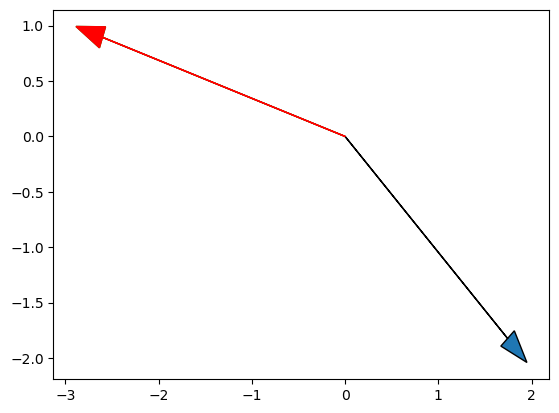

In [561]:
idx = np.argwhere(np.bitwise_and(np.isclose(z[:, 0], x[1]), np.isclose(z[:, 1], y[1])))[0][0]
tan0 = z[idx, 0:2] - z[idx - 1, 0:2]
tan1 = trajectory[idx] - trajectory[idx - 1]
th = np.arccos(tan0/np.linalg.norm(tan0) @ tan1/np.linalg.norm(tan1))
R = np.linalg.norm(tan1)/np.linalg.norm(tan0)

fig, ax = plt.subplots()
ax.arrow(0, 0, tan1[0], tan1[1], head_width=0.2, color='g')
ax.arrow(0, 0, tan0[0], tan0[1], head_width=0.2)
tan2 = R * Rot(th) @ tan0
ax.arrow(0, 0, tan2[0], tan2[1], head_width=0.2, color='r')

array([[ 0.88850387,  0.45886913],
       [-0.45886913,  0.88850387]])

In [534]:
np.sin(th)

0.45886913220400116

In [531]:
np.pi

3.141592653589793

In [516]:
np.pi

3.141592653589793

In [514]:
R * Rot(th) @ tan0

array([-2.60098012,  0.89466996])

In [513]:
tan1

array([-2.60098012,  0.89466996])

In [431]:
np.isclose(z, np.array(x[0], y[0]))

array([[False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [ True, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, Fa

In [ ]:
np.argwhere(np.isclose(z[:, 0], x[idx]))

In [429]:
[np.argwhere(np.isclose(z[:, 0], x[idx])) == np.argwhere(np.isclose(trajectory[:, 0], xadj[idx])) for idx in range(len(x))]

[array([[ True]]),
 array([[ True]]),
 array([[ True]]),
 array([[ True],
        [False]]),
 array([[ True]]),
 array([[ True]])]

In [424]:
np.argwhere(np.isclose(trajectory[:, 0], xadj[0]))

array([[16]])

In [425]:
trajectory

array([[  0.        ,   0.        ],
       [ -0.27376386,   0.09115247],
       [ -0.78085899,   0.30322934],
       [ -1.41810671,   0.6971905 ],
       [ -2.01748152,   1.35814608],
       [ -2.39689539,   2.3762041 ],
       [ -2.44176506,   3.82964048],
       [ -2.15521125,   5.78859631],
       [ -1.63392986,   8.33189683],
       [ -0.9844425 ,  11.54244343],
       [ -0.24237179,  15.45713932],
       [  0.62760017,  19.98867378],
       [  1.61353229,  24.86838091],
       [  2.49546847,  29.66215765],
       [  2.81994233,  33.88569312],
       [  2.11841284,  37.18621338],
       [  0.23880556,  39.48838983],
       [ -2.49806792,  40.99768743],
       [ -5.46534274,  42.054573  ],
       [ -8.06632285,  42.94924296],
       [ -9.96344114,  43.81700884],
       [-11.08512607,  44.64643802],
       [-11.50565894,  45.35357077],
       [-11.33576314,  45.86146325],
       [-10.68342622,  46.14736058],
       [ -9.67489508,  46.24720728],
       [ -8.4889795 ,  46.22979081],
 

In [426]:
xadj[0]

0.2388055588655753

In [ ]:
# For each recording session, what is the gap between the total length of the time series and the last transition time?

In [39]:
data_files = glob.glob('/mnt/Secondary/data/sabes/*.mat')

In [41]:
dt = np.zeros(len(data_files))
for i, data_file in enumerate(data_files):
    dat = load_sabes(data_file)
    dat = reach_segment_sabes(dat, data_file=data_file.split('/')[-1].split('.mat')[0])
    dt[i] = dat['spike_rates'].squeeze().shape[0] - dat['transition_times'][-1][1]

Reminder that start times depend on the bin size


/home/akumar/nse/neural_control/segmentation.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Reminder that start times depend on the bin size
Reminder that start times depend on the bin size
Reminder that start times depend on the bin size
Reminder that start times depend on the bin size
Reminder that start times depend on the bin size
Reminder that start times depend on the bin size
Reminder that start times depend on the bin size
Reminder that start times depend on the bin size
Reminder that start times depend on the bin size
Reminder that start times depend on the bin size
Reminder that start times depend on the bin size
Reminder that start times depend on the bin size
Reminder that start times depend on the bin size
Reminder that start times depend on the bin size
Reminder that start times depend on the bin size
Reminder that start times depend on the bin size
Reminder that start times depend on the bin size
Reminder that start times depend on the bin size
Reminder that start times depend on the bin size
Reminder that start times depend on the bin size
Reminder that start 

In [49]:
dt * .05

array([6.500e-01, 6.600e+00, 2.150e+00, 5.350e+00, 1.350e+00, 1.350e+00,
       5.500e-01, 7.000e-01, 2.500e-01, 1.000e+00, 7.000e-01, 2.450e+00,
       1.150e+00, 1.500e+00, 5.500e-01, 8.500e-01, 9.500e-01, 7.500e-01,
       8.500e-01, 1.100e+00, 2.500e-01, 4.000e-01, 3.000e-01, 1.050e+00,
       7.000e-01, 1.300e+00, 6.000e-01, 7.000e-01, 1.450e+00, 3.600e+00,
       5.450e+00, 7.900e+00, 6.604e+02, 2.750e+00, 1.600e+00, 7.750e+00,
       1.500e+00, 1.030e+01])

In [55]:
data_files

['/mnt/Secondary/data/sabes/indy_20161017_02.mat',
 '/mnt/Secondary/data/sabes/indy_20160426_01.mat',
 '/mnt/Secondary/data/sabes/indy_20160622_01.mat',
 '/mnt/Secondary/data/sabes/indy_20160624_03.mat',
 '/mnt/Secondary/data/sabes/indy_20160627_01.mat',
 '/mnt/Secondary/data/sabes/indy_20160630_01.mat',
 '/mnt/Secondary/data/sabes/indy_20160915_01.mat',
 '/mnt/Secondary/data/sabes/indy_20160921_01.mat',
 '/mnt/Secondary/data/sabes/indy_20160930_02.mat',
 '/mnt/Secondary/data/sabes/indy_20160930_05.mat',
 '/mnt/Secondary/data/sabes/indy_20161005_06.mat',
 '/mnt/Secondary/data/sabes/indy_20161006_02.mat',
 '/mnt/Secondary/data/sabes/indy_20161007_02.mat',
 '/mnt/Secondary/data/sabes/indy_20161011_03.mat',
 '/mnt/Secondary/data/sabes/indy_20161013_03.mat',
 '/mnt/Secondary/data/sabes/indy_20161014_04.mat',
 '/mnt/Secondary/data/sabes/indy_20161024_03.mat',
 '/mnt/Secondary/data/sabes/indy_20161025_04.mat',
 '/mnt/Secondary/data/sabes/indy_20161026_03.mat',
 '/mnt/Secondary/data/sabes/ind

In [56]:
dat = load_sabes(data_files[1])